## Capstone Project 1 Proposal: Supplier Pricing Prediction & Segmentation

### Project Scope: 
Caterpillar (construction equipment manufacturer) relies on a variety of suppliers to manufacture tube assemblies for their equipment. These assemblies are required in their equipment to lift, load and transport heavy construction loads. We are provided with detailed tube, component, and annual volume datasets. Our goal is to build and train a model that can predict how much a supplier will quote for a given tube assembly based on given supplier pricing, and use this information to further categorize assemblies and suppliers such that any movement in business criteria example recency, frequency, total spend, supplier rebates etc can be accurately classified and responded with appropriate supplier strategy. 

Project will be divided in two sections. 

1. Section 1 : Predict Supplier Pricing.
2. Section 2: Categorize Assembly & Suppliers

### Challenges: 
We are provided with 21 tables. Challenge is to come up with a consolidated table with an equation (relevant features) that can predict supplier pricing. Reason, our model should demonstrate that by varying assembly specifications, supplier predicted pricing is also getting impacted. Example, tube assembly without an additonal attachement should cost less compared to others. Also, assembly which is used to be purchased by a tier 1 supplier (based on highest total spend) is now a tier 2 suppplier due to significant reduction in business spend. 

How to build a consolidated table so that we can build the model is a challenge.

### Problem Solving: 
1. Built primary table using left merge on tube_assembly_id.
2. Removed 22 columns from the primary table and 59 columns from the secondary table that had > 77% null values.
3. Built secondary table by concatenating columns instead of using left merge. This helped reduce null values in the secondary table. 
4. Created pre-classification criteria by anticipating business needs and labelled categories in the table 'Segmented' to be used for clustering.   
5. Built combined Final Table which consists of Primary and Secondary tables to be used for supplier prediction.
6. Prepared Final and Segmented tables for modelling by ensuring data conversion is complete, there are no missing values or duplicates in the data.  
7. Ran few different algorithms to predict supplier pricing such as regression and ensemble algorithms.
8. Random Forest, which is an ensemble algorithm resulted in least RMSE error (predicted Vs actual) and most accurate predicted value using training data.   
8. For categorization, I used unsupervised learning algorithm 'K-Mean' to form clusters (categories) of assemblies and suppliers based on pre-classification criteria, which helped us capture actionable business insights and future modelling possibilities.

### Feature Engineering: 
1. Removed null values from the secondary and primary table and kept limited yet relevant features to build the final table for modelling. 
2. Developed pre-classification criteria such as recency, frequency, total spend, rebate, market difficulty, length of contract relationship, supplier preference etc to benchmark assemblies and suppliers and explore business opportunities.   

### Model Selection Plan: 
I plan to use models such as Linear Regression, Decision Tree, Random forest, PCA, and K-means to evalaute which algorithm is relevant and can help us capture business insights more accurately.   

### Tube Assembly Picture with Components:
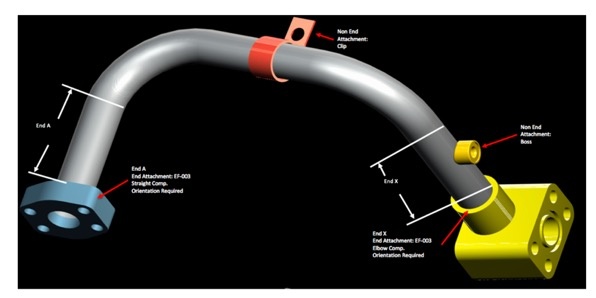

## Section1: Modelling for Supplier Pricing Prediction: 

#### Question 1.  How should we build relevant features in our model for making supplier price predicitons?
Approach: This will be carried out in 4 sections (A,B,C & D) separately. We will review each section for common fields and build new features using existing attributes. In each section, we will follow 3 main themes to ensure that we have selected relevant features for building our predictive model.  

### Section A: Building Primary Table using tube _assembly_id: 
##### a. Preparation:
1. Explore Bill of Materials (BOM).
2. Treat null values in BOM. 
3. Calculate how many components/quantities are required to build each tube assembly.
 
##### b. Build & Explore: 
1. Merge all primary tables along tube_assembly_id.
2. Perform Exploratory Data Analysis (EDA). 
3. Identify and treat outliers, miss-match, missing values. 

##### c. Add New Features:
1. Example Tube Area, Extended Cost and more.

#### Load Libraries: 

In [251]:
#Load libraries except ML Libraries, which are loaded in later sections:

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import glob as gl

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["patch.force_edgecolor"] = True

from scipy.stats import stats

from numpy.random import seed

#### Build Primary Table:

In [3]:
#Load Dataset having common tube_assembly_id as the primary key:

#1.Tube
df_tube = pd.read_csv('tube.csv')

#2. Bill of material
df_bill = pd.read_csv('bill_of_materials.csv')

#3. Specifications
df_spec = pd.read_csv('specs.csv')

#4. Tube End form: (This is merged with the final table in the later section)
df_end_form = pd.read_csv('tube_end_form.csv')

#5. Training
df_train= pd.read_csv('train_set.csv',parse_dates=True) 

#### Explore Bill of Materials: 

In [4]:
#View Table
df_bill.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Learn Distribution of Unique Components and Quantities:

In [5]:
# All component_id's:
component_id= df_bill[['component_id_1', 'component_id_2', 'component_id_3', 'component_id_4','component_id_5', 'component_id_6', 'component_id_7', 'component_id_8']]

# All corresponding quantity_id's:
quantity_id = df_bill[['quantity_1', 'quantity_2', 'quantity_3', 'quantity_4', 'quantity_5', 'quantity_6', 'quantity_7', 'quantity_8']]               

#Unique components_id parts:
component_id_unique=component_id.nunique().reset_index()

#Total quantity_id's
quantity_id_sum=quantity_id.sum().reset_index()

#Summarizing table: 
df_comp_qty = pd.concat([component_id_unique, quantity_id_sum], axis = 'columns', ignore_index=True)

#Assign column names:
df_comp_qty.columns = ['component_id', 'unique_parts', 'quantity_id', 'total_quantity']

#View Summary table: 
df_comp_qty

,component_id,unique_parts,quantity_id,total_quantity
0,component_id_1,1079,quantity_1,29870.0
1,component_id_2,834,quantity_2,22565.0
2,component_id_3,509,quantity_3,4897.0
3,component_id_4,204,quantity_4,625.0
4,component_id_5,62,quantity_5,95.0
5,component_id_6,19,quantity_6,30.0
6,component_id_7,4,quantity_7,7.0
7,component_id_8,1,quantity_8,1.0


#### Visualize BOM Distribution: 

Text(0.5,0,'Distribution of Parts')

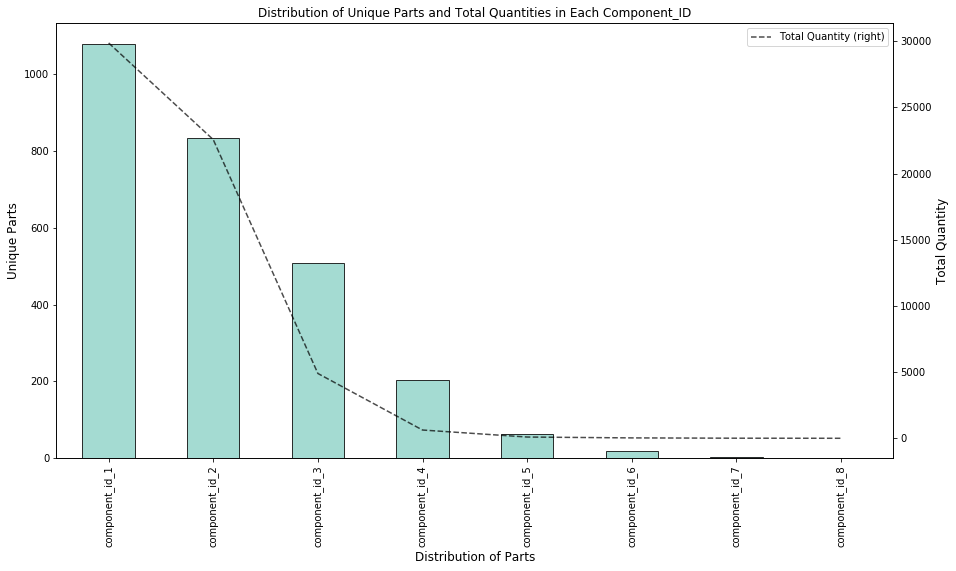

In [6]:
#Visualize using bar and line chart:
fig= plt.figure(figsize = (15,8))
plt.title('Distribution of Unique Parts and Total Quantities in Each Component_ID', fontsize = 12)

#Line Chart showing total quantity of parts required by each component_id:
ax1 = quantity_id.sum().plot(secondary_y = True, label='Total Quantity', legend= True, linestyle= '--', color = 'black', alpha = 0.7)
ax1.grid('off')
ax1.set_ylabel('Total Quantity', fontsize = 12)

#ax1.legend(title='Total Quantity')
#Bar Chart showing distribution of parts in each component_id: 
ax2= component_id.nunique().plot(kind = 'bar', alpha = 0.8, cmap = 'Set3')
ax2.grid(False)
ax2.set_ylabel('Unique Parts', fontsize = 12)
ax2.set_xlabel('Distribution of Parts', fontsize = 12)

#### Observation: 
1. Component_id 1 & 2 have maximum bulk of quantities required to make up these assemblies.
2. Component_id 3 & 4 intercepts the bar graph in the middle and not top, meaning there are some null values there. 
3. Component_id_5 and beyond, we don't have data on quantity hence, should be rejected. 

Let's us see distribution of null values in the BOM table.

#### Distribution of Non Missing Values in BOM: 

                  Non Missing Values
tube_assembly_id               21198
component_id_1                 19149
quantity_1                     19149
component_id_2                 14786
quantity_2                     14786


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

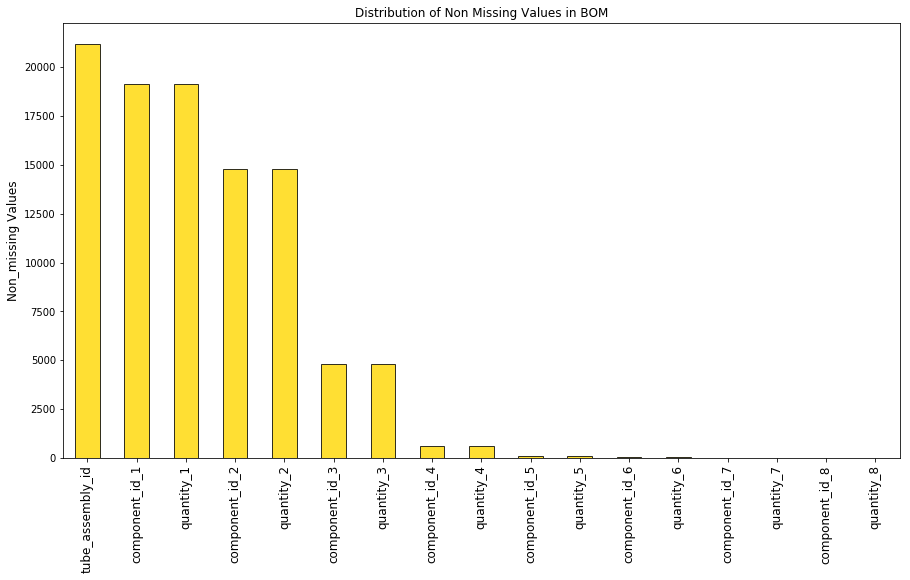

In [7]:
#Identify Non Missing Values: 
df_bill_nonnull= pd.DataFrame(df_bill.notnull().sum())

#Assign Column Labels:
df_bill_nonnull.columns= ['Non Missing Values']

# View Table: 
print(df_bill_nonnull.head())

#Visualize
plt.figure(figsize= (15,8))
df_bill.notnull().sum().plot(kind = 'bar', color = 'gold', alpha = 0.8)
plt.ylabel('Non_missing Values', fontsize =12)
plt.title('Distribution of Non Missing Values in BOM', fontsize =12)
plt.xticks(fontsize = 12)

#### Observation:
1. From above graph, we can observe that missing values in the BOM increase significantly in component_id_3 and beyond. 
2. A good workable data range is between tube_assembly_id and quantity_2.
3. Hence, to avoid working with missing values we will <b>reject columns component_id_3 and beyond</b>. 
4. However, there might be some assemblies which are made of more than two component_id's.
5. We will create a new feature to account for how many components and quantities were used to build an assembly before rejecting the columns.    
        

#### Calculating number of components and quantities required by each tube assembly as per BOM: 
Example TA-00001 has two component_id's each requiring 2 quantities:
1. Equation = Sum of product of component_id and quantities 

In [8]:
#Count of component_id's in each tube assembly:
df_bill_comp= df_bill.groupby('tube_assembly_id')['component_id_1','component_id_2', 'component_id_3','component_id_4','component_id_5','component_id_6', 'component_id_7','component_id_8'].nunique()

#Quantity of each component_id per assembly: 
df_bill_cqty= df_bill.groupby('tube_assembly_id')['quantity_1','quantity_2', 'quantity_3','quantity_4','quantity_5','quantity_6', 'quantity_7','quantity_8'].sum()


#Optional: Above cade can be re-written as: 
#df_bill_comp= df_bill.groupby(['tube_assembly_id'])['component_id_1','component_id_2', 'component_id_3', 'component_id_4', 'component_id_5', 'component_id_6', 'component_id_7','component_id_8'].apply(lambda x: x.count())    
#df_bill_cqty= df_bill.groupby(['tube_assembly_id'])['quantity_1','quantity_2', 'quantity_3', 'quantity_4', 'quantity_5', 'quantity_6', 'quantity_7','component_id_8'].apply(lambda x: x.sum())

In [9]:
#Calculate total count of components in each assembly: 
df_bill_comp['count_compid'] = (df_bill_comp['component_id_1']
                                 + df_bill_comp['component_id_2'] 
                                 + df_bill_comp['component_id_3'] 
                                 + df_bill_comp['component_id_4'] 
                                 + df_bill_comp['component_id_5']
                                 + df_bill_comp['component_id_6'] 
                                 + df_bill_comp['component_id_7'] 
                                 + df_bill_comp['component_id_8']) 


#Calculate total quantities in each assembly:
df_bill_cqty['sum_qtyid'] = (df_bill_cqty['quantity_1'] 
                                 + df_bill_cqty['quantity_2']
                                 + df_bill_cqty['quantity_3']
                                 + df_bill_cqty['quantity_4']
                                 + df_bill_cqty['quantity_5']
                                 + df_bill_cqty['quantity_6']     
                                 + df_bill_cqty['quantity_7']
                                 + df_bill_cqty['quantity_8']) 

# Calculate sum of product of components and quantities in each tube assembly:  
sum_compqty_id = ((df_bill_comp['component_id_1']) * (df_bill_cqty['quantity_1']) 
                                 + (df_bill_comp['component_id_2']) * (df_bill_cqty['quantity_2'])
                                 + (df_bill_comp['component_id_3']) * (df_bill_cqty['quantity_3'])
                                 + (df_bill_comp['component_id_4']) * (df_bill_cqty['quantity_4'])
                                 + (df_bill_comp['component_id_5']) * (df_bill_cqty['quantity_5'])
                                 + (df_bill_comp['component_id_6']) * (df_bill_cqty['quantity_6'])
                                 + (df_bill_comp['component_id_7']) * (df_bill_cqty['quantity_7'])
                                 + (df_bill_comp['component_id_8']) * (df_bill_cqty['quantity_8']))



In [10]:
#View table: 
df_bill_comp.head()

,component_id_1,component_id_2,component_id_3,component_id_4,component_id_5,component_id_6,component_id_7,component_id_8,count_compid
tube_assembly_id,,,,,,,,,
TA-00001,1,1,0,0,0,0,0,0,2
TA-00002,1,0,0,0,0,0,0,0,1
TA-00003,1,0,0,0,0,0,0,0,1
TA-00004,1,0,0,0,0,0,0,0,1
TA-00005,1,1,1,0,0,0,0,0,3


In [11]:
#View Table: 
df_bill_cqty.head()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,sum_qtyid
tube_assembly_id,,,,,,,,,
TA-00001,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
TA-00002,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00003,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00004,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
TA-00005,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0


In [12]:
sum_compqty_id.head()

tube_assembly_id
TA-00001    4.0
TA-00002    2.0
TA-00003    2.0
TA-00004    2.0
TA-00005    3.0
dtype: float64

#### Treating Null Values in BOM table 

In [13]:
#checking for columns with less than 31 percent of null data
bill_31= df_bill.isnull().sum()/df_bill.shape[0]*100 < 31 #data up to 69% of not null values

#checking for columns with less than 76 percent of null data
bill_77=  df_bill.isnull().sum()/df_bill.shape[0]*100 < 77 #data upto 24% of not null values 

#Checking impact of dropping columns
bill_77.value_counts()-bill_31.value_counts()
bill_77

tube_assembly_id     True
component_id_1       True
quantity_1           True
component_id_2       True
quantity_2           True
component_id_3      False
quantity_3          False
component_id_4      False
quantity_4          False
component_id_5      False
quantity_5          False
component_id_6      False
quantity_6          False
component_id_7      False
quantity_7          False
component_id_8      False
quantity_8          False
dtype: bool

#### Observation: 
1. Columns between 31% and 77% of null values have no impact on bill of materials table. 
2. As a result, following columns would represent hard to predict assemblies with fewer examples. 
3. After building our model, we can assess impact by adding back dropped columns (if required).

#### Dropped Columns: 
a) component_id_3 to component_id_4
 
b) quantity_3 to quantity_8    

In [14]:
#Hence , rejecting 77% of the Null values:
bill_77=(df_bill.isnull().sum()/df_bill.shape[0]* 100)<77
bill = df_bill.loc[:,bill_77]
bill.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2
0,TA-00001,C-1622,2.0,C-1629,2.0
1,TA-00002,C-1312,2.0,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0


#### Re-contructing BOM table containing component Id's and quantities rows wise instead of columns: 

In [15]:
# Apply Equation = Sum of product of component_id and quantities 
tube_comp_qty=sum_compqty_id

#Converting series tube_comp_qty to dataframe
df_tube_comp_qty=pd.DataFrame(tube_comp_qty, columns=['tube_comp_qty'])

# Rounding off result to 1 decimal place
df_tube_comp_qty=df_tube_comp_qty.round(decimals=1).reset_index()

#View table:
df_tube_comp_qty.head()

,tube_assembly_id,tube_comp_qty
0,TA-00001,4.0
1,TA-00002,2.0
2,TA-00003,2.0
3,TA-00004,2.0
4,TA-00005,3.0


In [16]:
#Merge df_final_bill with df_tube_comp_qty:
df_bill_final = pd.merge(left = bill, right= df_tube_comp_qty, on = 'tube_assembly_id', how = 'inner')

In [17]:
#View table:
df_bill_final.head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,tube_comp_qty
0,TA-00001,C-1622,2.0,C-1629,2.0,4.0
1,TA-00002,C-1312,2.0,NaN,NaN,2.0
2,TA-00003,C-1312,2.0,NaN,NaN,2.0
3,TA-00004,C-1312,2.0,NaN,NaN,2.0
4,TA-00005,C-1624,1.0,C-1631,1.0,3.0


In [18]:
# Check if tube_comp_qty amount is correct: 
df_bill_final[df_bill_final['tube_assembly_id']=='TA-00001']

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,tube_comp_qty
0,TA-00001,C-1622,2.0,C-1629,2.0,4.0


#### Merging other primary tables with the training dataset

In [19]:
#Test: Replace df_bill with df_bill_final to recreate final table:
# First Merge: Train data with bill of material
df_first= pd.merge(left = df_train, right = df_bill_final, how = 'left', on = 'tube_assembly_id')

# Second Merge: First Merged table with tube
df_second= pd.merge(left = df_first, right = df_tube, how = 'left', on = 'tube_assembly_id')

# Third Merge: Second Merged table with Specs
df_third= pd.merge(left = df_second, right = df_spec, how = 'left', on = 'tube_assembly_id')

df_third.head()

#Tube end form will be merged later.

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Checking Null Values in the Primary table
#Rejecting 77% of the Null values:
prime_77= (df_third.isnull().sum()/df_third.shape[0]*100) < 77
prime_77= df_third.loc[:,prime_77]
prime_77.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,19.05,N,N,N,N,EF-008,EF-008,0,0,0


#### Merge Tube end form to build final primary table:

In [21]:
# View table: 
df_end_form.head()

,end_form_id,forming
0,EF-001,Yes
1,EF-002,No
2,EF-003,No
3,EF-004,No
4,EF-005,Yes


In [22]:
#Merge end_a
prime_77_end = pd.merge(left = prime_77, right= df_end_form, left_on = 'end_a', right_on = 'end_form_id', how = 'left')

#Rename column name
prime_77_end=prime_77_end.rename(columns={'forming': 'forming_end_a'})

#Drop column:
prime_77_end.drop(columns= 'end_form_id', axis = 1, inplace=True)

#View table: 
prime_77_end.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,N,EF-008,EF-008,0,0,0,Yes


In [23]:
#Merge end_x
prime_77_final = pd.merge(left = prime_77_end, right= df_end_form, left_on = 'end_x', right_on = 'end_form_id', how = 'left')

#Rename column name
prime_77_final=prime_77_final.rename(columns={'forming': 'forming_end_x'})

#Drop Column: 
prime_77_final=prime_77_final.drop('end_form_id', axis = 1)

#View Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes


#### EDA Prime Table: 
#### Question 2: Are there any outliers in the primary table? 

In [24]:
#Check Statistics: 
prime_77_final.describe()

,annual_usage,min_order_quantity,quantity,cost,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,num_boss,num_bracket,other
count,30213.000000,30213.000000,30213.000000,30213.000000,28751.000000,21084.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000,30213.000000
mean,120.369377,2.084699,38.389369,13.433317,1.641021,1.566591,2.926125,17.223018,1.384782,97.647605,3.813061,42.231223,0.025254,0.003542,0.013603
std,1590.331872,12.742776,70.761392,28.663200,0.488404,0.504756,1.176712,18.125973,0.638610,63.230131,2.199564,200.313458,0.184975,0.069664,0.150840
min,0.000000,0.000000,1.000000,0.503553,1.000000,1.000000,0.000000,3.180000,0.710000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,3.878190,1.000000,1.000000,2.000000,9.520000,0.890000,48.000000,2.000000,19.050000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,10.000000,6.521146,2.000000,2.000000,3.000000,12.700000,1.240000,86.000000,3.000000,31.750000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,40.000000,13.431781,2.000000,2.000000,4.000000,19.050000,1.650000,133.000000,5.000000,50.800000,0.000000,0.000000,0.000000
max,150000.000000,535.000000,2500.000000,1000.000000,4.000000,4.000000,13.000000,203.200000,7.900000,1333.000000,17.000000,9999.000000,5.000000,3.000000,8.000000


#### Observation: 
1. Bend_Radius max value = 9999.00
2. Max diameter = 203.2

#### Bend radius , Diameter and Number of Bends in the Tube Assembly:
#### Question 3: Do we have bends in the tube assembly and how many? 

In [25]:
#Check Relationship between Bend Radius and Diameter: 
prime_77_final[['tube_assembly_id', 'bend_radius', 'diameter', 'num_bends']][prime_77_final.diameter==203.2].sort_values(by = 'diameter',ascending= True).head()

,tube_assembly_id,bend_radius,diameter,num_bends
17498,TA-11307,0.0,203.2,0
17499,TA-11307,0.0,203.2,0
17500,TA-11307,0.0,203.2,0
17501,TA-11307,0.0,203.2,0
17502,TA-11307,0.0,203.2,0


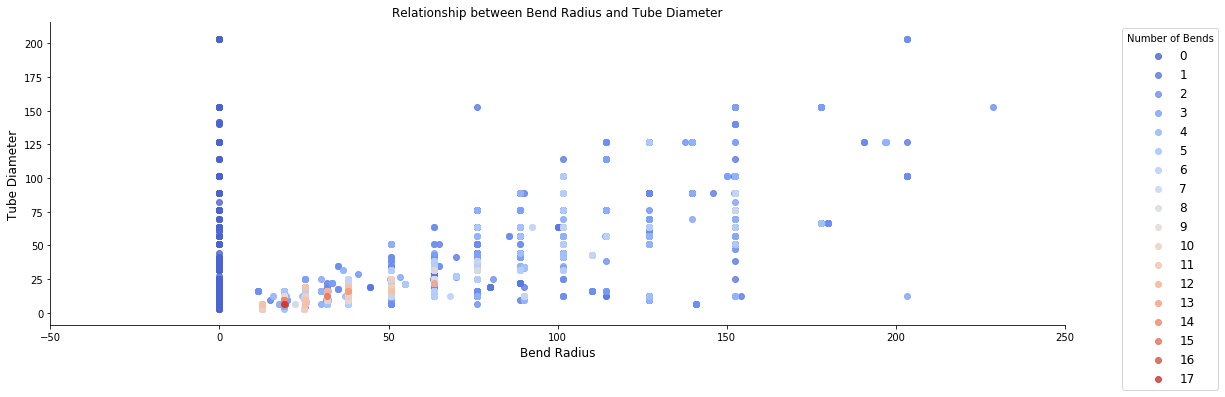

In [26]:
#Visualize Bend Radius, Tube Diameter and Number of Bends :
sns.lmplot(x='bend_radius', y = 'diameter', data = prime_77_final, fit_reg= False, hue = 'num_bends', palette='coolwarm', aspect = 3, legend=None)
plt.xlim(-50,250)
plt.title('Relationship between Bend Radius and Tube Diameter')
plt.xlabel('Bend Radius', fontsize = 12)
plt.ylabel('Tube Diameter', fontsize = 12)
plt.legend(title= 'Number of Bends', loc = 'best', bbox_to_anchor=(1.05,1), fontsize = 12)

#### Observation: 
1. Some assemblies have zero bend radius (straight) while some have multiple bends as high as 17. 
2. Assemblies with bend radius under 50 have more than 9 bends while as bend radius increases greater than 50, number of bends in the tube starts to decrease. This could be to ensure strong design integrity.   

Text(0.5,0,'Index')

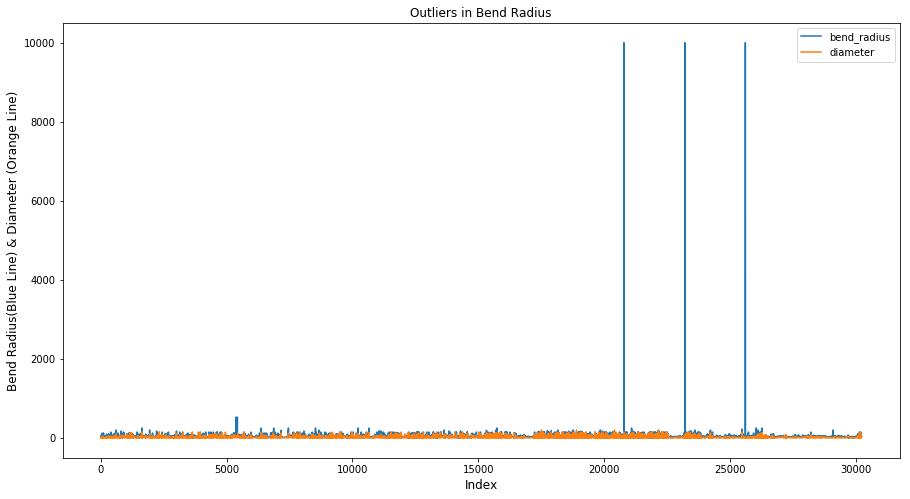

In [27]:
#Check if Bend Radius > tube radius:
prime_77_final[['bend_radius', 'diameter']].plot(kind = 'line', figsize= (15,8))
plt.title('Outliers in Bend Radius', fontsize = 12)
plt.ylabel('Bend Radius(Blue Line) & Diameter (Orange Line)', fontsize = 12)
plt.xlabel('Index', fontsize = 12)

#### Observation:
1. Shows spikes in the Bend Radius values against the tube diameter. 
2. This means, some observations have greater bend radius values resulting in 9999.00 (outlier).   

In [28]:
#Verify if an assembly with zero bend_radius have any bends:
prime_77_final[['tube_assembly_id', 'bend_radius', 'diameter', 'num_bends']][prime_77_final.diameter==203.2]

,tube_assembly_id,bend_radius,diameter,num_bends
17498,TA-11307,0.0,203.2,0
17499,TA-11307,0.0,203.2,0
17500,TA-11307,0.0,203.2,0
17501,TA-11307,0.0,203.2,0
17502,TA-11307,0.0,203.2,0
17503,TA-11310,0.0,203.2,0
18895,TA-13050,0.0,203.2,0
20400,TA-14710,0.0,203.2,0
22147,TA-16763,203.2,203.2,2
22148,TA-16763,203.2,203.2,2


#### Question 4: Is there a design relationship between bend radius and tube diameter? How to treat outliers in bend radius? 

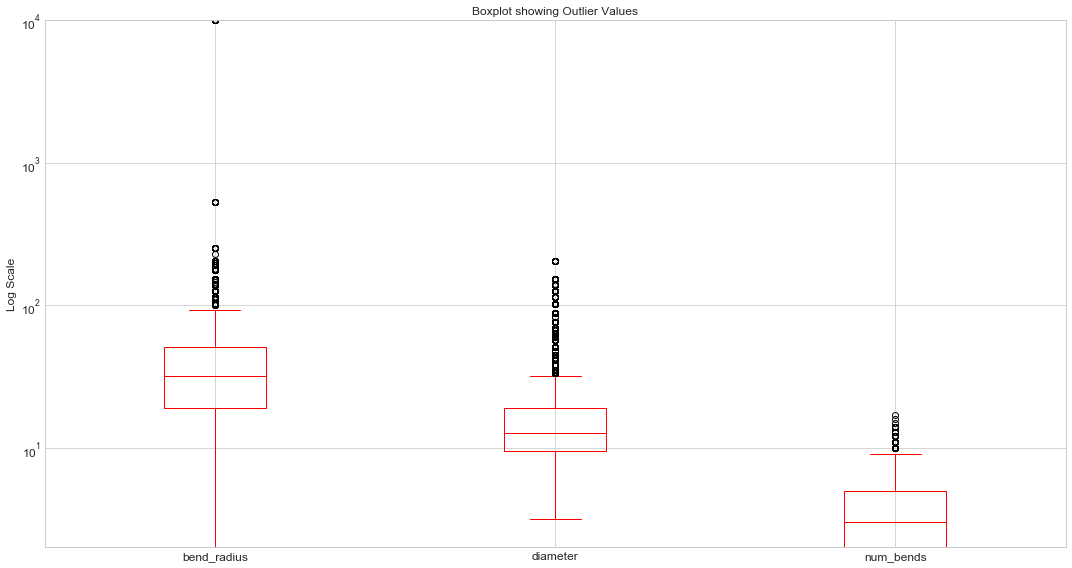

In [29]:
#Explore outliers in the bend radius and Diameter:
sns.set_style('whitegrid')
prime_77_final[['bend_radius', 'diameter', 'num_bends']].plot(kind= 'box', logy= True, figsize= (15, 8), color = 'red', fontsize =12)

#Limit y axis
plt.ylim(0,10000) 

plt.ylabel('Log Scale', fontsize = 12 )
plt.title('Boxplot showing Outlier Values', fontsize = 12)
plt.tight_layout()
plt.show()

#### Observation
1. Value of bend radius is greater than the tube diameter of 203.2. 
2. As per tube design handbook, values of bend radius greater than the maximum tube diameter have been limited to a standard minimum of 7 times the diameter of the tube (203.2 * 7). This will avoid outliers in bend radius as well as maintain tubes at 7D near flatness. 
3. Assemblies with zero bend radius and zero bends shall have no bend processing cost. 

##### <br> Tube Design Handbook Link  https://www.listertube.com/links/tube-bending-design-guide/ 
##### Rule of Thumb: Select a standard tube size
a. For small bend radii keep to one bend radius if possible and use radius of 2 x D.
<br> b. For larger bend radii keep to greater than 7 x D.


#### Treat Outliers in Bend_Radius

In [30]:
#Calculate Inter Quartile Range: 
q1= prime_77_final['bend_radius'].quantile(0.25)
q2 = prime_77_final['bend_radius'].quantile(0.75)
iqr = q2-q1
print('Inter Quartile Range:', iqr)

Inter Quartile Range: 31.749999999999996


In [31]:
#Replace outliers in bend_radius > greater than tube radius with maximum value of possible tube radius:
prime_77_final['bend_radius'][prime_77_final['bend_radius']>203.2*7]=(prime_77_final['bend_radius'][prime_77['bend_radius']>203.2*7]).replace(to_replace=prime_77['bend_radius'][prime_77_final['bend_radius']>203.2*7], value= 203.2*7)

In [32]:
#View Final Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,N,EF-008,EF-008,0,0,0,Yes,Yes


In [33]:
#### Check Bend_Radius, Diameter and Number of Bends in the tube assembly:
prime_77_final[['bend_radius', 'diameter', 'num_bends']].describe()

,bend_radius,diameter,num_bends
count,30213.000000,30213.000000,30213.000000
mean,38.824769,17.223018,3.813061
std,38.650233,18.125973,2.199564
min,0.000000,3.180000,0.000000
25%,19.050000,9.520000,2.000000
50%,31.750000,12.700000,3.000000
75%,50.800000,19.050000,5.000000
max,1422.400000,203.200000,17.000000


Text(0.5,0,'Index')

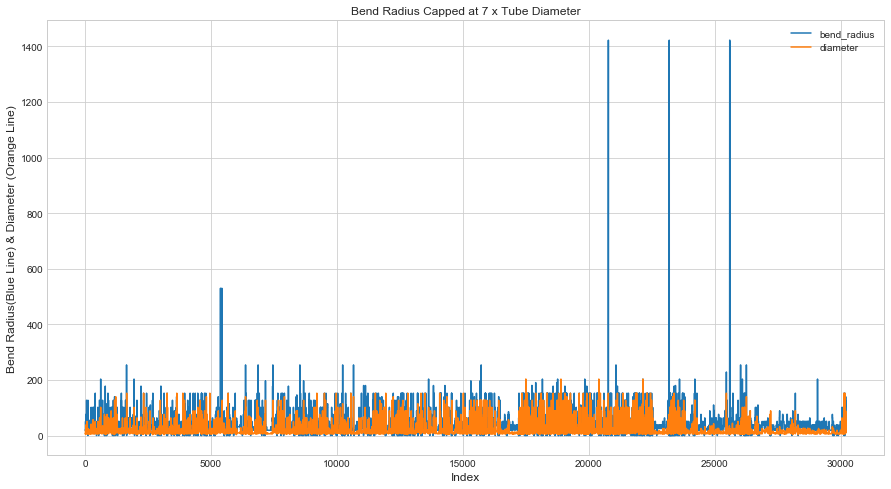

In [34]:
#Visualize if outliers in Bend Radius were capped to half of maximum diameter value 
prime_77_final[['bend_radius', 'diameter']].plot(figsize= (15, 8))
plt.title('Bend Radius Capped at 7 x Tube Diameter', fontsize = 12)
plt.ylabel('Bend Radius(Blue Line) & Diameter (Orange Line)', fontsize = 12)
plt.xlabel('Index', fontsize = 12)

#### Observtaion: 
1. Maximum Bend radius has been capped to a minimum design standard of 7 * Tube Diameter.

#### Order Quanity, Minimum Order Quanity, Annual Usage and Cost: 

#### Question 5: What is the relationship between cost and quantity? 

Text(22.8961,0.5,'Minimum Order Quantity')

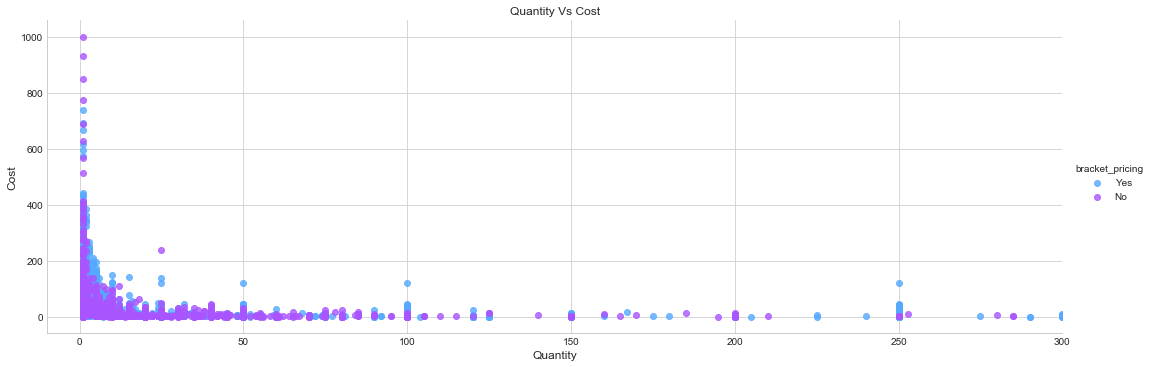

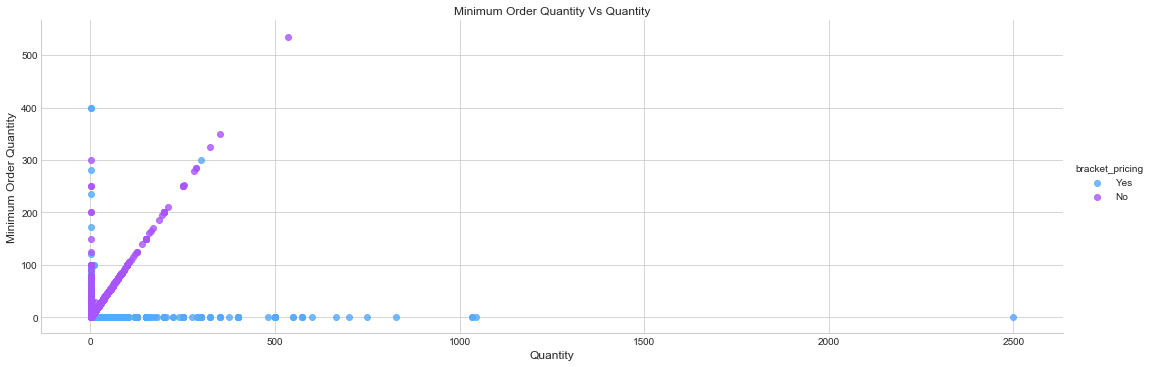

In [35]:
#Order Quantity Vs Cost:

sns.lmplot(x = 'quantity', y = 'cost', data = prime_77_final, hue = 'bracket_pricing', fit_reg=False, palette= 'cool', aspect=3)
plt.xlim(-10, 300)
plt.title('Quantity Vs Cost', fontsize = 12)
plt.xlabel('Quantity', fontsize =12)
plt.ylabel('Cost', fontsize =12)

#Minimum Order Quantity Vs Cost
sns.lmplot(y = 'min_order_quantity', x = 'quantity', data = prime_77_final, hue = 'bracket_pricing', fit_reg=False, palette= 'cool', aspect=3)
plt.title('Minimum Order Quantity Vs Quantity', fontsize = 12)
plt.xlabel('Quantity', fontsize =12)
plt.ylabel('Minimum Order Quantity', fontsize =12)

#### Observation: 
1. Lower the order quantity higher the price.  
2. Observations where quantity is under 150 seems to have both bracket(bulk) and non-bracket (minimum order) pricing.
3. Quantity Miss-Match Error: Along x-axis where quantity =0, we have both bracket and non bracket pricing, which is an issue. Bracket pricing represents bulk pricing which should reflect order volume and not small quantities. 

#### Question 6: Does a supplier offer both bracket (Bulk) and non bracket (minimum order) pricing?
To answer this question we will consider two scenarios: 
1. Supplier who can quote both bulk and minimum order pricing for the same assembly.
2. Case 2. Supplier who provides pricing for both types of assemblies (Bulk) as well as (Minimum Order) exclusively. 

bracket_pricing             No  Yes
tube_assembly_id supplier          
TA-00002         S-0066    NaN  8.0
TA-00004         S-0066    NaN  8.0
TA-00005         S-0066    NaN  8.0
TA-00012         S-0066    NaN  8.0
TA-00013         S-0026    1.0  NaN
Number of Bulk Assemblies:
 4978
Number of Minimum Order Assemblies:
 3930
Result: Supplier does not quote both pricing types per assembly 
 Empty DataFrame
Columns: [No, Yes]
Index: []


Text(0.5,1,'Number of Assemblies Quoted by Pricing Type')

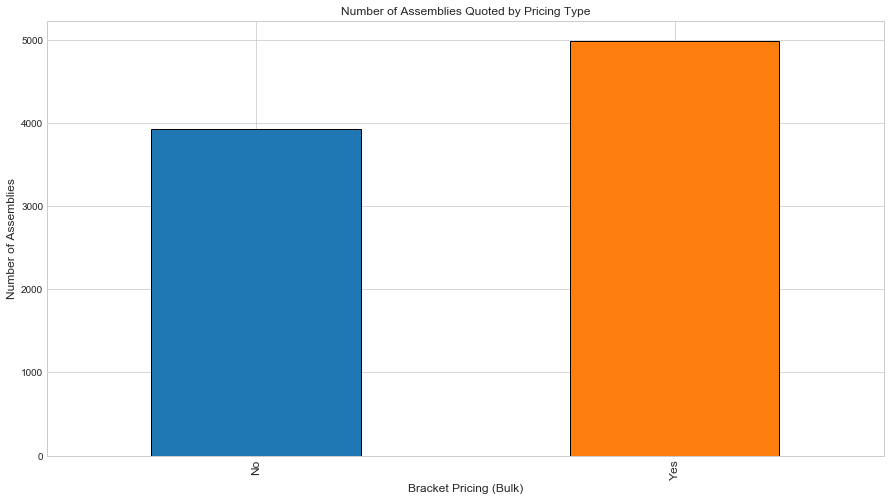

In [36]:
'''
Case 1. Supplier who can quote both bulk and minimum order pricing for the same assembly.

'''
#Groupby tube assembly and supplier on bracket pricing:
prime_77_commmon_supp= prime_77.groupby(['tube_assembly_id','supplier', 'bracket_pricing'])['bracket_pricing'].count()

#Unstack bracket pricing to see distribution of Yes and No:
common=prime_77_commmon_supp.unstack()
print(common.head())
print('Number of Bulk Assemblies:' '\n', common['Yes'].count())
print('Number of Minimum Order Assemblies:' '\n', common['No'].count())

#Verify does supplier provide both types of pricing for an assembly:
print('Result:', 'Supplier does not quote both pricing types per assembly' , '\n',common[((common['No'].notnull()) & (common['Yes'].notnull()))])  

#Count plot of assemblies by Supplier Pricing Type: 
plt.figure(figsize= (15,8))
common.count().plot(kind= 'bar')
plt.xticks(rotation = 90, fontsize=12)
plt.ylabel('Number of Assemblies', fontsize= 12)
plt.xlabel('Bracket Pricing (Bulk)', fontsize= 12)
plt.title('Number of Assemblies Quoted by Pricing Type', fontsize= 12)

bracket_pricing    No  Yes
supplier                  
S-0003            1.0  NaN
S-0004            1.0  NaN
S-0005           23.0  1.0
S-0006            1.0  NaN
S-0007            5.0  NaN
Number of Suppliers who quoted Minimum Order Assemblies 
 50
Number of Suppliers who quoted Bulk Assemblies 
 31
bracket_pricing     No    Yes
supplier                     
S-0005            23.0    1.0
S-0011             4.0    1.0
S-0013           505.0   49.0
S-0014            23.0  116.0
S-0026           470.0  257.0
Number of Suppliers carrying both Bulk and Minimum Order Assemblies: 
 bracket_pricing
No     24
Yes    24
dtype: int64


Text(0.5,1,'Number of Quotes by Suppliers (Bulk Vs Minimum Order)')

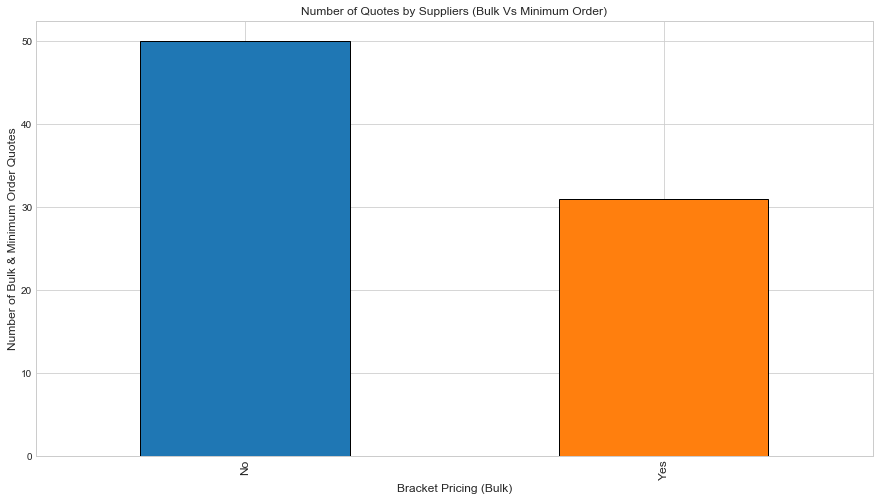

In [37]:

'''
Case 2. Supplier who provides pricing for both types of assemblies (Bulk) as well as (Minimum Order) exclusively. 

'''

#Now let's leave tube assembly out and groupby tube assembly and supplier on bracket pricing:
prime_77_common_supp_wth_tube= prime_77.groupby(['supplier', 'bracket_pricing'])['bracket_pricing'].count()

#Unstack bracket pricing to see distribution of Yes and No:
common_wo_tube=prime_77_common_supp_wth_tube.unstack()
print(common_wo_tube.head())
print('Number of Suppliers who quoted Minimum Order Assemblies', '\n',common_wo_tube['No'].count())
print('Number of Suppliers who quoted Bulk Assemblies', '\n',common_wo_tube['Yes'].count())

#Suppliers who carry both bulk and minimum order tube assemblies:
suppliers_bothprice_assemblies= common_wo_tube[((common_wo_tube['No'].notnull()) & (common_wo_tube['Yes'].notnull()))]  
print(suppliers_bothprice_assemblies.head())
print('Number of Suppliers carrying both Bulk and Minimum Order Assemblies:', '\n', suppliers_bothprice_assemblies.count())

#Count plot of assemblies by Supplier Pricing Type: 
plt.figure(figsize= (15,8))
common_wo_tube.count().plot(kind= 'bar')
plt.xticks(rotation = 90, fontsize=12)
plt.ylabel('Number of Bulk & Minimum Order Quotes', fontsize= 12)
plt.xlabel('Bracket Pricing (Bulk)', fontsize= 12)
plt.title('Number of Quotes by Suppliers (Bulk Vs Minimum Order)', fontsize= 12)

#### Observations: 
Case 1. Supplier who can quote both bulk and minimum order pricing for the same assembly.
1. Suppliers does not provide both types of pricing for the same assembly.
2. If supplier has quoted bracket pricing (bulk), they have not provided non-brackek pricing.
3. Suppliers carry more assortment of bulk assemblies than the minimum order assemblies. 

Case 2. Supplier who provides pricing for both types of assemblies (Bulk) as well as (Minimum Order) exclusively. 
 
1. There are 24 suppliers who deal with both bracket (bulk) and non-bracket(minimum order) assemblies.
2. These suppliers have quoted minimum order pricing more often than the bulk pricing. 
4. This means that transactions with these suppliers were of smaller order quantities and possibly low to no rebates. 

#### Question 7: Is there a variation in supplier pricing with the change in quantity?

Text(0.5,1,'Variation in Supplier Pricing')

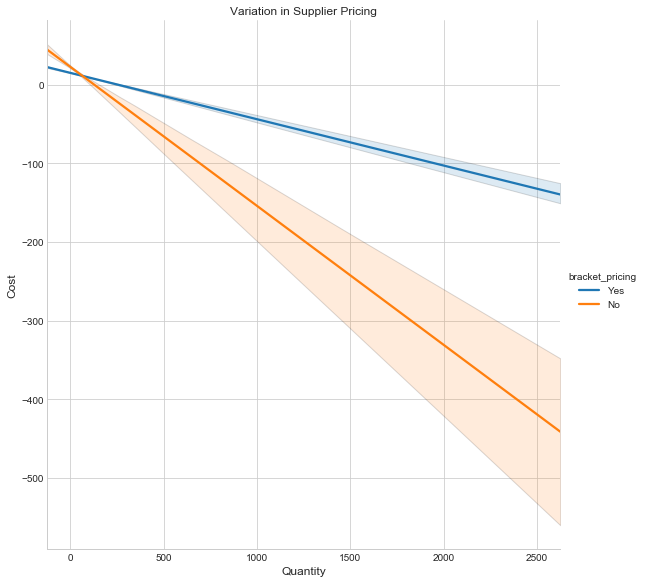

In [38]:
#Groupby final table by tube assembly, bracket pricing, quantity and calculate mean of cost:
df_cost_vary =prime_77_final.groupby(['tube_assembly_id', 'quantity', 'bracket_pricing'])['cost'].mean()

#Reset Index:
df_cost_vary= df_cost_vary.reset_index()

#Plot relationship between cost and quantity: 
sns.lmplot(x= 'quantity', y= 'cost', data = df_cost_vary, hue = 'bracket_pricing', scatter= False, size = 8)
plt.ylabel('Cost', fontsize= 12)
plt.xlabel('Quantity', fontsize= 12)
plt.title('Variation in Supplier Pricing', fontsize= 12)

In [39]:
#View breakdwon of Bracket Pricing per Assembly:
df1 =prime_77_final.groupby(['tube_assembly_id', 'quantity', 'bracket_pricing'])['cost'].apply(list).head(10)
df2= prime_77_final.groupby(['tube_assembly_id', 'quantity', 'bracket_pricing'])['cost'].apply(list).tail(10)
df_priceview = pd.concat([df1,df2])
print('Bracket Pricing:', '\n', df_priceview)

#2.View breakdown of Non_Bracket pricing per Assembly:
print('Non Bracket Pricing:','\n',prime_77_final[prime_77_final['bracket_pricing']=='No'].groupby(['tube_assembly_id','quantity'])['cost'].apply(list).head())

Bracket Pricing: 
 tube_assembly_id  quantity  bracket_pricing
TA-00002          1         Yes                [21.905933019146104]
                  2         Yes                  [12.3412139792904]
                  5         Yes                 [6.601826143565379]
                  10        Yes                   [4.6877695119712]
                  25        Yes                [3.5415611802607296]
                  50        Yes                [3.2244064477000696]
                  100       Yes                  [3.08252143576504]
                  250       Yes                  [2.99905966403855]
TA-00004          1         Yes                  [21.9727024365273]
                  2         Yes                  [12.4079833966715]
TA-21189          2         Yes                [12.163162199607198]
                  5         Yes                  [6.42655642293975]
                  10        Yes                  [4.51249979134557]
                  25        Yes                  [3.3

#### Observation: 
1. Both bracket and non-bracket pricing decreases with the increase in quantity. 
2. Overall, non-Bracket pricing have a steaper rebate than the bracket pricing. 
3. It seems that supplier might be motivated to sell non-bulk assemblies at a higher rebate, if purchased in bulk.

#### Based on previous obervation, further investigate minimum order quantity and quantity miss-match error: 

#### Question 8: How is supplier price quoted? Is it based on per unit basis or minimum order quantity?  
1. Suppliers might have a minimum order quantity requirement even for supplying bulk assemblies.
2. Hence, if a minimum order quantity is given, the unit of measure should reflect <b>cost/each and not cost/unit</b>.
3. This will avoid pricing error.

Quantity Distribution Type 1:
       tube_assembly_id bracket_pricing  min_order_quantity  quantity      cost
12451         TA-07485             Yes                 400         1  3.491484
9410          TA-05449             Yes                 400         1  1.986390
19029         TA-13212              No                 300         1  1.282529
824           TA-00412             Yes                 281         1  1.519004
20355         TA-14629              No                 250         1  9.147410


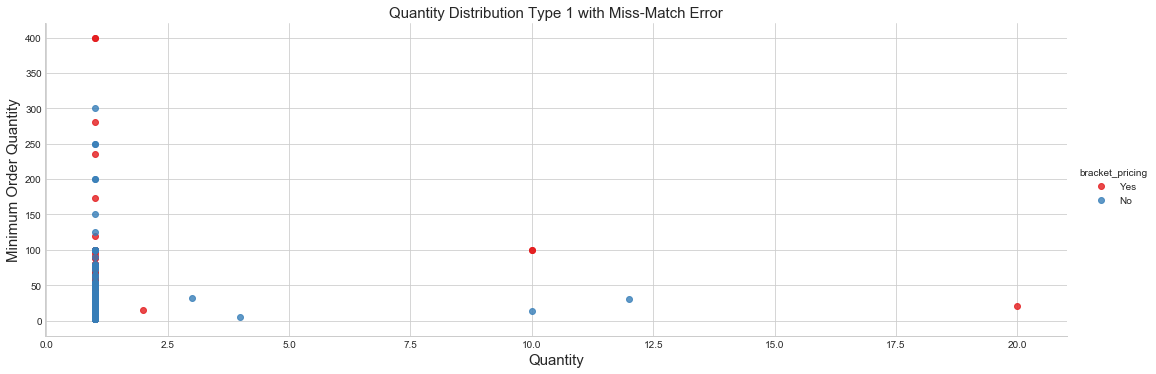

In [40]:
#View table to verify distribution between quantity and minimum order quantity::
prime_77_checkqty=prime_77_final[['tube_assembly_id','bracket_pricing', 'min_order_quantity', 'quantity', 'cost']].sort_values(by='min_order_quantity', ascending=False)

#Check quantity distribution type 1: 
qty_1=prime_77_checkqty[(prime_77_checkqty['quantity']!=prime_77_checkqty['min_order_quantity']) & (prime_77_checkqty['min_order_quantity']!=0)]
print('Quantity Distribution Type 1:''\n', qty_1.head())

#Plot quantity distribution type 1:

sns.lmplot(x = 'quantity', y = 'min_order_quantity', data =qty_1, fit_reg=False, palette='Set1', hue='bracket_pricing', aspect = 3)
plt.xscale('linear')
plt.yscale('linear')
plt.title('Quantity Distribution Type 1 with Miss-Match Error', fontsize= 15)
plt.xlabel('Quantity', fontsize= 15)
plt.ylabel('Minimum Order Quantity',  fontsize= 15)
plt.show()

Quantity Distribution Type 2:
       tube_assembly_id bracket_pricing  min_order_quantity  quantity  \
4477          TA-02482              No                 535       535   
18243         TA-12067              No                 350       350   
20091         TA-14382              No                 325       325   
19902         TA-14134             Yes                 300       300   
13465         TA-08302              No                 285       285   

            cost  
4477    6.357005  
18243   3.099214  
20091   4.999360  
19902  12.140906  
13465   2.108801  


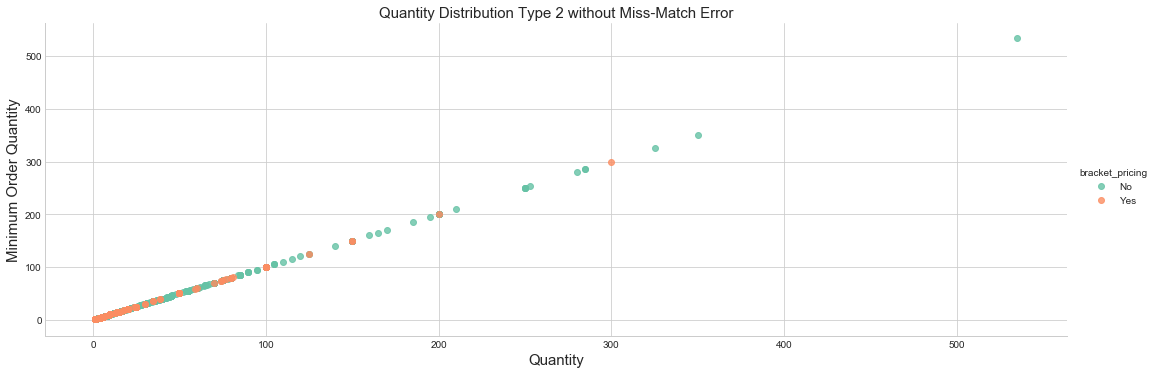

In [41]:
#Check quantity distribution type 2: 
qty_2= prime_77_checkqty[(prime_77_checkqty['quantity'] == prime_77_checkqty['min_order_quantity'])]
print('Quantity Distribution Type 2:''\n', qty_2.head())

#Plot quantity distribution type 2:
sns.lmplot(x = 'quantity', y = 'min_order_quantity', data =qty_2, fit_reg=False, palette='Set2', hue='bracket_pricing', aspect = 3 )
plt.xscale('linear')
plt.yscale('linear')
plt.title('Quantity Distribution Type 2 without Miss-Match Error', fontsize= 15)
plt.xlabel('Quantity', fontsize= 15)
plt.ylabel('Minimum Order Quantity',  fontsize= 15)
plt.show()

#### Observation: 
1. Minimum order quantity is not equal to the quantity for both bracket and non bracket pricing. 
2. This will lead to pricing error because supplier cost is based on minimum order quantity and not per unit cost.
3. Need to fix quantity miss-match error in quantity distribution type 1. 

#### Fixing non-bracket quantity miss-match:

In [42]:
#Select quantity miss-match and replace it with minimum order quantity.
prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
         & (prime_77_final['bracket_pricing'] == 'No')] = (prime_77_final[(prime_77['quantity']!= prime_77_final['min_order_quantity'])& (prime_77_final['min_order_quantity'] !=0)
                                                                & (prime_77_final['bracket_pricing'] == 'No')]).assign(quantity = prime_77_final['min_order_quantity'])

#### Fixing bracket quantity miss-match:

In [43]:
#Bracket Pricing: Select quantity miss-match and replace it with minimum order quantity.
(prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
          & (prime_77_final['bracket_pricing'] == 'Yes')]) = (prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity'] !=0)
                                                                & (prime_77_final['bracket_pricing'] == 'Yes')]).assign(quantity = prime_77_final['min_order_quantity'])                                  

#### Verifying if quantity miss match is fixed:

In [44]:
## See Result: Empty Dataframne where minimum order quantity is not equal to zero as well as quantity. 
print('Result:',prime_77_final[(prime_77_final['quantity']!= prime_77_final['min_order_quantity']) & (prime_77_final['min_order_quantity']!=0)])

Result: Empty DataFrame
Columns: [tube_assembly_id, supplier, quote_date, annual_usage, min_order_quantity, bracket_pricing, quantity, cost, component_id_1, quantity_1, component_id_2, quantity_2, tube_comp_qty, material_id, diameter, wall, length, num_bends, bend_radius, end_a_1x, end_a_2x, end_x_1x, end_x_2x, end_a, end_x, num_boss, num_bracket, other, forming_end_a, forming_end_x]
Index: []

[0 rows x 30 columns]


#### Observation: 
1. As per above, quantity miss-match in quantity distribution type 1 has been fixed.  

#### Adding New Features: 

#### Question 9: Which new features can we add to our predictive model?  
Supplier rebate as an example

#### a) Percentage of Supplier Rebate as quantity increases from 1-2, 1-5, 1-10 ...

In [45]:
#Using lambda expression:
prime_77_final['%supplier_rebate']=prime_77_final.groupby(['tube_assembly_id', 'quantity','cost'][0])['cost'].apply(lambda x: abs((x-x.max())/x.max())* 100)
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,0.000000
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,43.662687
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,69.862840
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,78.600457
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,N,N,EF-008,EF-008,0,0,0,Yes,Yes,83.832868


#### Question 10:  How is the supplier rebate structured?
This depends upon the type of pricing offered by the supplier.

count    26283.000000
mean        56.580359
std         32.741565
min          0.000000
25%         37.943041
50%         71.908497
75%         83.010563
max         98.327120
Name: %supplier_rebate, dtype: float64
count    3930.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: %supplier_rebate, dtype: float64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

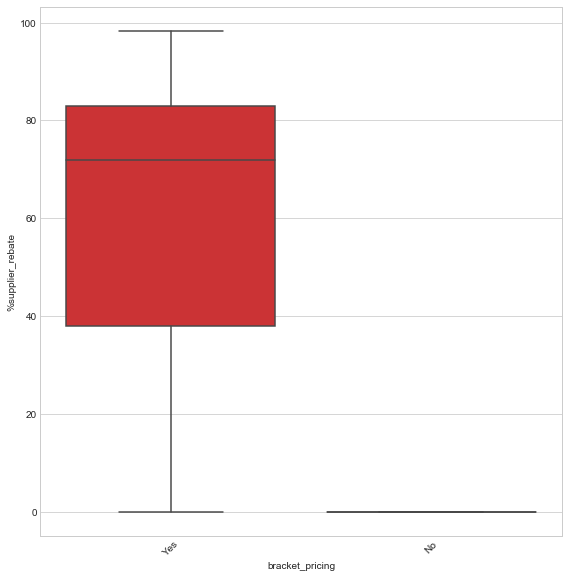

In [46]:
#Breakdown of supplier rebate on bracket pricing:
print(prime_77_final['%supplier_rebate'][prime_77_final['bracket_pricing']=='Yes'].describe())

#Breakdown of supplier rebate on non-bracket pricing:
print(prime_77_final['%supplier_rebate'][prime_77_final['bracket_pricing']=='No'].describe())

#Visualizing %Supplier Rebate pricing structure:
plt.figure(figsize= (8,8))
sns.boxplot(x= 'bracket_pricing', y = '%supplier_rebate', data = prime_77_final, palette='Set1')
plt.tight_layout()
plt.xticks(rotation = 45)

#### Observation:
1. Currently, suppliers are not offering any rebates on non-bracket pricing per assembly.
2. However, as noted earlier, suppliers have shown steap decline in non-bracket pricing as quantity increases.  
3. There might be opportuniy to negotiate volumem rebates on minimum order quantity assemblies. 
4. Most bracket pricing rebates range from 37.9% to 83%

#### b) Extended Cost: Quantity * Cost

In [47]:
#Multiply cost with quantity:
prime_77_final['extended_cost'] = prime_77_final['quantity']*prime_77_final['cost'] 

#### c) Total Cost = Annual usage * Extended Cost/Quantity 

In [48]:
#Add total cost based on annual usage: 
prime_77_final['total_cost'] = (prime_77_final['annual_usage'] * prime_77_final['cost'])/prime_77_final['quantity']

#### d) Tube Surface Area: 2Π(R²-r²)+2Πh(R+r) 

In [49]:
#Tube radius from center to outer surface:
R = prime_77_final['diameter']/2

# Tube radius from cetnter to inner surface: R - 2* wall 
r = R- (2 * prime_77_final['wall'])
 
#Height of the tube is tube length: 
h = prime_77_final['length']

prime_77_final['area'] = (2*3.14 * ((R*R) - (r*r))) + (2 * 3.14 * (R + r))
prime_77_final['area']=prime_77_final['area'].round(decimals=2)
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,end_x,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate,extended_cost,total_cost,area
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,0.000000,21.905933,0.0,74.92
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,43.662687,24.682428,0.0,74.92
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,69.862840,33.009131,0.0,74.92
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,78.600457,46.877695,0.0,74.92
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,EF-008,0,0,0,Yes,Yes,83.832868,88.539030,0.0,74.92


#### Other Observations: 

#### Question 11: 
1. How many unique suppliers are there? 
2. How many differnt models of assemblies we buy?
3. How many times suppliers have quoted the price?  
4. How many unique components do suppliers use to make these tube assemblies? 

Unique About Assemblies:
 tube_assembly_id    8855
quote_date          1781
component_id_1       642
component_id_2       452
supplier              57
end_a                 25
end_x                 24
material_id           17
forming_end_x          2
forming_end_a          2
end_x_2x               2
end_x_1x               2
end_a_2x               2
end_a_1x               2
bracket_pricing        2
dtype: int64


Text(0.5,1,'Unique About Assemblies')

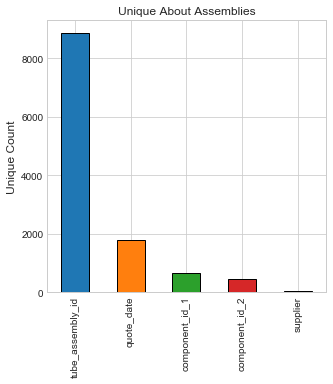

In [50]:
#Unique Categorical values: 
print('Unique About Assemblies:''\n',prime_77_final[prime_77_final.select_dtypes(['object']).columns].nunique().sort_values(ascending= False))
              
plt.figure(figsize= (5,5))
prime_77_final[prime_77_final.select_dtypes(['object']).columns].nunique().sort_values(ascending= False).head(5).plot(kind= 'bar')
plt.ylabel('Unique Count', fontsize= 12)
plt.title('Unique About Assemblies', fontsize= 12)

#### Observation: 
1. Currently, there are 57 suppliers supplying 8,855 types of tube assemblies. 
2. These assemblies can come in multiple combinations of unique components, end types and have two pricing structures.  

#### Question 12: 
1. Which top 5 suppliers carry maximum assortment of tube assemblies? 

Top 5 Suppliers supplying maximum assortment of tube assemblies:
 
 AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5,1,'Top 5 Suppliers by Assortment')

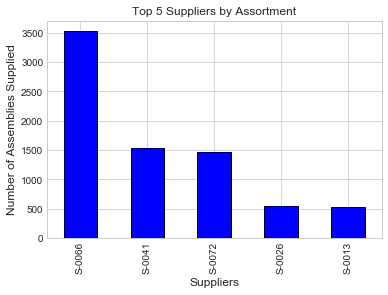

In [51]:
#Number of Tube Assemblies per Supplier: 
print('Top 5 Suppliers supplying maximum assortment of tube assemblies:' '\n','\n',prime_77_final.groupby(['supplier'])['tube_assembly_id'].nunique().sort_values(ascending= False).head().plot(kind='bar', color = 'blue'))
plt.xlabel('Suppliers', fontsize= 12)
plt.ylabel('Number of Assemblies Supplied', fontsize= 12)
plt.title('Top 5 Suppliers by Assortment', fontsize= 12)

### Section B: Building Secondary Table using common Component_Id:

##### a. Preparation:
1. Concatenate all assembly components.
2. Treat null values. 
 
##### b. Explore: 
1. Identify components which are used often in manufacturing. 

In [52]:
#Load and concatenate component tables along rows:
tables = ['components.csv',
          'comp_adaptor.csv',
          'comp_boss.csv', 
          'comp_elbow.csv',
          'comp_float.csv', 
          'comp_hfl.csv', 
          'comp_nut.csv', 
          'comp_other.csv', 
          'comp_sleeve.csv', 
          'comp_straight.csv', 
          'comp_tee.csv', 
          'comp_threaded.csv']

df_comps = [pd.read_csv(table) for table in tables]

#Concatenate Vertically:
df_comps_2 = pd.concat(df_comps, axis='rows')
df_comps_2.head()

,adaptor_angle,base_diameter,base_type,blind_hole,bolt_pattern_long,bolt_pattern_wide,component_id,component_type_id,connection_type_id,connection_type_id_1,...,thread_pitch_3,thread_pitch_4,thread_size,thread_size_1,thread_size_2,thread_size_3,thread_size_4,type,unique_feature,weight
0,NaN,NaN,NaN,NaN,NaN,NaN,9999,OTHER,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,C-0001,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,C-0002,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,C-0003,CP-024,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,C-0004,CP-026,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Treating Null Values in Components Table: 

#### Question 13: 
1. What are some of the ways we can treat and fill missing values? 

In [53]:
#Checking Null Values in the Secondary table
#Rejecting 77% of the Null values:
comps_77=(df_comps_2.isnull().sum()/df_comps_2.shape[0]*100) < 77
comps_77 = df_comps_2.loc[:,comps_77]
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,NaN
1,C-0001,CP-024,SLEEVE,NaN,NaN,NaN,NaN
2,C-0002,CP-024,SLEEVE,NaN,NaN,NaN,NaN
3,C-0003,CP-024,SLEEVE-FLARED,NaN,NaN,NaN,NaN
4,C-0004,CP-026,NUT,NaN,NaN,NaN,NaN


In [54]:
#Identify null values in Components table before treatment:
before = comps_77.isnull().sum()
before

component_id            0
component_type_id    1001
name                 2048
orientation          3049
part_name            3094
unique_feature       3136
weight               2119
dtype: int64

#### Identify Fill Method:  

In [55]:
#1. Check if common component_ids have both null and non-null values: 
comps_77[['part_name','component_id', 'component_type_id', 'name', 'orientation', 'unique_feature', 'weight']][comps_77['component_id']=='C-0001']

,part_name,component_id,component_type_id,name,orientation,unique_feature,weight
1,NaN,C-0001,CP-024,SLEEVE,NaN,NaN,NaN
0,NaN,C-0001,CP-024,NaN,No,No,0.013


In [56]:
#2. Check if common component_ids have both null and non-null values: 
comps_77[['part_name','component_id', 'component_type_id', 'name', 'orientation', 'unique_feature']][comps_77['component_id']=='C-1364']

,part_name,component_id,component_type_id,name,orientation,unique_feature
1364,NaN,C-1364,OTHER,ELBOW-WATER,NaN,NaN
239,ELBOW-WATER,C-1364,NaN,NaN,NaN,NaN


#### Observation:
1. For weight/unique_feature/orientation/part_name: Use Back Fill Method. 
2. For component_type_id/name: Use Forward Fill method.  

In [57]:
#Treat Missing values for weight/unique_feature/orientation/part_name using backfill: 
comps_77[['weight', 'unique_feature', 'orientation', 'part_name']]=comps_77.groupby(['component_id'])['weight', 'unique_feature', 'orientation', 'part_name'].transform(lambda x: x.fillna(method = 'bfill'))

#Treat Description 
comps_77[['component_type_id', 'name']]=comps_77.groupby(['component_id'])['component_type_id', 'name'].transform(lambda x: x.fillna(method = 'ffill'))

In [58]:
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
0,9999,OTHER,OTHER,NaN,NaN,NaN,NaN
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
3,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014
4,C-0004,CP-026,NUT,No,NaN,NaN,0.014


In [59]:
#Drop row where component_id = 9999
comps_77=comps_77.drop(comps_77.index[0])

#View Table: 
comps_77.head()

,component_id,component_type_id,name,orientation,part_name,unique_feature,weight
1,C-0001,CP-024,SLEEVE,No,NaN,No,0.013
2,C-0002,CP-024,SLEEVE,No,NaN,No,0.005
3,C-0003,CP-024,SLEEVE-FLARED,No,NaN,No,0.014
4,C-0004,CP-026,NUT,No,NaN,NaN,0.014
5,C-0005,CP-028,ADAPTER-STR,No,NaN,No,0.206


In [60]:
#Compare null values after treatment:
after= comps_77.isnull().sum()
print('Before Null Treatment:' '\n',before, '\n', 'After Null Treatment:' '\n', after)

Before Null Treatment:
 component_id            0
component_type_id    1001
name                 2048
orientation          3049
part_name            3094
unique_feature       3136
weight               2119
dtype: int64 
 After Null Treatment:
 component_id            0
component_type_id       0
name                    2
orientation          2001
part_name            2082
unique_feature       2172
weight                142
dtype: int64


Text(0,0.5,'Number of Null Values')

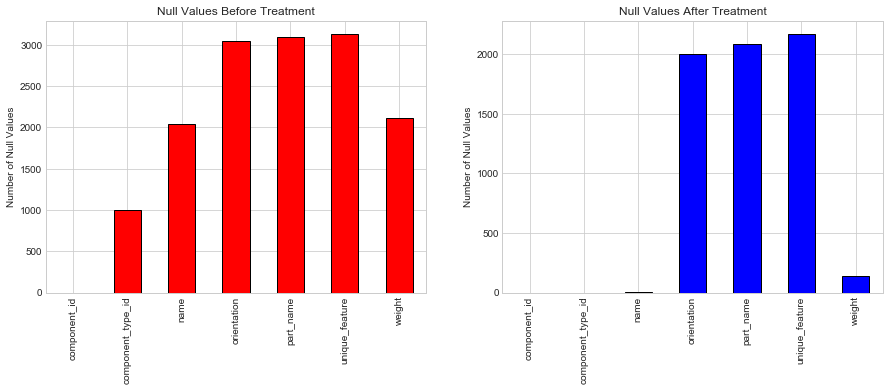

In [61]:
#Plot Null Treatment Comparision: 
plt.subplot(1,2,1)
before.plot(kind= 'bar', color = 'red', figsize=(15,5))
plt.title('Null Values Before Treatment')
plt.ylabel('Number of Null Values')
plt.subplot(1,2,2)
after.plot(kind= 'bar', color = 'blue')
plt.title('Null Values After Treatment')
plt.ylabel('Number of Null Values')

#### Observation: 
1. Null values have reduced after the treatment. 

#### Question 14: Identify which components are used most often in manufacturing these assemblies? 
1. This can help us estimate which items our suppliers might be buying in high volume. 
2. Then work jointly to identify innovative ways to reduce costs or compare supplier's total cost.  

In [62]:
#Check Name Vs Part_Name Shape:
print('Name:', comps_77[comps_77['name'].notnull()].shape, 'Part_name:', comps_77[comps_77['part_name'].notnull()].shape)

#Identify Most used component names: 
print(comps_77['name'].value_counts().head(10))

Name: (4081, 7) Part_name: (2001, 7)
FLANGE             698
BOSS               303
ELBOW              259
PLATE              194
TUBE               182
FLANGE-ONE PIEC    150
ADAPTER            124
ELBOW-HYDRAULIC    114
HEAD-FLANGED       106
CONNECTOR           98
Name: name, dtype: int64


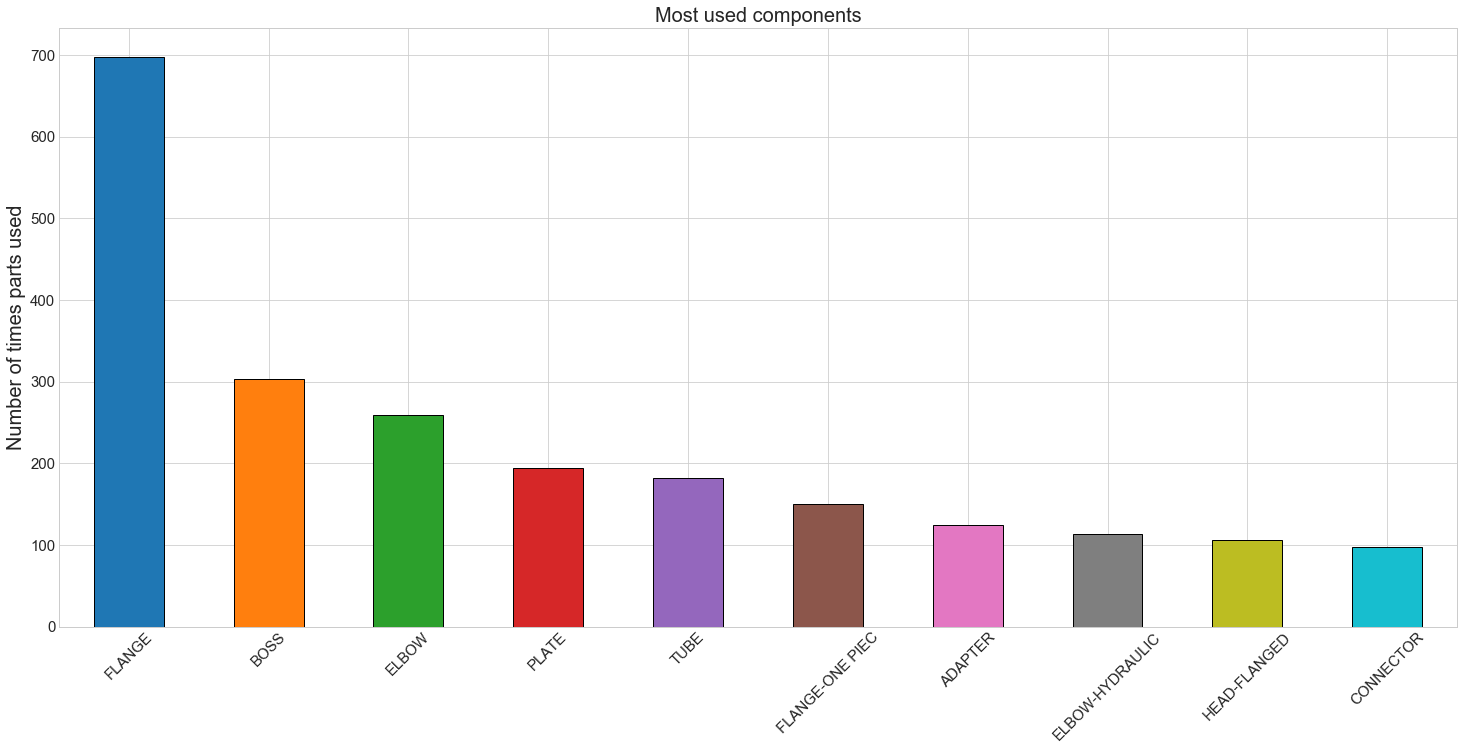

In [63]:
#Visualize top 10 frequently used part names :
plt.figure(figsize = (20, 10))
comps_77['name'].value_counts().head(10).plot(kind = 'bar')
plt.tight_layout()
plt.title('Most used components', fontsize = 20)
plt.xticks(fontsize= 15, rotation =45)
plt.yticks(fontsize = 15)
plt.ylabel('Number of times parts used', fontsize = 20)
plt.show()

#### Observation: 
1. Flanges, boss, elbow etc are most used parts building the assemblies.
2. We should obtain supplier costing on these items to look for cost savings opportunitites. 

### Section C:  Build Final Table Contaning Primary and Secondary Tables: 

##### a. Preparation:
1. Merge primary and secondary tables in to a single table.
2. Look for duplicate values and clean. 
3. Rearrange columns in the final table.

In [64]:
#Merge primary table component_id_1 with secondary table on component_id: 
df_merge1=pd.merge(left = prime_77_final, right = comps_77, left_on= ['component_id_1'], right_on=['component_id'], how ='left')

#Rename merged component_id column to component_id_a:
df_merge1=df_merge1.rename(columns={'component_id': 'component_id_a'})

#View first final table 'df_final2' contaning common components_id_1, forming end_a and forming end_x: 
df_merge1.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,extended_cost,total_cost,area,component_id_a,component_type_id,name,orientation,part_name,unique_feature,weight
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
1,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
2,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
3,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009
4,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,33.009131,0.0,74.92,C-1312,CP-028,NUT-FLARED,No,NaN,No,0.009


In [65]:
#Merge primary table component_id_2 with the secondary table on component_id: 
df_merge2=pd.merge(left = prime_77_final, right = comps_77, left_on= ['component_id_2'], right_on=['component_id'], how ='left')

#Rename merged component_id column to component_id_b
df_merge2=df_merge2.rename(columns={'component_id': 'component_id_b'})

#View first final table 'df_final2' contaning common components_id_1, forming end_a and forming end_x: 
df_merge2.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,extended_cost,total_cost,area,component_id_b,component_type_id,name,orientation,part_name,unique_feature,weight
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,21.905933,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,24.682428,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,33.009131,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,46.877695,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,88.539030,0.0,74.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
#Concatenate df_merge1 and df_merge2 tables: 
final_table = pd.concat([df_merge1, df_merge2], axis = 'rows')
final_table.head()

,%supplier_rebate,annual_usage,area,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,tube_comp_qty,unique_feature,wall,weight
0,0.000000,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
1,0.000000,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
2,43.662687,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
3,43.662687,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009
4,69.862840,0,74.92,19.05,Yes,C-1312,NaN,C-1312,NaN,CP-028,...,2.0,NaN,2013-07-07,S-0066,0.0,TA-00002,2.0,No,0.71,0.009


In [67]:
final_table[final_table['tube_assembly_id']== 'TA-00005'].head()

,%supplier_rebate,annual_usage,area,bend_radius,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,component_type_id,...,quantity_1,quantity_2,quote_date,supplier,total_cost,tube_assembly_id,tube_comp_qty,unique_feature,wall,weight
32,0.000000,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
33,0.000000,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
34,41.798216,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
35,41.798216,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035
36,66.879106,0,362.13,50.8,Yes,C-1624,C-1631,C-1624,NaN,CP-025,...,1.0,1.0,2013-09-01,S-0066,0.0,TA-00005,3.0,NaN,1.24,0.035


In [68]:
#Check for duplicates: 
final_table.drop_duplicates(inplace=True)

In [69]:
final_table.columns

Index(['%supplier_rebate', 'annual_usage', 'area', 'bend_radius',
       'bracket_pricing', 'component_id_1', 'component_id_2', 'component_id_a',
       'component_id_b', 'component_type_id', 'cost', 'diameter', 'end_a',
       'end_a_1x', 'end_a_2x', 'end_x', 'end_x_1x', 'end_x_2x',
       'extended_cost', 'forming_end_a', 'forming_end_x', 'length',
       'material_id', 'min_order_quantity', 'name', 'num_bends', 'num_boss',
       'num_bracket', 'orientation', 'other', 'part_name', 'quantity',
       'quantity_1', 'quantity_2', 'quote_date', 'supplier', 'total_cost',
       'tube_assembly_id', 'tube_comp_qty', 'unique_feature', 'wall',
       'weight'],
      dtype='object')

In [70]:
#Re-arrange column positions inside the table:
final_table= final_table.reindex_axis(labels=['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id','component_type_id',
       'component_id_1','component_id_a', 'quantity_1', 'component_id_2', 'component_id_b', 'quantity_2', 'tube_comp_qty',
       'diameter','wall', 'length', 'num_bends', 'bend_radius', 'area', 'end_a_1x', 'end_a_2x','forming_end_x',
       'end_x_1x', 'end_x_2x', 'end_a', 'forming_end_a', 'end_x', 'num_boss', 'num_bracket',
       'other','name','orientation', 'part_name', 'unique_feature', 'weight','quote_date', 'annual_usage', 'min_order_quantity', 'quantity',
       '%supplier_rebate', 'extended_cost','total_cost','cost'], axis=1)

In [123]:
print('Final Table Shape:',final_table.shape)
final_table.head()

Final Table Shape: (58964, 42)


,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,unique_feature,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
0,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,1,0.000000,21.905933,0.0,21.905933
2,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,2,43.662687,24.682428,0.0,12.341214
4,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,5,69.862840,33.009131,0.0,6.601826
6,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,10,78.600457,46.877695,0.0,4.687770
8,TA-00002,S-0066,Yes,SP-0019,CP-028,C-1312,C-1312,2.0,NaN,NaN,...,No,0.009,2013-07-07,0,0,25,83.832868,88.539030,0.0,3.541561


### Section D: Treat Final Tabel from Section 3 ready for Modelling: 

##### a. Preparation:
1. Convert Data Types
2. Treat null values. 
 
##### b. Explore: 
1. Attributes such as weight of the tube assembly, unique features etc on the assembly cost.   

#### Convert Data Type

In [124]:
#Converting quotation date to date time format:
final_table['quote_date'] = pd.to_datetime(final_table['quote_date'])

#Converting Object columns in the dataframe into Category: 
final_table[final_table.select_dtypes(['object']).columns] = final_table.select_dtypes(['object']).apply(lambda x: x.astype('category'))

#Count of unique categorical values in the merged table:  
unique_cat=final_table[final_table.select_dtypes(['category']).columns].nunique().sort_values(ascending= False)
unique_cat

tube_assembly_id     8855
component_id_1        642
component_id_a        642
component_id_2        452
component_id_b        452
name                  173
part_name             115
supplier               57
component_type_id      26
end_a                  25
end_x                  24
material_id            17
bracket_pricing         2
unique_feature          2
end_a_1x                2
forming_end_x           2
end_x_1x                2
end_x_2x                2
forming_end_a           2
orientation             2
end_a_2x                2
dtype: int64

Text(0.5,1,'Distribution of Yes/No Categories')

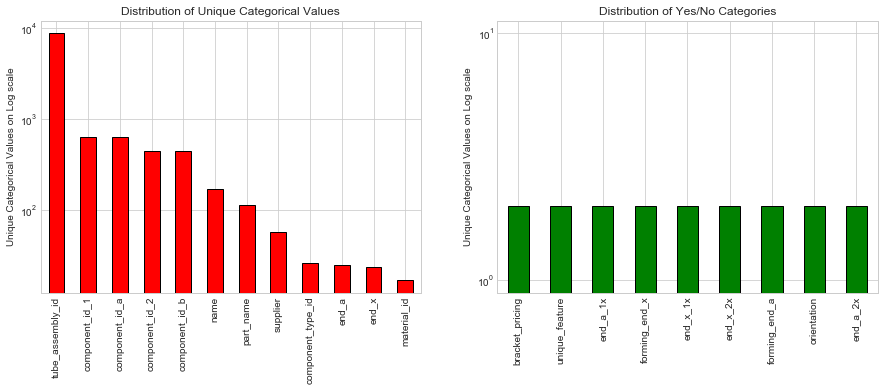

In [125]:
plt.subplot(1,2,1)
unique_cat.head(12).plot(kind = 'bar', figsize = (15,5), color = 'red')
plt.yscale('log')
plt.ylabel('Unique Categorical Values on Log scale')
plt.title('Distribution of Unique Categorical Values')
plt.subplot(1,2,2)
unique_cat.tail(9).plot(kind = 'bar', color = 'green')
plt.yscale('log')
plt.ylabel('Unique Categorical Values on Log scale')
plt.title('Distribution of Yes/No Categories')

#### Observation: 
1. Final table contains two types of categorical values. 
<br>a. Oridinal as represented in red.
<br>b. Nominal as represented in green. 

#### Identify and Treat Remaning Null Values 

In [126]:
#Check null values:
final_table.isnull().sum()

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             457
component_type_id      9129
component_id_1         1462
component_id_a        30213
quantity_1             1462
component_id_2        16796
component_id_b        37880
quantity_2            16796
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x          2063
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a          1357
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                   9129
orientation           10847
part_name             57246
unique_feature        30274
weight                 9238
quote_date                0
annual_usage        

In [127]:
#Removing components with null values
final_table=final_table[final_table['component_id_1'].notnull()]

final_table=final_table[final_table['component_id_2'].notnull()]

#Removing orientation with null values: 
final_table=final_table[final_table['orientation'].notnull()]

#Removing unique features with null values: 
final_table=final_table[final_table['unique_feature'].notnull()]

#Removing forming_end_a null values: 
final_table=final_table[final_table['forming_end_a'].notnull()]

#Removing forming_end_x null values:
final_table=final_table[final_table['forming_end_x'].notnull()]

In [128]:
#Check Null Values:
final_table.isnull().sum()

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             207
component_type_id         0
component_id_1            0
component_id_a        18381
quantity_1                0
component_id_2            0
component_id_b         2714
quantity_2                0
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x             0
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a             0
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                      0
orientation               0
part_name             21095
unique_feature            0
weight                    8
quote_date                0
annual_usage        

#### Treat Null Values in Weight: 

In [129]:
#View Weight Null Values: 
final_table[final_table['weight'].isnull()].head()

,tube_assembly_id,supplier,bracket_pricing,material_id,component_type_id,component_id_1,component_id_a,quantity_1,component_id_2,component_id_b,...,unique_feature,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
16427,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2005-02-23,0,1,1,83.720220,1.482837,0.000000,1.482837
16429,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2014-08-08,64,0,50,0.000000,455.423068,11.658831,9.108461
16431,TA-05245,S-0090,Yes,SP-0035,CP-028,C-0443,C-0443,1.0,C-1486,NaN,...,No,NaN,2014-08-08,64,0,100,19.089798,736.967444,4.716592,7.369674
21918,TA-07237,S-0081,Yes,SP-0028,CP-004,C-0471,C-0471,1.0,C-0634,NaN,...,No,NaN,2013-10-15,1400,1,1,0.000000,3.463664,4849.128937,3.463664
21920,TA-07237,S-0081,Yes,SP-0028,CP-004,C-0471,C-0471,1.0,C-0634,NaN,...,No,NaN,2013-10-10,1400,1,1,0.000000,3.463664,4849.128937,3.463664


In [130]:
# Weite a function to fill null weight with its Median to avoid outliers: 
def impute_weight(series):
    
    """
    impute_weight will calculate median and fillna values in the series with its median. 
    """
    
    return series.fillna(series.median())

final_table['weight'] = final_table['weight'].transform(impute_weight) 

#View null values: 
final_table.isnull().sum()
#Values for material_id, name, part_name will not be in modeeling, hence not treated:  

tube_assembly_id          0
supplier                  0
bracket_pricing           0
material_id             207
component_type_id         0
component_id_1            0
component_id_a        18381
quantity_1                0
component_id_2            0
component_id_b         2714
quantity_2                0
tube_comp_qty             0
diameter                  0
wall                      0
length                    0
num_bends                 0
bend_radius               0
area                      0
end_a_1x                  0
end_a_2x                  0
forming_end_x             0
end_x_1x                  0
end_x_2x                  0
end_a                     0
forming_end_a             0
end_x                     0
num_boss                  0
num_bracket               0
other                     0
name                      0
orientation               0
part_name             21095
unique_feature            0
weight                    0
quote_date                0
annual_usage        

#### Explore Tube Assembly Weight:  

#### Question 15.1:
<b>
1. What is the distribution of tube assemblies by weight? 
2. Which assemblies are heavy and would be considered an outlier? </b> 

In [131]:
#Review Statistics: 
final_table.weight.describe()

count    21095.000000
mean         0.065741
std          0.307265
min          0.001000
25%          0.006000
50%          0.012000
75%          0.026000
max          9.805000
Name: weight, dtype: float64

#### Assemblies > 75% of weight percentile:

In [132]:
#Select assemblies with weight greater than 0.026:
assembly_outliers_wt= final_table[['tube_assembly_id', 'weight']][final_table['weight']>0.026]

#Sort weight in descending order. Limit to top 20 most heavy assemblies.
assembly_outliers_wt=assembly_outliers_wt.sort_values(by = 'weight', ascending = False).head(20)

In [133]:
#TView top 5 most heavy assemblies
assembly_outliers_wt.head()

,tube_assembly_id,weight
33511,TA-13600,9.805
5450,TA-01619,9.805
31234,TA-11909,9.500
31236,TA-11909,9.500
31240,TA-11909,9.500


Text(0,0.5,'Weight')

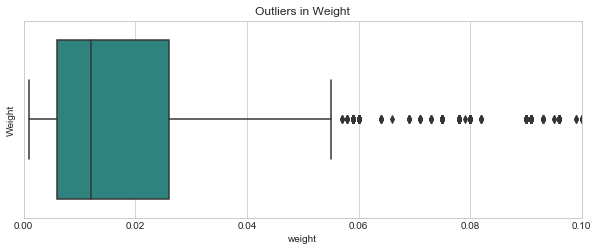

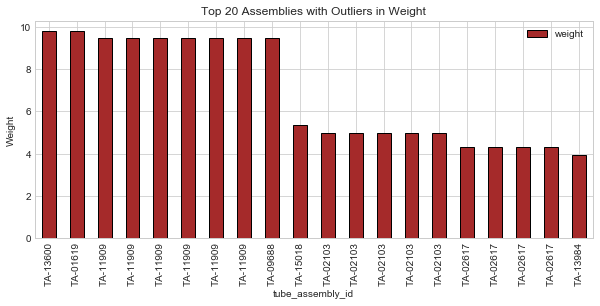

In [134]:
# Visualizing Weight Outliers: 
plt.figure(figsize= (10,8))
sns.set_style('whitegrid')
plt.subplot(2,1,1)
sns.boxplot(x= 'weight', data = final_table, palette='viridis')
plt.xlim(0,0.1)
plt.title('Outliers in Weight')
plt.ylabel('Weight')

#Visualize top 20 most heavy assemblies: 
assembly_outliers_wt.plot(kind = 'bar', x = 'tube_assembly_id', y = 'weight', figsize=(10,4), color = 'brown')
plt.title('Top 20 Assemblies with Outliers in Weight')
plt.ylabel('Weight')

#### Visualizing Weigth Distribution below and above 75 weight Percentile:

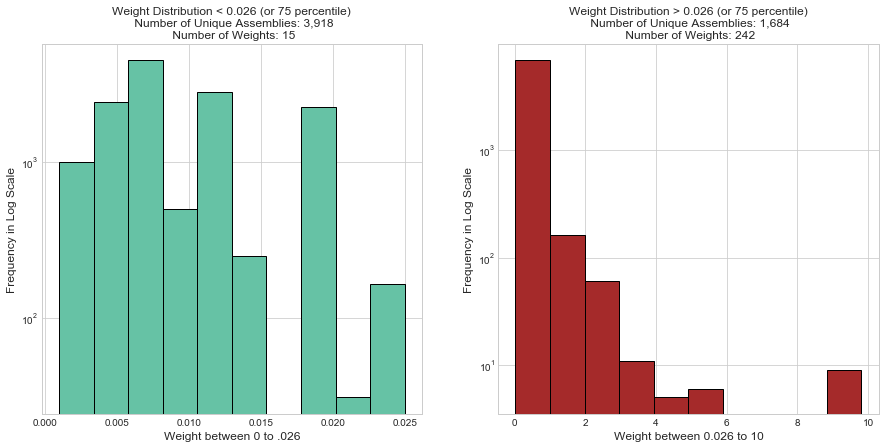

In [135]:
# Count weight values > 75% quartile range:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
final_table['weight'][final_table['weight'] < 0.026].plot(kind='hist', sharey= True, colormap= 'Set2')
plt.title('Weight Distribution < 0.026 (or 75 percentile)\n Number of Unique Assemblies: 3,918\n Number of Weights: 15', fontsize = 12)
plt.xlabel('Weight between 0 to .026', fontsize = 12)
plt.ylabel('Frequency in Log Scale', fontsize = 12)
plt.yscale('log')
#print(final_table[['tube_assembly_id','weight']][final_table['weight'] < 0.026].nunique())

# Count weight values < 75% quartile range
plt.subplot(2,2,2)
final_table['weight'][final_table['weight'] >= 0.026].plot(kind='hist', color= 'brown', sharey = False)
plt.title('Weight Distribution > 0.026 (or 75 percentile)\n Number of Unique Assemblies: 1,684\n Number of Weights: 242', fontsize = 12)
plt.xlabel('Weight between 0.026 to 10', fontsize = 12)
plt.ylabel('Frequency in Log Scale', fontsize = 12)
plt.yscale('log')
#print(final_table[['tube_assembly_id','weight']][final_table['weight'] > 0.026].nunique())

#### Observation: 
1. From above, we observe two distributions in Assemblies by weight. 
2. Heavier assmeblies have more variation in weights but fewer order transaction. 
3. Lighter assemblies have fewer variation in weights but are purchased more often. 

#### Question 15.2: Based on above weight distribution, which parts are most oftently used in building these assemblies?

In [136]:
# Most Commonly Used Parts: 
print('Weight Range between 0 & 2:','\n',final_table['name'][(final_table['weight'] >=0) & (final_table['weight'] <=2)].value_counts().head())
print('Weight Range between 2 & 4:','\n',final_table['name'][(final_table['weight'] >=2) & (final_table['weight'] <=4)].value_counts().head())
print('Weight Range between 4 & 8:','\n',final_table['name'][(final_table['weight'] >4) & (final_table['weight'] <=8)].value_counts().head())
print('Weight Range between 8 & 14:','\n',final_table['name'][(final_table['weight'] >8) & (final_table['weight'] <=14)].value_counts().head())

Weight Range between 0 & 2: 
 SLEEVE-ORFS       13851
SLEEVE-FLARED      1767
SLEEVE             1493
CONNECTOR-SEAL      957
SLEEVE-FITTING      455
Name: name, dtype: int64
Weight Range between 2 & 4: 
 FLANGE              25
FLANGE-ONE PIEC     24
FLANGE-ONE PIECE    15
ELBOW                2
BLOCK                1
Name: name, dtype: int64
Weight Range between 4 & 8: 
 ELBOW-HYDRAULIC     5
FLANGE              4
BLOCK               1
WASHER-FUEL LIN     0
COUPLING (1"BSP)    0
Name: name, dtype: int64
Weight Range between 8 & 14: 
 ELBOW-HYDRAULIC    7
FLANGE             2
WASHER-FUEL LIN    0
COUPLET-WELD       0
ELB                0
Name: name, dtype: int64


Text(0,0.5,'Number of Times Part Used')

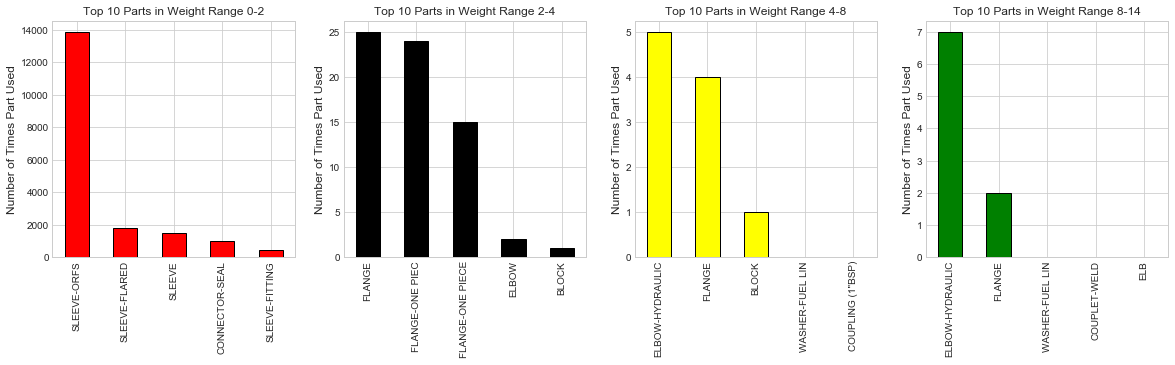

In [137]:
#Visualize top 10 most commonly used components parts in the assembly:
plt.figure(figsize=(20, 20))
plt.subplot(4,4,1)
final_table['name'][(final_table['weight'] >=0) & (final_table['weight'] <=2)].value_counts().head(5).plot(kind = 'bar', color='red')
plt.title('Top 10 Parts in Weight Range 0-2', fontsize =12)
plt.ylabel('Number of Times Part Used', fontsize =12)

plt.subplot(4,4,2)
final_table['name'][(final_table['weight'] >=2) & (final_table['weight'] <=4)].value_counts().head(5).plot(kind = 'bar', color= 'black')
plt.title('Top 10 Parts in Weight Range 2-4', fontsize =12)
plt.ylabel('Number of Times Part Used', fontsize =12)

plt.subplot(4,4,3)
final_table['name'][(final_table['weight'] >=4) & (final_table['weight'] <=8)].value_counts().head(5).plot(kind = 'bar', color= 'yellow')
plt.title('Top 10 Parts in Weight Range 4-8', fontsize =12)
plt.ylabel('Number of Times Part Used', fontsize =12)

plt.subplot(4,4,4)
final_table['name'][(final_table['weight'] >=8) & (final_table['weight'] <=14)].value_counts().head(5).plot(kind = 'bar', color = 'green')
plt.title('Top 10 Parts in Weight Range 8-14', fontsize =12)
plt.ylabel('Number of Times Part Used', fontsize =12)

#### Observation: 
1. Plot above shows, distribution of top 10 parts that are used in the assemblies by weight
2. Example: Weight range between 0-2, assembly uses Sleeve-ORFS most.
3. Heavier assemblies should cost higher compared to lighter assemblies, let's us find out cost dependencies.  

#### Relationship Between Cost and Assembly Specifications:

#### Question 16 a):  How does the cost of assembly vary by assembly specifications and order quantity?

We will use various plots to understand linear relationship between cost and assembly specifications such as weight, diameter, length of an assembly etc. 

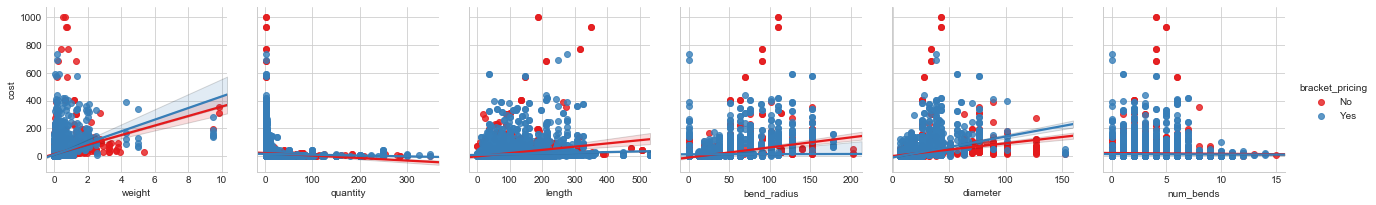

In [2554]:
# Impact of assembly specifications on Cost as a result of Bracket Pricing:
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='bracket_pricing', size = 3, palette='Set1', kind= 'reg')

#### Observation: 
1. Cost increases with increase in weight/length/bend_radius/diameter. 
2. Cost decreases with increase in order quantity. 
3. Heavier and bigger diameter assemblies when purchased in bulk result in higher cost increase. 
4. Cost is not effected by the increase in number of bends in the tube.

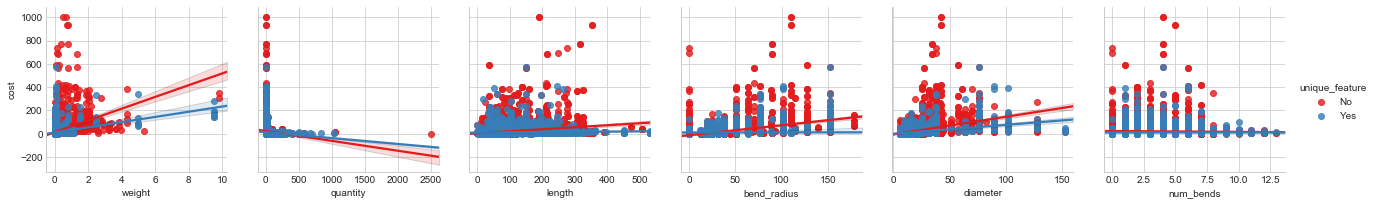

In [2555]:
#Impact of assembly specifications on Cost as a result of Unique Features:
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='unique_feature', size = 3, palette='Set1', kind= 'reg')

#### Observation: 
1. Assemblies with Unique features have lower cost increase compared to non-unique. May be demand for unique features is still less.
2. Cost of having unique features is not impcated by increase in length, bend radius and number of bends in the tube assembly. 

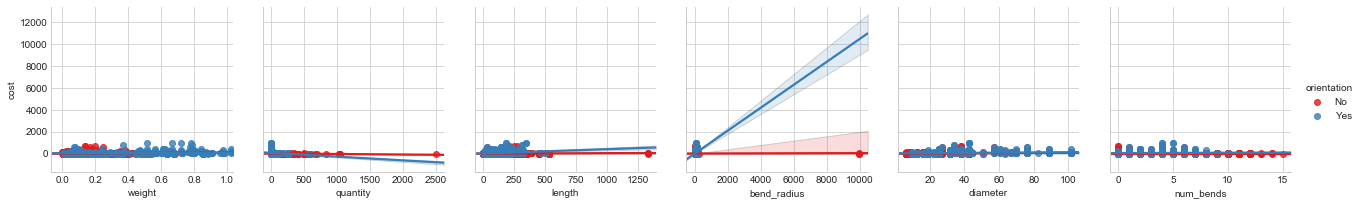

In [2556]:
#Impact of assembly specifications on Cost as a result of Orientation: 
sns.pairplot(final_table, x_vars=['weight', 'quantity', 'length', 'bend_radius', 'diameter', 'num_bends'] , y_vars='cost', hue='orientation', size = 3, palette='Set1', kind= 'reg')

#### Observation
1. Assemblies with orientation have steap cost decrease when purchased in bulk.
2. Assemblies which are oriented and have Longer length and higher bend radius are more costly. 
3. Orientation has negligible impact on assemblies weight and tube diameter. 

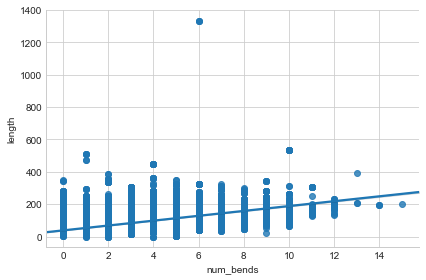

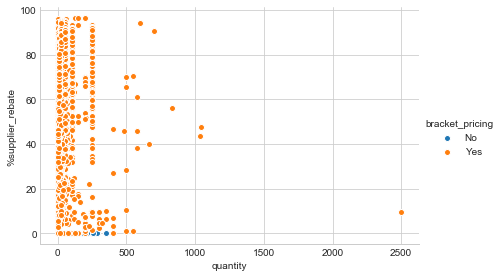

In [2557]:
#Length Vs Number of Bends:
sns.pairplot(final_table, x_vars='num_bends', y_vars='length',size = 4, kind = 'reg', aspect = 1.5)
#final_table[['length', 'num_bends']].plot(kind= 'scatter', x = 'num_bends', y = 'length')
#Supplier Rebate Vs Quantity: 

sns.pairplot(y_vars='%supplier_rebate', x_vars='quantity', data = final_table, hue = 'bracket_pricing', size = 4, aspect = 1.5)

#### Observation: 
1. Assemblies which are longer in length have more bends.
2. Suppliers do not offer rebate on non-bracket priced assemblies. 

### Statistical Measure.
Understanding Distribution of Assembly Parameters: (Mean, Standard Deviation, Hypothesis Testing)

#### Question 16 b): Are bulk assemblies different from non-bulk assemblies? Is there a difference in costs, weight and ordering pattern of the assemblies? 
Our objective here is to understand the difference in bulk vs non_bulk assemblies using statistical measure. 
We will use two-sided t-test to calculate test statistics and see if the p-value of any of the parameters accept or reject null hypothesis. i.e if p-value is < 0.05 we will reject null otherwise proceed with the alternate hypothesis.  

#### Test Hypothesis: 
1. <b>Null:</b> Bulk and non bulk assemblies have same parameters. There is no difference in weight, cost and quantity patterns.

2. <b>Alternate:</b> Non_bulk assemblies parameters differ from bulk assemblies. There is difference in weight, cost and quantity patterns. 

In [403]:
#Bulk Assemblies: 
bulk = final_table[final_table['bracket_pricing']=='Yes'][['weight','annual_usage','min_order_quantity','quantity','%supplier_rebate','extended_cost','total_cost','cost']]

#Mean and Standard Deviation: 
bulk_mean, bulk_std = np.mean(bulk), np.std(bulk)
print(f"Mean of Bulk Assembly Parameters is: \n {bulk_mean} \n Standard Deviation in Bulk Assembly Parameters is: \n{bulk_std}")

#Number of Bulk Samples: 
n_bulk=bulk.shape[0]
print(f"Number of Bulk Samples: \n {n_bulk}")

#Non_Bulk Assemblies: 
#Bulk Assemblies: 
non_bulk = final_table[final_table['bracket_pricing']=='No'][['weight','annual_usage','min_order_quantity','quantity','%supplier_rebate','extended_cost','total_cost','cost']]

#Mean and Standard Deviation: 
non_bulk_mean, non_bulk_std = np.mean(non_bulk), np.std(non_bulk)
print(f"Mean of Non Bulk Assembly Parameters is: \n {non_bulk_mean} \n Standard Deviation in Non Bulk Assembly Parameters is: \n{non_bulk_std}")

#Number of Non Bulk Samples: 
n_non_bulk=non_bulk.shape[0]
print(f"Number of Non Bulk Samples: \n {n_non_bulk}")

Mean of Bulk Assembly Parameters is: 
 weight                  0.054622
annual_usage           59.489505
min_order_quantity      0.543823
quantity               41.366715
%supplier_rebate       55.073459
extended_cost         223.692196
total_cost            195.896757
cost                   13.449436
dtype: float64 
 Standard Deviation in Bulk Assembly Parameters is: 
weight                   0.252856
annual_usage          1326.071062
min_order_quantity       6.915421
quantity                74.400459
%supplier_rebate        32.400019
extended_cost          456.922504
total_cost            5956.413610
cost                    26.982804
dtype: float64
Number of Bulk Samples: 
 18723
Mean of Non Bulk Assembly Parameters is: 
 weight                   0.153503
annual_usage           684.503794
min_order_quantity      13.470911
quantity                13.470911
%supplier_rebate         0.000000
extended_cost          114.528630
total_cost            2016.840727
cost                    19.8

#### Two-Sided t-distribution Test:

In [615]:
#Apply function:
t_test=stats.ttest_ind_from_stats(mean1=bulk_mean, std1= bulk_std, nobs1=n_bulk,mean2= non_bulk_mean, std2= non_bulk_std, nobs2=n_non_bulk, equal_var=True)
#pd.DataFrame(t_test)
t_statistics, p_value= pd.DataFrame(list(zip(bulk.columns, t_test[0])), columns = ['parameters', 't-statistics']),pd.DataFrame(list(zip(bulk.columns,t_test[1])), columns=['parameters', 'p_value'])

result=pd.concat([t_statistics, p_value['p_value']], axis='columns')
print(f"Result of 2-Sided T-Statisics: \n{result.set_index('parameters')}")

Result of 2-Sided T-Statisics: 
                    t-statistics       p_value
parameters                                    
weight                -14.843691  1.360478e-49
annual_usage          -15.864254  2.373634e-56
min_order_quantity    -50.218847  0.000000e+00
quantity               18.082729  1.539973e-72
%supplier_rebate       82.783817  0.000000e+00
extended_cost          11.419592  4.092552e-30
total_cost            -11.578067  6.601705e-31
cost                   -8.984690  2.807771e-19


#### Observation: 
1. Since, p-value for assembly parameters is low (i.e <0.05), null is rejected.
2. Non-bulk assemblies differ from bulk assemblies in terms of weight, costs and quantity procured. 
3. If we collected more samples of bulk and non bulk assemblies, we would be able to identify deviation from the above business trend and investigate reasons for procuring bulk assemblies on a minimum order basis. 

#### Bootstrap Sampling:
We will simulate mean difference between observed and permuted samples of bulk and non-bulk assemblies.
For simplicity, we will calculate mean of all parameters such as weight, quantity, costs and evaluate it's p-value to see if it is less than 0.05 or greater.

1. <b>Null: </b> No change in Business Trend. Bulk assembly parameters differ from non-bulk assemblies as per above. Business will continue to buy bulk assemblies in bulk.
2. <b>Alternate: </b> Business Trend has changed. Bulk and non bulk assemblies share some common parameters. Business will buy bulk assemblies as non-bulk (i.e mimimum order basis) 

In [623]:
#Observed Mean of all parameters:
observed_mean_individual = np.mean(bulk)- np.mean(non_bulk)
print(observed_mean_individual)
mean_observed_all = np.mean(observed_mean_individual)
print('Mean of Observed Mean Difference: ', mean_observed_all)

weight                  -0.098881
annual_usage          -625.014289
min_order_quantity     -12.927088
quantity                27.895804
%supplier_rebate        55.073459
extended_cost          109.163566
total_cost           -1820.943970
cost                    -6.431107
dtype: float64
Mean of Observed Mean Difference:  -284.16031303212037


In [498]:
#Permuted Sampling of bulk and non bulk assemblies:
#Let's simulate to see if trend would continue or not?

seed(123)

#Sampling Size: 
n_sample = 1000

#Generate Permutation Samples of combined Data for performing Null Hypothesis Testing:  
def permuted_samples(data1, data2):
    #Combined Data set: 
    combined = np.concatenate((data1, data2))
    
    #Draw permutation sample:
    combined_permuted = np.random.permutation(combined)

    permuted_sample_1 = combined_permuted[:len(data1)]
    permuted_sample_2 = combined_permuted[len(data2):]
    return permuted_sample_1, permuted_sample_2

#Mean Difference permuted Bulk and Non_bulk Assemblies:
mean_diff_permuted = np.empty(n_sample)

for i in range(n_sample):
    permuted_bulk , permuted_non_bulk = permuted_samples(bulk,non_bulk)
    mean_diff_permuted[i] = np.mean(permuted_bulk)-np.mean(permuted_non_bulk)

P-Value: 1.0
Confidence Interval of Mean of Permuted Mean Difference at 95% level: [-8.1043588   7.93273403]


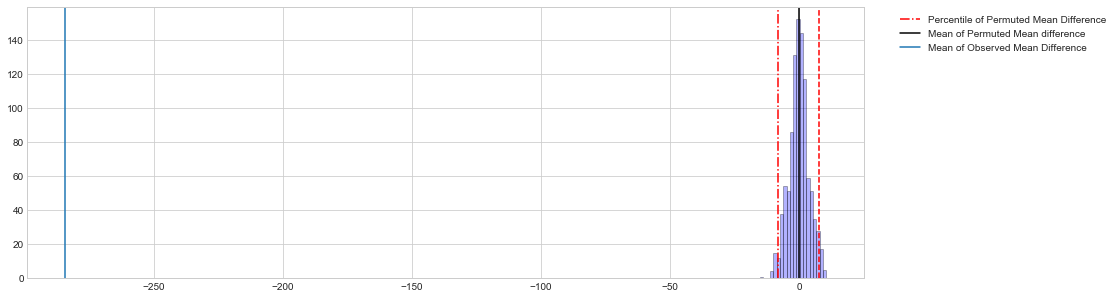

In [631]:
#Calculate P-value: 
p_value = np.sum(mean_diff_permuted >=mean_observed_all)/len(mean_diff_permuted)
print('P-Value:', p_value)

#Calculate Confidence Interval: 
conf_mean_diff_permuted = np.percentile(mean_diff_permuted, [2.3,97.5])
print('Confidence Interval of Mean of Permuted Mean Difference at 95% level:', conf_mean_diff_permuted)

#Plot Distribution of Permuted Mean Difference Vs Mean of Observed Mean Difference: 
_= plt.figure(figsize= (15,5))
_ = plt.hist(mean_diff_permuted, bins = 20, color = 'blue', alpha = 0.3)
_ = plt.axvline(conf_mean_diff_permuted[0], color = 'red', linestyle="-.", label = 'Percentile of Permuted Mean Difference')
_ = plt.axvline(conf_mean_diff_permuted[1], color = 'red', linestyle="--")
_ = plt.axvline(np.mean(mean_diff_permuted), color = 'black', label= 'Mean of Permuted Mean difference')
_ = plt.axvline(mean_observed_all, label = 'Mean of Observed Mean Difference')
_ = plt.legend(loc = 'best', bbox_to_anchor= (1.3,1))

#### Observation: 
1. High p_value value means that null hypothesis exists, even if we took 1000 samples to run the simulation.
2. Bulk assembly parameters will be different from the non-bulk assembly parameters, unless there is a signficant shift in the observed mean difference. 
3. Significant shift in the observed mean would mean that the bulk assembly parameters such as weight, costs and quantity have changed resuting in bulk assemblies being sourced as non-bulk (minimum order basis), which can be tracked and compared with the collected data. 
4. Example: When mean of observed mean difference goes beyond from -284 to upper sample range of 7.93, p-value becomes lower than 0.05, showing discontinuation in the business trend. 

#### Empirical Cummulative Distribution Function: 
#### Question 16c) Is there a significant variance in bulk and non bulk extended cost (i.e cost x quantity)?  

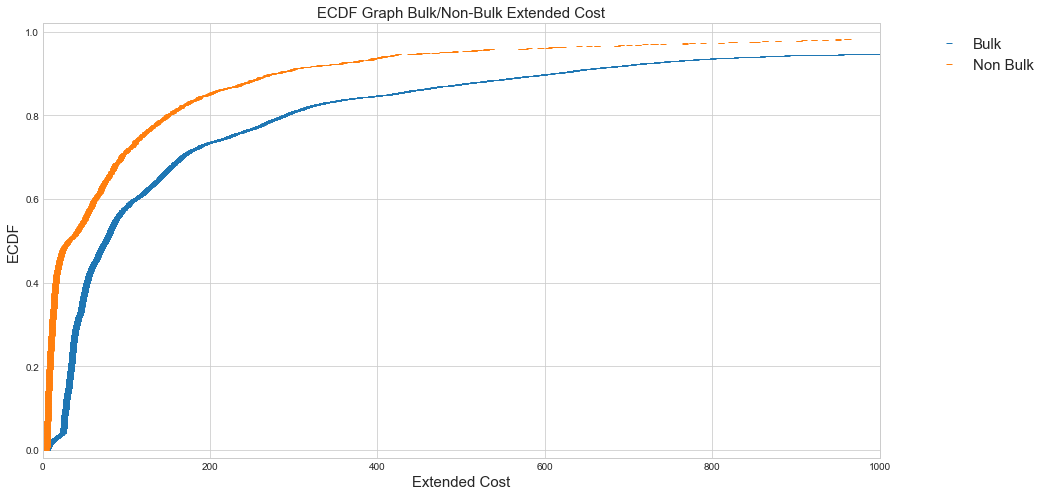

In [612]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

x_bulk, y_bulk = ecdf(bulk['extended_cost'])
x_non_bulk,y_non_bulk = ecdf(non_bulk['extended_cost'])

#Plot ECDF:
_ = plt.figure(figsize = (15,8))
_ = plt.plot(x_bulk, y_bulk, marker= True, linestyle= 'none', label = 'Bulk')
_ = plt.plot(x_non_bulk,y_non_bulk, marker= True, linestyle= 'none', label = 'Non Bulk')
_ = plt.margins(0.02)
_ =plt.xlim(0,1000)
_ = plt.legend(loc = 'upper right', bbox_to_anchor = (1.2, 1), fontsize = 15)
_ = plt.xlabel('Extended Cost', fontsize = 15)
_ = plt.ylabel('ECDF', fontsize = 15)
_ = plt.title('ECDF Graph Bulk/Non-Bulk Extended Cost',  fontsize = 15)


#### Observation: 
1. ECDF graph shows that bulk and non bulk assemblies have significant variance in Extended Cost (Cost * Quantity) . 
2. Bulk extended cost is lower than non-bulk.

#### Check for Multicolinearity: 

#### Question 17:  Are there any assembly specifications dependent on each other? 

Goal is to eliminate input features that are dependent on each other so as to eliminate bias 

#### Plotting Heat Map to find Correlated Variables:  

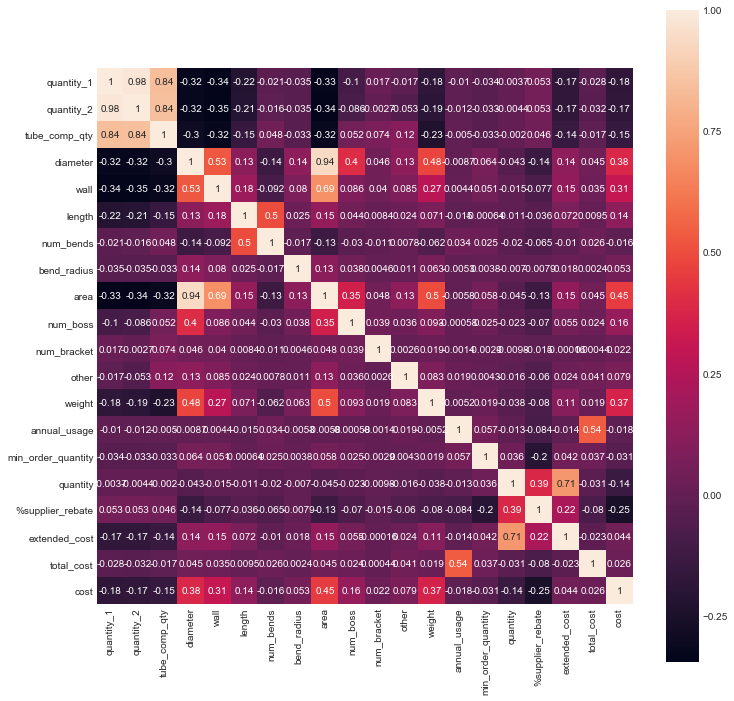

In [2558]:
#Plot heatmap to see correlation between variables: 
plt.figure(figsize=(12,12))
sns.heatmap(final_table.corr(), annot= True, square=True)

#### Observation: 
1. From the heat map above, attributes which were used to build new fetures are co-related.
2. Example: Area and tube_comp_qty is co-related to diameter and component quantity_1, quantity_2 respectively. 

#### Converting Categorical Lables Using Label Encoder:  

#### Question 18:
<b>
1. How should we convert our categorical values in the predictive model?
2. Which categorical encoder should we use to avoid curse of dimensionality?

#### a) Model A using Label Encoder and One-Hot Encoder: 

In [2567]:
#Import Label Encoder:

from sklearn.preprocessing import LabelEncoder

#Initiate Label Encoder:
le = LabelEncoder()

In [2568]:
#Dropping Description Columns: 
final_table_dr= final_table.drop(['end_a', 'end_x', 'component_type_id', 'name', 'part_name'], axis = 1)

#Selecting Categorical Columns for label conversion 
print(final_table_dr.select_dtypes('category').columns)
col = final_table_dr[['supplier', 'bracket_pricing', 'component_id_1', 'component_id_2',
       'component_id_a', 'component_id_b','material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'forming_end_a', 'forming_end_x', 'orientation',
       'unique_feature']]

#Applying one-hot encoder to convert categorical values from text to integers:  
final_table_dummy =pd.get_dummies(data = col , drop_first=True)
print(final_table_dummy.shape)


Index(['tube_assembly_id', 'supplier', 'bracket_pricing', 'material_id',
       'component_id_1', 'component_id_a', 'component_id_2', 'component_id_b',
       'end_a_1x', 'end_a_2x', 'forming_end_x', 'end_x_1x', 'end_x_2x',
       'forming_end_a', 'orientation', 'unique_feature'],
      dtype='object')
(21095, 2265)


#### Observation: 
1. Final_table_dummy after applying ine hot endoer has resulted in more than 2000 columns in the dataset.
2. This can lead curse of dimensionality, hence one hot encoder is not a viable option to go along with lable encoder. 

In [2569]:
#Hence, applying Label Encoder without dummy: 
final_table_label= col.astype(str).apply(le.fit_transform)

In [2570]:
#View Converted Categorcal Labels: 
print(final_table_label.shape)
final_table_label.head()

(21095, 15)


,supplier,bracket_pricing,component_id_1,component_id_2,component_id_a,component_id_b,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,forming_end_a,forming_end_x,orientation,unique_feature
150,28,1,161,204,128,228,2,0,0,0,0,0,0,1,1
152,28,1,161,204,128,228,2,0,0,0,0,0,0,1,1
154,28,1,161,204,128,228,2,0,0,0,0,0,0,1,1
156,28,1,161,204,128,228,2,0,0,0,0,0,0,1,1
158,28,1,161,204,128,228,2,0,0,0,0,0,0,1,1


In [2571]:
#Remove original categorical columns to avoid duplication: 
final_table_dr=final_table_dr.drop(['supplier', 'bracket_pricing', 'component_id_1', 'component_id_2',
       'component_id_a', 'component_id_b','material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x',
       'end_x_2x', 'forming_end_a', 'forming_end_x', 'orientation',
       'unique_feature'], axis =1)
final_table_dr.head()

,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,other,weight,quote_date,annual_usage,min_order_quantity,quantity,%supplier_rebate,extended_cost,total_cost,cost
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,1,0.000000,29.559377,0.0,29.559377
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,2,40.122353,35.398919,0.0,17.699460
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,5,64.197647,52.914763,0.0,10.582953
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,10,72.225882,82.098563,0.0,8.209856
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,0.052,2013-10-01,0,0,25,77.035294,169.705603,0.0,6.788224


In [2572]:
#Concat two tables and store data as model_a: 
model_a=pd.concat([final_table_dr, final_table_label], axis='columns')

In [2573]:
#View Model_a:
model_a.head()

,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,component_id_b,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,forming_end_a,forming_end_x,orientation,unique_feature
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1


In [2574]:
#Drop quote_date column:
model_a=model_a.drop(columns= ['quote_date'], axis =1)

#Print model_a shape and view table: 
print(model_a.shape)
model_a.head()

(21095, 36)


,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,component_id_b,material_id,end_a_1x,end_a_2x,end_x_1x,end_x_2x,forming_end_a,forming_end_x,orientation,unique_feature
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,228,2,0,0,0,0,0,0,1,1


#### Observation: 
1) By dropping one-hot encoding and only applying label encoder, we were able to reduce the shape of our dataset to 36 columns, which can be modelled.

#### b) Model B using Binary Encoder: 

In [2575]:
# Import binary encoder:

from category_encoders import BinaryEncoder

#Initiate Binary Encoder:
ce = BinaryEncoder()

#Fit and transform categorical columns: 
final_table_ce = ce.fit_transform(col)
print(final_table_ce.shape)
final_table_ce.head()

(21095, 73)


,supplier_0,supplier_1,supplier_2,supplier_3,supplier_4,supplier_5,supplier_6,bracket_pricing_0,bracket_pricing_1,component_id_1_0,...,end_x_2x_0,end_x_2x_1,forming_end_a_0,forming_end_a_1,forming_end_x_0,forming_end_x_1,orientation_0,orientation_1,unique_feature_0,unique_feature_1
150,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0
152,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0
154,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0
156,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0
158,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,1,1,0,1,0


In [2576]:
#Concat two tables and store data as model_b:
model_b=pd.concat([final_table_dr, final_table_ce], axis='columns')

In [2577]:
#Drop quote_date column:
model_b=model_b.drop(columns= ['quote_date'], axis =1)

#Print model_b shape and view table:
print(model_b.shape)
model_b.head()

(21095, 94)


,tube_assembly_id,quantity_1,quantity_2,tube_comp_qty,diameter,wall,length,num_bends,bend_radius,area,...,end_x_2x_0,end_x_2x_1,forming_end_a_0,forming_end_a_1,forming_end_x_0,forming_end_x_1,orientation_0,orientation_1,unique_feature_0,unique_feature_1
150,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,1,0,1,0,1,1,0,1,0
152,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,1,0,1,0,1,1,0,1,0
154,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,1,0,1,0,1,1,0,1,0
156,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,1,0,1,0,1,1,0,1,0
158,TA-00052,2.0,1.0,5.0,25.4,1.65,96.0,1,63.5,596.79,...,0,1,0,1,0,1,1,0,1,0


#### Observation: 
1. By applying label encoder and binary encoder, we have built two models, model_a and model_b with relevant categorical values.
2. Label Encoder will convert categorical text in to integers but will lead to ordinal issues in our model. 
3. While, Binary Encloder will convert categorical text in to integers but will not lead to ordinal issues in our model. 
5. We will run ML on both models to see which model learns better from the training data.

#### c)  Aggregated Table Model: This is an experiment model done using model_a data for comparison with model_b.  

In [2578]:
#Summary table grouped by tube assemblies:
model_agg=model_a.groupby(['tube_assembly_id', 'supplier', 'material_id']).agg({'component_id_1': lambda x: x.count(),
                                               'component_id_2': lambda x: x.count(), 
                                               'component_id_a': lambda x: x.count(), 
                                               'component_id_b': lambda x: x.count(),                                 
                                               'supplier': lambda x: x.count(),
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'supplier': lambda x : x.count(),
                                               'num_bends': lambda x : x.mean(),
                                               'diameter': lambda x: x.mean(),
                                               'wall': lambda x: x.mean(),
                                               'length': lambda x: x.mean(),                           
                                               'area': lambda x: x.mean(),
                                               #'extended_cost': lambda : x.mean(),
                                               'end_x_1x': lambda x : x.count(),
                                               'end_x_2x': lambda x : x.count(), 
                                               'forming_end_a': lambda x : x.count(), 
                                               'forming_end_x': lambda x : x.count(),
                                               'orientation': lambda x : x.count(),
                                               'unique_feature': lambda x : x.count(), 
                                               'bend_radius': lambda x : x.mean(), 
                                               'num_boss': lambda x: x.count(),
                                               'num_bracket': lambda x: x.count(),
                                               'other' : lambda x: x.count(),
                                               'weight': lambda x: x.mean(),
                                               'min_order_quantity' : lambda x: x.mean(),
                                               'quantity' : lambda x : x.mean(),                           
                                               #'bracket_pricing': lambda: x.count(),
                                               'tube_comp_qty': lambda x: x.mean(),                                 
                                               'material_id': lambda x: x.count(),                            
                                               'cost': lambda x: x.mean()})

In [2579]:
model_agg=model_agg.dropna()

### ML Algorithms:  
#### Questions 19: Based on above, which ML models can we use to predict supplier pricing? 
Now, that the data is ready for modelling, we apply various algorithms to train and predict supplier pricing.

#### (1.a)  Fit, Predict & Assess Linear Regression Algorithm on Model A: 

In [2580]:
#Import Linear Regression Library:
from sklearn.linear_model import LinearRegression

#Initiate Model:
lr = LinearRegression()

#Import Train Test Split Library:
from sklearn.model_selection import train_test_split 
X= model_a.drop(['tube_assembly_id','cost'], axis = 1)
y = model_a['cost']

#Normalize Values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_std = sc.fit_transform(X)
X = X_std

#Train Test Split Data:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=12)

In [2581]:
#View shape: 
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16876, 34), (16876,), (4219, 34), (4219,))

In [2582]:
#Fit model: 
model_train= lr.fit(X_train,y_train)

In [2583]:
#Print Model coefficients: 
print('Model Coefficients:', model_train.coef_, model_train.intercept_)

Model Coefficients: [ -30.85927503   17.97714498   44.58160807 -192.38636148  -43.99676133
   39.62878153   -6.07238987    8.15852099  356.57270786   13.29410194
   -6.89375647  -11.90809557  148.85934732  -68.98476671  -82.96227451
  -83.59637073  -21.89929085   60.35951318   40.33272697  -12.80973662
   13.38821528   -1.22647704    4.79291497  -12.65916493   -8.89115108
   19.29116608   -3.84472268    1.86829837   -2.41283246    5.00984375
   -3.00840979   -9.03720994   10.41009143   -6.59847655] 32.195073796021035


In [2584]:
#Run Prediction from Training and Test Data:
y_pred_train=model_train.predict(X_train)
y_pred_test=abs(model_train.predict(X_test))

In [2585]:
#View Model Prediction: 
result= pd.DataFrame(y_pred_test,y_test,columns=['predicted'])
result.head()

,predicted
cost,
2.100455,2.235051
6.162261,1.201478
12.508138,12.434054
5.305387,5.769814
6.134440,13.701817


In [2586]:
#Print Model Metrices:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
print('Model Training Score:',r2_score(y_train, y_pred_train))
print('Model Test Score:', r2_score(y_test,y_pred_test))
print('MAE:', mean_absolute_error(y_test, y_pred_test))
print('MSE:', mean_squared_log_error(y_test,y_pred_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, y_pred_test)))

Model Training Score: 0.34538761446152877
Model Test Score: 0.3353553179926456
MAE: 8.714967943176946
MSE: 0.5487309457765529
RMSE: 0.7407637584119197


#### (1.b) Fit, Predict & Assess Linear Regression Algorithm on Model B:

In [2587]:
#Import Train Test Split Library:
from sklearn.model_selection import train_test_split 
Xb= model_b.drop(['tube_assembly_id','cost'], axis = 1)
yb = model_b['cost']

#Normalize Values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Xb_std = sc.fit_transform(Xb)
Xb = Xb_std

#Train Test Split Data:
X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb,yb, test_size=0.20, random_state=12)

#View shape: 
print('Model_B Shape:',X_trainb.shape, y_trainb.shape, X_testb.shape, y_testb.shape)

#Fit model: 
model_1b= lr.fit(X_trainb,y_trainb)

#Print Model coefficients: 
print('Model Coefficients:', model_1b.coef_, model_1b.intercept_)

#Run Prediction: 
y_predb_train = abs(model_1b.predict(X_trainb))
y_predb_test=abs(model_1b.predict(X_testb))

#View Model Prediction: 
result_b= pd.DataFrame(y_predb_test,y_testb,columns=['predicted_b'])
result_b.head()

Model_B Shape: (16876, 92) (16876,) (4219, 92) (4219,)
Model Coefficients: [-4.01211164e+01  2.08551676e+01  5.38089054e+01 -8.32055721e+01
 -3.00525382e+01  3.42870576e+01 -3.47411688e+00  9.95275799e+00
  2.17009083e+02  5.71973334e+00  3.73076684e-01 -2.88165957e+01
  1.59172940e+02 -4.54798852e+01 -6.28185345e+01 -7.24930954e+01
 -2.36322743e+01  5.25847334e+01  4.51885719e+01 -5.18174192e+11
 -1.24722629e+01  3.25558481e+00 -2.45202764e+01 -1.27794375e+01
 -1.11877617e+01 -9.69159786e+00  6.66912571e+11  6.66912571e+11
 -4.52487403e+11 -1.28038990e+01 -7.55191602e+00 -7.02457445e+00
 -2.67928950e+00  5.91726891e-01  1.40383637e+00 -4.56179959e+00
 -8.58068961e-01 -1.71206932e-01 -1.49261301e+00 -7.28350983e+10
  3.18372566e+00  1.89411522e+00  5.44016967e+00  4.24448969e+00
  4.85322263e+00  8.18835347e+00 -6.74126930e+00 -6.51413980e+00
 -7.07137321e+00 -2.20359934e+10 -7.33846536e+00 -1.26050463e+01
  1.44256406e+01  1.43816959e+00  5.16731166e+00 -1.19051667e+01
 -8.31763529e+0

,predicted_b
cost,
2.100455,5.061584
6.162261,6.809143
12.508138,12.723206
5.305387,6.316467
6.134440,1.189880


In [2588]:
#Print Model Metrics:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
print('Model Training Score:',r2_score(y_trainb,y_predb_train))
print('Model Test Score:',r2_score(y_testb,y_predb_test))
print('MAE:', mean_absolute_error(y_testb, y_predb_test))
print('MSE:', mean_squared_log_error(y_testb,y_predb_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testb, y_predb_test)))

Model Training Score: 0.43191134365541983
Model Test Score: 0.41722756501795855
MAE: 8.082567756404535
MSE: 0.5205392807775737
RMSE: 0.7214840821373495


#### Observation: 
1. Model_b using binary encoder, RMSE error reduced to 0.72 from 0.75. 
2. This means the gap between actual and predicted cost values have further reduced using model_b. 
3. <b>Going Forward, we will use model_b first to assess RMSE error. 

#### 2.a) Run Linear Regression Model on Aggregated Table using Model A: 

In [2589]:
from sklearn.linear_model import LinearRegression
lr_agg = LinearRegression()

from sklearn.model_selection import train_test_split 
Xa= model_agg.drop('cost', axis = 1)
ya = model_agg['cost']

#Normalize Values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Xa_std = sc.fit_transform(Xa)
Xa = Xa_std
X_traina, X_testa, y_traina, y_testa = train_test_split(Xa,ya, test_size=0.20, random_state=12)

In [2590]:
#Fit Model:
agg= lr_agg.fit(X_traina,y_traina)

In [2591]:
print('Model Coefficients:', agg.coef_, agg.intercept_)

Model Coefficients: [-2.13551855e+12 -2.11144033e+12 -2.13126384e+12 -2.11793321e+12
 -2.13864850e+12 -3.60117721e+01 -4.59625029e+00  1.03300181e+01
 -1.99003707e+00 -2.85509418e+02 -1.05249653e+01  7.30542582e+01
  4.66933955e+02 -2.11892331e+12 -2.12018380e+12 -2.12018380e+12
  2.42772840e+12  2.42772840e+12  2.42772840e+12  7.83819230e+00
  2.42772840e+12  2.42772840e+12  2.42772840e+12  2.31880747e+02
 -3.85167926e+01 -4.39328115e+01 -9.37520480e+00  2.42772495e+12] 5.883257693061054


In [2592]:
#Run Prediction on Training and Test data:
y_pred_agg_train = abs(agg.predict(X_traina))
y_pred_agg_test = abs(agg.predict(X_testa))

In [2593]:
pd.DataFrame(y_pred_agg_test, y_testa, columns= ['predict_agg']).head()

,predict_agg
cost,
2.929508,3.964453
14.322040,11.220262
18.217850,22.147784
1.680364,4.418401
13.062463,6.587970


In [2594]:
#Import Metrices
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
print('Model Training Score:', r2_score(y_traina, y_pred_agg_train))
print('Model Test Score:', r2_score(y_testa, y_pred_agg_test))
print('MAE:', mean_absolute_error(y_testa, y_pred_agg_test))
print('MSE:', mean_squared_log_error(y_testa,y_pred_agg_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testa, y_pred_agg_test)))

Model Training Score: 0.2764471012362013
Model Test Score: 0.3978607235472076
MAE: 7.6972669058364405
MSE: 0.46117130503226655
RMSE: 0.6790959468530692


#### Observation: 
1. RMSE error on aggregated model is comparable to model_b, but model seems to be overfitting due larger difference between actual and predicted values of training and test data as calculated using R2 score.   

#### 3.b) Fit, Predict & Assess Decision Tree Algorithm using Model B: 

In [2595]:
#Import Decision Tree Regressor:
from sklearn.tree import DecisionTreeRegressor

#Initiate Model:
dt = DecisionTreeRegressor()

#Fit Model
model_b_dt = dt.fit(X_trainb,y_trainb)

In [2596]:
#Run Prediction on Training and Test Data:
y_pred_dt_train = model_b_dt.predict(X_trainb)
y_pred_dt_test = model_b_dt.predict(X_testb)

In [2597]:
#See Predicted Values:
y_pred_dt_test

array([ 2.10601871,  6.16782493, 12.50813752, ...,  9.21974372,
        7.54494416,  4.851911  ])

In [2598]:
#Convert predicted values to dataframe and compare with historical cost:
result_dt= pd.DataFrame(y_pred_dt_test, y_testb, columns= ['predict_dt'])
result_dt.head()

,predict_dt
cost,
2.100455,2.106019
6.162261,6.167825
12.508138,12.508138
5.305387,5.299823
6.134440,6.123312


In [2599]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score
print('Model Training Score:',r2_score(y_trainb,y_pred_dt_train))
print('Model Test Score:', r2_score(y_testb, y_pred_dt_test))
print('MAE:', mean_absolute_error(y_testb, y_pred_dt_test))
print('MSE:', mean_squared_log_error(y_testb,y_pred_dt_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testb, y_pred_dt_test)))

Model Training Score: 0.9999999999999881
Model Test Score: 0.9784176011606399
MAE: 0.6080135009376195
MSE: 0.009100495241519502
RMSE: 0.09539651587725571


#### Observation: 
1. RMSE error using Decision Forest Regressor significantly reduced to 0.09, accuracy 98%
2. Decision Tree is usually not preferred due to overfitting.

#### 4.b) Fit, Predict & Assess Random Forest Algorithm using Model B: 

In [122]:
#Import Random forest Regressor:
from sklearn.ensemble import RandomForestRegressor

#Initiate Model:
rc = RandomForestRegressor()

#### Apply Grid Search CV to hyperparameter tune model: 

In [829]:
'''
#AVOID Re-Run Time Delay:

#Import GridsearchCV:
from sklearn.model_selection import GridSearchCV

#Initiate Grid Search and provide model parameters: ()
#param = {'criterion':['mse', 'mae'], 'bootstrap': [True, False], 'max_features': ['auto', 'sqrt']}
#gs = GridSearchCV(rc, param_grid=param, cv = 3, n_jobs=-1) 

# Fit model:
#model_b_rf = gs.fit(X_trainb, y_trainb)


#Best parameters selected after grid search: 
#print('Model Best Parameters:', model_b_rf.best_params_)

'''

##### Model Best Parameters: {'bootstrap': False, 'criterion': 'mae', 'max_features': 'auto'}

#### Fit hyperparameters:

In [123]:
#Input grid serach parameters to the model: 
rc = RandomForestRegressor(bootstrap= False, criterion= 'mae', max_features= 'auto')

#Fit Model: 
model_b_rf= rc.fit(X_trainb,y_trainb)

#Run Prediction on Training and Test Data:
y_pred_rf_train = model_b_rf.predict(X_trainb)
y_pred_rf_test = model_b_rf.predict(X_testb)

#Convert Result to Dataframe and view prediction:
df_predict_rf= pd.DataFrame(y_pred_rf_test, y_testb, columns= ['predict_rf'])
print('\n''Model Price Prediction:' '\n', '\n',df_predict_rf.head())

#Print Model Metrices:
score_train= r2_score(y_trainb,y_pred_rf_train)
score_test=r2_score(y_testb,y_pred_rf_test)
print('Model Training Score:', score_train)
print('Model Test Score:', score_test)
print('\n''MAE:', mean_absolute_error(y_testb, y_pred_rf_test))
print('MSE:', mean_squared_log_error(y_testb, y_pred_rf_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testb, y_pred_rf_test)))


Model Price Prediction:
 
            predict_rf
cost                 
2.100455     1.997518
6.162261     6.166712
12.508138   12.505634
5.305387     5.299823
6.134440     6.790450
Model Training Score: 1.0
Model Test Score: 0.9855163724459202

MAE: 0.47955114914620994
MSE: 0.010721777544778956
RMSE: 0.10354601655678965


In [142]:
#Results:
score_train = 1.0
score_test = 0.9855163724459202
RMSE_rf = 0.10354601655678965

#### Observation: 
1. Random Forest resulted in lowest RMSE error, at 0.1 and accuray 98%

#### 5.b) Fit, Predict & Assess PCA algorithm with Linear Regression using Model B:

In [2803]:
#Import PCA Library
from sklearn.decomposition import PCA

#Initiate PCA model: 
pc = PCA(n_components=92)

# Fit and Transform Training Data: 
model_pca = pc.fit_transform(X_trainb)

#Transformed Values: 
model_pca

array([[-1.17399379e+00, -8.29570588e-01,  8.41536146e-01, ...,
         3.04802996e-17, -7.11471155e-17,  5.95968107e-16],
       [-4.25540333e-01, -9.63810020e-01,  9.61552574e-01, ...,
         2.99648776e-16, -1.28560145e-16, -1.23103803e-17],
       [-7.53243961e-01, -2.91192729e-01, -1.06608378e+00, ...,
         4.45138537e-18, -1.76628253e-16, -6.34102841e-16],
       ...,
       [ 2.60429938e+00, -9.86372538e-01, -2.06317090e+00, ...,
         2.47403624e-18, -1.51773512e-17, -5.44330456e-18],
       [-1.15957835e+00, -1.59687653e-01, -3.06335776e-01, ...,
         8.10224808e-17, -3.56956227e-17, -2.92002325e-17],
       [ 2.86182201e+00, -8.55643209e-02,  8.85077139e-01, ...,
         2.70206144e-19,  4.00147800e-18, -3.18369626e-17]])

[2.40157343e+00 9.04059088e-01 7.02790885e-01 5.44339461e-01
 5.21255140e-01 4.42028018e-01 4.17841674e-01 3.25828465e-01
 3.01464246e-01 2.22605342e-01 1.85426724e-01 1.83916285e-01
 1.45274204e-01 1.39606311e-01 1.29551984e-01 1.28793752e-01
 1.05154438e-01 9.28743828e-02 8.99960100e-02 8.06827143e-02
 7.56556329e-02 7.29894859e-02 6.02060112e-02 5.85060160e-02
 5.55915534e-02 5.13002038e-02 4.91458062e-02 4.21760632e-02
 4.15595046e-02 3.69982646e-02 3.52055520e-02 3.16527632e-02
 2.51489544e-02 2.29708385e-02 2.14464252e-02 2.09848448e-02
 1.98110866e-02 1.88337417e-02 1.80319174e-02 1.67563690e-02
 1.48899270e-02 1.47151252e-02 1.32396533e-02 1.29240853e-02
 1.21921093e-02 1.18765283e-02 1.12645835e-02 1.01499307e-02
 9.47277787e-03 9.25043411e-03 8.41567087e-03 7.72348558e-03
 7.21230941e-03 6.82875103e-03 6.55527179e-03 6.30674999e-03
 5.67034440e-03 4.45334389e-03 3.87382501e-03 3.07565863e-03
 2.55180623e-03 2.46011334e-03 2.03455555e-03 1.60723335e-03
 1.28713669e-03 1.229730

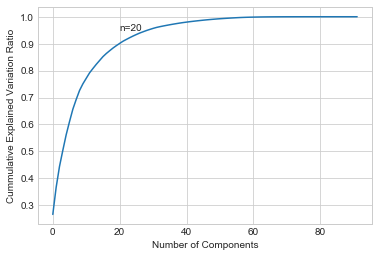

PCA Components Selected: 20 (This explains > 90% variance in the dataset)


In [2804]:
#Identify expalined variance in data:
print(pc.explained_variance_)

#Identify exaplained variation ration in data:
print(pc.explained_variance_ratio_)

#Plot cummulative sum of explained ratio:
plt.plot(np.cumsum(pc.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variation Ratio')
plt.annotate('n=20', xy = (20,0.95))
plt.show()
#Select principle componenets that explains maximum variance:
print('PCA Components Selected:', 20 ,'(This explains > 90% variance in the dataset)')

Text(0.5,1,'Principle Components After Dimension Reduction')

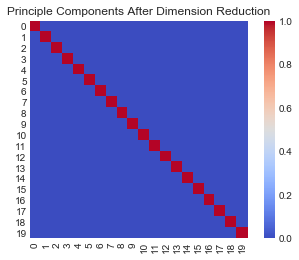

In [2805]:
#Fit and trasnform model with selected components:
pca = PCA(n_components=20)
pca_train = pca.fit_transform(X_trainb)
pca_test = pca.fit_transform(X_testb)

#Convert PCA training and test results in to dataframe: 
df_pca_train=pd.DataFrame(pca_train)
df_pca_test=pd.DataFrame(pca_test)

#Plot heatmap: 
sns.heatmap(df_pca_train.corr(), vmax=1, square=True, cmap='coolwarm')
plt.title('Principle Components After Dimension Reduction')

#### Applying PCA on Linear Regression Model: 

In [2806]:
#Fit model: 
model_pca_lr = lr.fit(pca_train, y_trainb)
print(model_pca_lr.coef_, model_pca_lr.intercept_)

[ 1.51724212  6.65703723  3.81269153  3.56577458 -0.74195725  2.67040665
  6.11306509  1.22091154  3.03380521 -0.42183602  9.80234361 15.63610638
  1.96282082 -2.51549424 -3.4451969   4.87874919 16.69466797 -0.39507795
 16.71856319 -7.2127707 ] 14.133353170071498


In [2807]:
#Run Prediction on PCA train and PCA test data: 
y_pred_pca_lr_train = abs(model_pca_lr.predict(pca_train))
y_pred_pca_lr_test = abs(model_pca_lr.predict(pca_test))

In [2808]:
#Convert result to dataframe: 
result_pca_lr= pd.DataFrame(y_pred_pca_lr_test, y_testb, columns= ['predict_pca_lr'])

In [2809]:
#View Predicted Results:
result_pca_lr.head()

,predict_pca_lr
cost,
2.100455,16.409467
6.162261,24.509651
12.508138,3.540715
5.305387,2.626998
6.134440,5.936649


In [2810]:
#Print Metrics:
print('Model Training Score:', r2_score(y_trainb, y_pred_pca_lr_train))
print('Model Test Score:', r2_score(y_testb, y_pred_pca_lr_test))
print('MAE:', mean_absolute_error(y_testb, y_pred_pca_lr_test))
print('MSE:', mean_squared_log_error(y_testb, y_pred_pca_lr_test))
print('RMSE:', np.sqrt(mean_squared_log_error(y_testb, y_pred_pca_lr_test)))

Model Training Score: 0.20784666194047052
Model Test Score: 0.04060623387034745
MAE: 14.032612033283286
MSE: 1.1602628706893128
RMSE: 1.0771549891679064


#### Observation:
1. PCA reduced components from 92 columns down to 20. 
2. However, PCA and Linear Regression Model together using binary encoder resulted in overfitting and high RSME error.
3. This means PCA and Linear Regression Model using label encoder shoild perform better. 

#### 6.a) Fit, Predict & Assess PCA algorithm using Model A:

In [2811]:
#Import PCA Library
from sklearn.decomposition import PCA

#Initiate PCA model: 
pc_a = PCA(n_components=34)

# Fit and Transform Training Data: 
model_1a_pca = pc_a.fit_transform(X_train)

#Transformed Values: 
model_1a_pca

array([[-4.65998327e-01, -3.79545478e-01, -8.93501494e-02, ...,
        -6.93375734e-03, -1.41311171e-03, -1.54830531e-04],
       [-3.68226976e-01, -8.58688952e-02, -2.52037126e-01, ...,
         9.95784179e-03,  3.18077499e-04, -1.63010417e-04],
       [-3.69552835e-01, -7.67728606e-02, -2.54058263e-01, ...,
         1.08162858e-03, -8.09953015e-04, -2.20746303e-04],
       ...,
       [ 1.31837973e+00, -6.32994567e-01, -8.23317662e-02, ...,
         8.13368475e-04,  1.13398276e-03,  7.35120196e-04],
       [-4.42368047e-01,  2.28101924e-02, -7.04081580e-03, ...,
         4.80232830e-04,  1.51251569e-03, -1.42807147e-04],
       [ 1.25893533e+00, -1.11141337e-01,  4.72768070e-02, ...,
         7.62036668e-03,  4.50989985e-04,  1.09835401e-03]])

Explained Variance:
 [4.77366283e-01 1.82165944e-01 1.25775935e-01 7.56763559e-02
 5.74052991e-02 5.16743312e-02 4.69437171e-02 4.45941814e-02
 3.82555059e-02 3.14718104e-02 2.20303357e-02 1.93908956e-02
 1.78662501e-02 1.66238906e-02 1.28503720e-02 1.11306044e-02
 8.03913682e-03 6.68923458e-03 2.74328475e-03 2.48120689e-03
 1.64228498e-03 1.43003050e-03 1.37909542e-03 8.26317613e-04
 7.84939347e-04 5.73627199e-04 5.08272515e-04 2.94038950e-04
 2.51003422e-04 2.29891340e-04 2.05791888e-04 1.57917889e-04
 1.18096912e-04 6.44672703e-05]
Expalined Variation Ratio:
 [3.78970302e-01 1.44617425e-01 9.98506716e-02 6.00777483e-02
 4.55727693e-02 4.10230835e-02 3.72675558e-02 3.54023126e-02
 3.03701814e-02 2.49847589e-02 1.74893855e-02 1.53939937e-02
 1.41836121e-02 1.31973310e-02 1.02016199e-02 8.83633526e-03
 6.38208901e-03 5.31043213e-03 2.17783175e-03 1.96977406e-03
 1.30377292e-03 1.13526889e-03 1.09483268e-03 6.55994875e-04
 6.23145605e-04 4.55389667e-04 4.03506061e-04 2.33430876e-04
 1.9

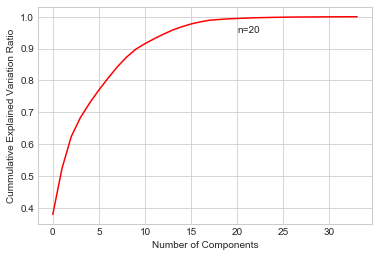

PCA Components Selected: 20 (This explains > 90% variance in the dataset)


In [2812]:
#Identify expalined variance in data:
print('Explained Variance:' '\n', pc_a.explained_variance_)

#Identify exaplained variation ration in data:
print('Expalined Variation Ratio:' '\n',pc_a.explained_variance_ratio_)

#Plot cummulative sum of explained ratio:
plt.plot(np.cumsum(pc_a.explained_variance_ratio_), color = 'red')
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variation Ratio')
plt.annotate('n=20', xy = (20,0.95))
plt.show()
#Select principle componenets that explains maximum variance:
print('PCA Components Selected:', 20 ,'(This explains > 90% variance in the dataset)')

Text(0.5,1,'Principle Components After Dimension Reduction')

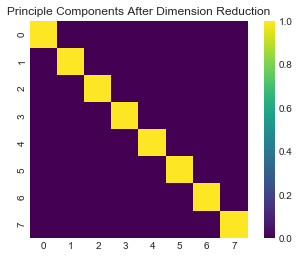

In [2813]:
#Fit and trasnform model with selected components:
pca_a = PCA(n_components=8)
pca_train_a = pca_a.fit_transform(X_train)
pca_test_a = pca_a.fit_transform(X_test)

#Convert PCA training and test results in to dataframe: 
df_pca_train_a=pd.DataFrame(pca_train_a)
df_pca_test_a=pd.DataFrame(pca_test_a)

#Plot heatmap: 
sns.heatmap(df_pca_train_a.corr(), vmax=1, square=True, cmap='viridis')
plt.title('Principle Components After Dimension Reduction')

In [2814]:
#Fit model: 
model_pca_lr_a = lr.fit(pca_train_a, y_train)
print(model_pca_lr_a.coef_, model_pca_lr_a.intercept_)

[ 1.5181034  22.54110358 23.31204615  0.60773128 23.35310692 12.3242188
 10.02700304 18.54793837] 14.133353170071437


In [2815]:
#Run Prediction on PCA train and PCA test data: 
y_pred_pca_lr_train_a = abs(model_pca_lr_a.predict(pca_train_a))
y_pred_pca_lr_test_a = abs(model_pca_lr_a.predict(pca_test_a))

In [2816]:
#Convert result to dataframe: 
result_pca_lr_a= pd.DataFrame(y_pred_pca_lr_test_a, y_test, columns= ['predict_pca_lr_a'])
#View Predicted Results:
result_pca_lr_a.head()

,predict_pca_lr_a
cost,
2.100455,1.449680
6.162261,1.961630
12.508138,10.010130
5.305387,9.612994
6.134440,5.675138


In [2817]:
#Print Metrics:
print('Model Training Score:', r2_score(y_train, y_pred_pca_lr_train_a))
print('Model Test Score:', r2_score(y_test, y_pred_pca_lr_test_a))
print('MAE:', mean_absolute_error(y_test, y_pred_pca_lr_test_a))
print('MSE:', mean_squared_log_error(y_testb, y_pred_pca_lr_test_a))
print('RMSE:', np.sqrt(mean_squared_log_error(y_test, y_pred_pca_lr_test_a)))

Model Training Score: 0.21716819547820876
Model Test Score: 0.19156128741493383
MAE: 10.028857706515648
MSE: 0.7259995177335786
RMSE: 0.852056053164097


#### Observation: 
1. As anticipated, PCA and Linear regression perfromed better with label encoder than binary encoder. 
2. But compared to previous models RMSE error and model scores did not stand out.

#### To Tested Later:  Neural Network 

In [2818]:
'''
#Import Neural Netwrok Library: 

import tensorflow as tf

tf.reset_default_graph

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

#Initiate Model
model = Sequential()

#Add Layers:
model.add(Dense(256, input_dim = X_trainb.shape[1],name = 'layer_1'))
model.add(Activation('relu'))
model.add(Dropout(0.03))

model.add(Dense(200, name = 'layer_2'))
model.add(Activation('relu'))
model.add(Dropout(0.03))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

model.fit(X_trainb,y_trainb, 
          validation_data = (X_testb, y_testb), 
          #validation_split= 0.20,
          batch_size = 50, 
          nb_epoch= 225)
'''
print('To be tried later') 


To be tried later


#### Compare Models: 
#### Question 20:  How does one models compares with another?
1. Here we will collect the results of various algorithms we ran earlier and look for lowest RMSE error (Actual_Predicted) value.
2. We will also look for model overfitting i.e areas where the difference between the training and test score was significant.


In [2819]:
#Compare Models: 
model_compare = {'PCA LR Model A':[np.sqrt(mean_squared_log_error(y_test, y_pred_pca_lr_test_a)),r2_score(y_train, y_pred_pca_lr_train_a),r2_score(y_test, y_pred_pca_lr_test_a)], 
                 'PCA LR Model B': [np.sqrt(mean_squared_log_error(y_testb, y_pred_pca_lr_test)),r2_score(y_train, y_pred_pca_lr_train),r2_score(y_test, y_pred_pca_lr_test)],
                 'Random Forest Model B': [RMSE_rf, score_train, score_test],
                 'Decision Tree Model B': [np.sqrt(mean_squared_log_error(y_testb, y_pred_dt_test)),r2_score(y_trainb,y_pred_dt_train), r2_score(y_testb,y_pred_dt_test)],
                 'LR Model A': [np.sqrt(mean_squared_log_error(y_test, y_pred_test)),r2_score(y_train, y_pred_train),r2_score(y_test,y_pred_test)], 
                 'LR Model B': [np.sqrt(mean_squared_log_error(y_testb, y_predb_test)),r2_score(y_trainb,y_predb_train), r2_score(y_testb,y_predb_test)],
                 'LR Agg Model A':[np.sqrt(mean_squared_log_error(y_testa, y_pred_agg_test)), r2_score(y_traina, y_pred_agg_train), r2_score(y_testa, y_pred_agg_test)]}                                                                                                                    

In [2820]:
# Convert in to DataFrame: 
df_model_compare= pd.DataFrame(model_compare, index = ['RMSE', 'Train Score', 'Test Score']).T
df_model_compare['Score Difference'] = (df_model_compare['Train Score'] - df_model_compare['Test Score']) 

#View Table: 
df_model_compare

,RMSE,Train Score,Test Score,Score Difference
PCA LR Model A,0.852056,0.217168,0.191561,0.025607
PCA LR Model B,1.077155,0.207847,0.040606,0.167240
Random Forest Model B,0.103546,1.000000,0.985516,0.014484
Decision Tree Model B,0.095397,1.000000,0.978418,0.021582
LR Model A,0.740764,0.345388,0.335355,0.010032
LR Model B,0.721484,0.431911,0.417228,0.014684
LR Agg Model A,0.679096,0.276447,0.397861,-0.121414


<Figure size 432x288 with 0 Axes>

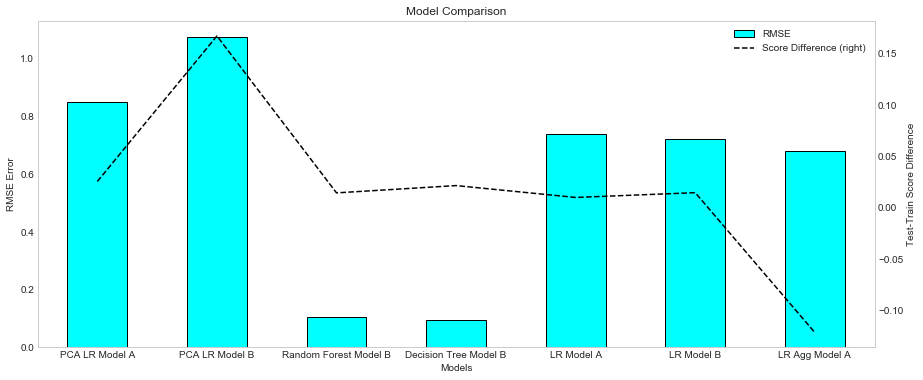

In [2821]:
fig = plt.figure()
ax1 = df_model_compare.plot(kind = 'bar', y = 'RMSE', figsize= (15,6), cmap = 'cool')
plt.ylabel('RMSE Error')
plt.xlabel ('Models')
ax2= df_model_compare['Score Difference'].plot(secondary_y=True, legend= True, color = 'black', linestyle = '--')
plt.title("Model Comparison")
plt.ylabel('Test-Train Score Difference')
plt.grid('off')

#### Observation: 
1. As per above, we can see that Ensemble models (Random Forest and Decision Tree) resulted in lowest RMSE error as well as negligible difference between Training & Testing score. 
2. Random Forest is preferred over Decsion Trees because it avoids model overfitting by employing multiple decision trees in the model.   
3. I will also try Neural Networks at a later stage, However, we need larger dataset to train neural network. 
4. <b>  Supplier price was predicted with 98% accuracy on test validation data using Random Forest. 
    
                                                                                                  END of Section 1 

## Section 2: Modelling for Categorizing Assemblies and Suppliers: 

#### Question 21:  Identify top 5 suppliers and top 5 assemblies, organization purchased over time? 

To answer this question, we will condier both bracket (bulk) and non_bracket (minimum order) spend. 

In [2828]:
#View Table: 
prime_77_final.head()

,tube_assembly_id,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost,component_id_1,quantity_1,...,num_boss,num_bracket,other,forming_end_a,forming_end_x,%supplier_rebate,year,extended_cost,total_cost,area
0,TA-00002,S-0066,2013-07-07,0,0,Yes,1,21.905933,C-1312,2.0,...,0,0,0,Yes,Yes,0.000000,2013,21.905933,0.0,74.92
1,TA-00002,S-0066,2013-07-07,0,0,Yes,2,12.341214,C-1312,2.0,...,0,0,0,Yes,Yes,43.662687,2013,24.682428,0.0,74.92
2,TA-00002,S-0066,2013-07-07,0,0,Yes,5,6.601826,C-1312,2.0,...,0,0,0,Yes,Yes,69.862840,2013,33.009131,0.0,74.92
3,TA-00002,S-0066,2013-07-07,0,0,Yes,10,4.687770,C-1312,2.0,...,0,0,0,Yes,Yes,78.600457,2013,46.877695,0.0,74.92
4,TA-00002,S-0066,2013-07-07,0,0,Yes,25,3.541561,C-1312,2.0,...,0,0,0,Yes,Yes,83.832868,2013,88.539030,0.0,74.92


In [2829]:
#Import Datetime:
import datetime as dt

#Convert quote date from object to datetime format:
prime_77_final['quote_date']=pd.to_datetime(prime_77_final['quote_date'])

In [2832]:
#Extract Year from Date: 
prime_77_final['year']=prime_77_final['quote_date'].dt.year.sort_values()

#Identify Top 5 bulk suppliers: 
suppliers=prime_77_final.groupby(['supplier', 'year', 'bracket_pricing'])['total_cost'].sum()

#Unstack: 
suppliers=suppliers.unstack()

#Get Total Spend on Supplier Bulk Spend and sort it in descending order:
suppliers_bulk = suppliers['Yes'].reset_index().sort_values(by = 'Yes', ascending = False).head()

#Get Total Spend on Supplier Non_Bulk Spend and sort it in descending  order:
suppliers_non_bulk = suppliers['No'].reset_index().sort_values(by = 'No', ascending = False).head()

#Identify Top 5 Assemblies: 
assembly = prime_77_final.groupby(['tube_assembly_id', 'year', 'bracket_pricing'])['total_cost'].sum()

#Unstack: 
assembly=assembly.unstack()

#Get Top 5 Total Spend on Bulk Assemblies and sort it by descending order: 
assembly_bulk= assembly['Yes'].reset_index().sort_values(by = 'Yes', ascending = False).head()

#Get Top 5 Total Spend on Non_Bulk Assemblies and sort it by descending order:
assembly_non_bulk= assembly['No'].reset_index().sort_values(by = 'No', ascending = False).head()

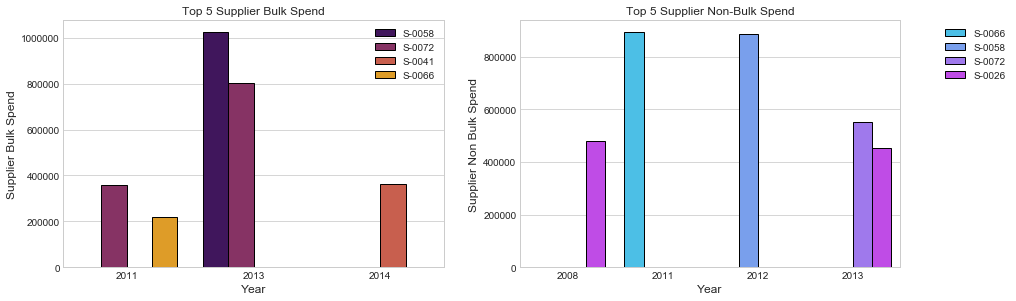

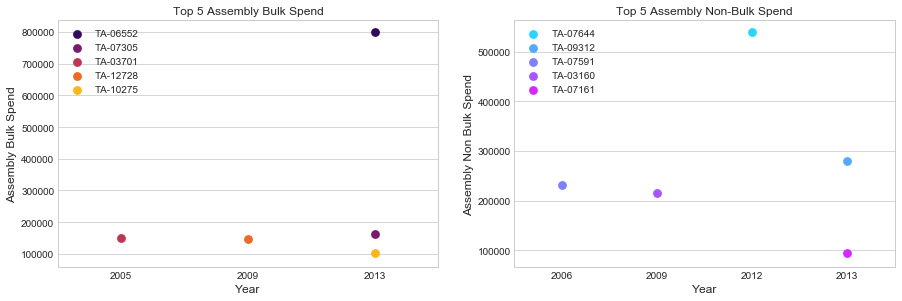

In [2970]:
#For Top 5 Suppliers: 
#Plot Supplier Bulk Spend
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.barplot(x = 'year', y = 'Yes', data = suppliers_bulk, hue='supplier',  palette='inferno')
plt.ylabel('Supplier Bulk Spend', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Top 5 Supplier Bulk Spend', fontsize = 12)
plt.legend(loc = 'upper right')


#Plot Supplier Non_Bulk Spend
plt.subplot(2,2,2)
sns.barplot(x = 'year', y = 'No', data = suppliers_non_bulk, hue='supplier',  palette= 'cool')
plt.ylabel('Supplier Non Bulk Spend', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Top 5 Supplier Non-Bulk Spend', fontsize = 12)
plt.legend(loc = 'upper right', bbox_to_anchor= (1.3,1))

#For Top 5 Assembly:
#Plot Assembly Bulk Spend
plt.figure(figsize=(15,10))
plt.subplot(2,2,3)
sns.pointplot(x = 'year', y = 'Yes', data = assembly_bulk, hue='tube_assembly_id',  palette= 'inferno', secondary_x = True)

plt.ylabel('Assembly Bulk Spend', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Top 5 Assembly Bulk Spend', fontsize = 12)
plt.legend(loc = 'best')

#Plot Assembly Non_Bulk Spend:
plt.subplot(2,2,4)
sns.pointplot(x = 'year', y = 'No', data = assembly_non_bulk, hue='tube_assembly_id',  palette='cool')
plt.ylabel('Assembly Non Bulk Spend', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Top 5 Assembly Non-Bulk Spend', fontsize = 12)
plt.legend(loc = 'upper left')

#### Observation: 
1. Graph above shows top 5 suppliers and assemblies for bulk and non-bulk spends. 
2. Supplier, S-0058 and S-0066 incurred highest bulk and non bulk spend.
3. Assembly, TA-06552 and TA-07644 incurred highest bulk and non-bulk spend.

#### Question 22: What is the change in the Tube Assembly Total Spend over time? 
Here we will look at how category spend has changed over time. 

Text(0.5,1,'Assemblies Total Spend OverTime')

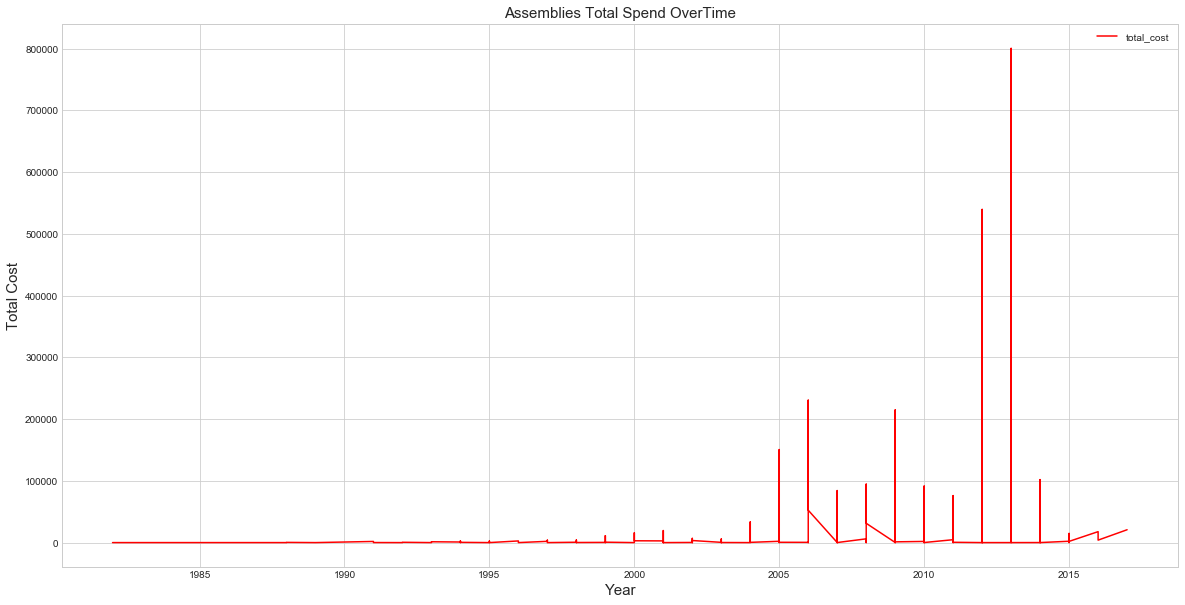

In [2971]:
# Plot  change in Assembly Total Spend over Time: 
time=pd.DataFrame(prime_77_final.groupby(['tube_assembly_id','year', 'bracket_pricing'])['total_cost'].sum()).reset_index()
time.sort_values('year').plot(x = 'year', y = 'total_cost', figsize = (20,10), color= 'red')
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Total Cost', fontsize = 15)
plt.title('Assemblies Total Spend OverTime' , fontsize = 15)

#### Observation: 
1. From above graph, we can see that there are assemblies that have total spend > 100K. 

#### Question 23: Which assemblies had a total spend > 100K and when?

In [2626]:
#Assembly > 100 K spend
assembly_100=time[['tube_assembly_id','year','total_cost']][time['total_cost']>100000].sort_values('total_cost', ascending = False)
print('Number Assemblies with Total Spend > 100K:' '\n', assembly_100['tube_assembly_id'].nunique())
print('Year of Purchase:' '\n', assembly_100['year'].sort_values().unique())

#View table:
assembly_100.head()

Number Assemblies with Total Spend > 100K:
 11
Year of Purchase:
 [2005 2006 2009 2012 2013 2014]


,tube_assembly_id,year,total_cost
2672,TA-06552,2013,800533.765851
3090,TA-07644,2012,539694.504321
3781,TA-09312,2013,279031.415011
3075,TA-07591,2006,230681.011891
1347,TA-03160,2009,214842.563278


Text(0.5,1,'Assemblies with Total Spend > 100K')

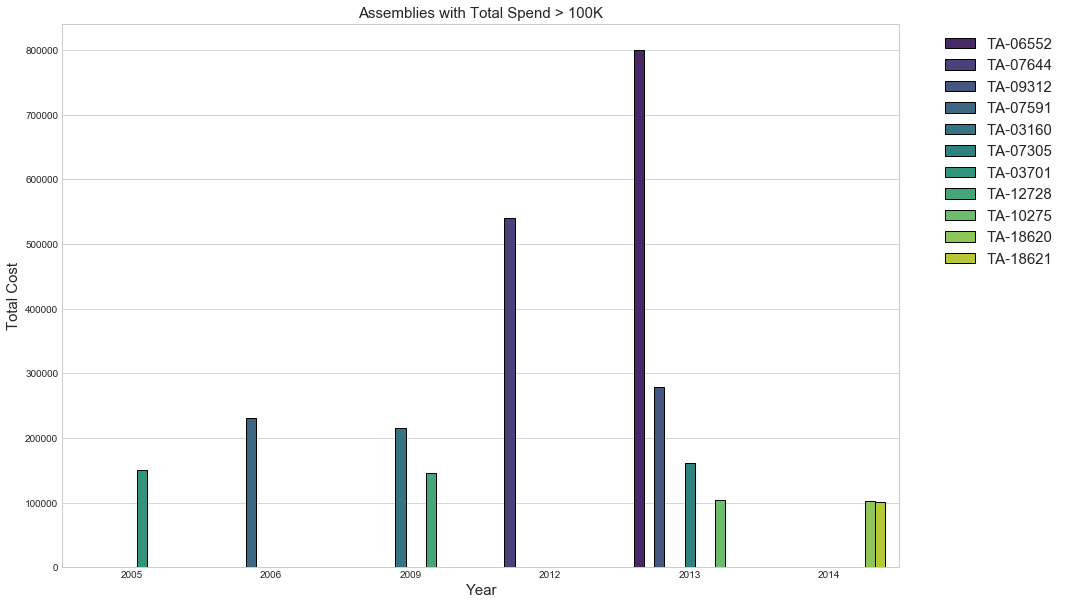

In [2634]:
#Plot Assemblies with Total Spend > 100K:
plt.figure(figsize = (15,10))
sns.barplot(x = 'year', y = 'total_cost', data = assembly_100, hue = 'tube_assembly_id', palette='viridis')
plt.legend(loc = 'upper right', bbox_to_anchor = (1.2,1), fontsize= 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Total Cost', fontsize = 15)
plt.title('Assemblies with Total Spend > 100K' , fontsize = 15)

#### Observation: 
1. Shows assemblies with spend > 100K
2. Year 2009, 2013 and 2014, we had one or more assemblies with total spend > 100K. 

### Categorizing Assemblies and Suppliers based on Business Requirements:   
Our goal here establish a benchmark of categories and suppliers that are performing in line with the business needs.   

#### Question 24: How should we classify our Assemblies?  

<b>Assumption:</b> Pre-classification criteria should be based on business needs such as:
1. Recency (R): Most recent purchase activity.
2. Frequency(F): How often we buy.
3. Monetary Value (M): Total Spend based on usage.
4. Supplier Rebate(R): Cost Savings. 
5. Market Difficulty (MD): Difficulty switching suppliers.

Based on above, let's us build our classification criteria:  

#### First, create reference point in time to develop measurable features: 

In [2635]:
# Creating reference point in time:
prime_77_final['quote_date'].max()
prime_77_final['quote_date'].min()
df_delta = prime_77_final['quote_date'].max()-prime_77_final['quote_date'].min()
print('Days of Transaction history:' '\n',df_delta)

#Day after most recent purchase:
now = prime_77_final['quote_date'].max() + dt.timedelta(1)
print('Reference Point:' '\n', now)

Days of Transaction history:
 12520 days 00:00:00
Reference Point:
 2017-01-02 00:00:00


### a.1) Build Model to Categorize Assemblies:  
**Please note: As per data in the primary table, tube assemblies have a maximum of 2 unique suppliers supplying these assemblies, a result all assemblies would be classified as critical buy, making it difficult for us to explore other spend categories. Hence, instead of unique suppliers in the table below, I have used supplier count to build this model. This, should relate to business users more closely, where operations team would prefer to have various qualified suppliers who can provide services without delay and defects.      

In [2636]:
#Checking maximum and minimum number of unique suppliers per each assembly:
test=prime_77_final.groupby(['tube_assembly_id']).agg({'supplier': lambda x : x.nunique()}) 
print(test.sort_values(by= 'supplier', ascending=False).head(2), '\n',test.sort_values(by= 'supplier', ascending=False).tail(2))

                  supplier
tube_assembly_id          
TA-04762                 2
TA-11013                 2 
                   supplier
tube_assembly_id          
TA-07477                 1
TA-21197                 1


#### Observation: 
1. Hence, instead of unique suppliers I have chosen 'count of suppliers' to help build pre-classification criteria. 

#### Build Assembly Segmentation Table: 

In [2637]:
#Group by Tube Assembly and obtain pre-classification values:
table=prime_77_final.groupby(['tube_assembly_id', 'supplier', 'bracket_pricing']).agg({'quote_date': lambda x: (now - x.max()).days,
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'supplier': lambda x : x.count()}) 

#Convert datatype to integer:
table['quote_date'] = table['quote_date'].astype(int)

#Round off total cost and supplier rebate:
table['total_cost'] =table['total_cost'].round(decimals= 2) 
table['%supplier_rebate'] =table['%supplier_rebate'].round(decimals= 2)

#Rename Column Names: 
table.rename(columns={'quote_date': 'recency', 
                      'annual_usage': 'frequency',
                      'total_cost': 'monetary_value',
                      'supplier': 'market_difficulty'}, inplace=True)
#View Table
table.head()

#Re-assign table to segmented: 
segmented = table

#### Build Classification Score and Assign Sourcing Portfolio Type: 

#### Spilt Assemblies in to 3 quartiles a.k.a 80/20 rule:
1. 0 to 20%
2. 20% to 80%
3. 80% to 100%

In [2638]:
#Segmented table in to quartiles:   
quantiles = table.quantile(q=[0.20,0.80])

#View Table: 
quantiles

,recency,frequency,monetary_value,%supplier_rebate,market_difficulty
0.2,1219.0,0.0,0.000,0.00,1.0
0.8,2162.0,180.0,793.664,63.15,8.0


In [2639]:
#Convert Quantile to Dictionary
quantiles = quantiles.to_dict()
quantiles

{'%supplier_rebate': {0.2: 0.0, 0.8: 63.15},
 'frequency': {0.2: 0.0, 0.8: 180.0},
 'market_difficulty': {0.2: 1.0, 0.8: 8.0},
 'monetary_value': {0.2: 0.0, 0.8: 793.6640000000001},
 'recency': {0.2: 1219.0, 0.8: 2162.0}}

#### Question 25: Based on the business needs, how would be score our best category?

#### Ideal Category Score:  
1. Lowest recency activity i.e something bought recently scored as 1.
2. Lowest market difficulty i.e ease in switching suppliers scored as 1.
3. Highest frequently bought item scored as 1.
4. High Spend or profit impact on business scored as 1.
5. High supplier rebates scored as 1. 

Hence using above criteria, we will write a function to build category score for our assemblies.

In [2640]:
#Write function to score business needs based on 3 quartiles: 
def RScore(result,column,value):
    
    """
    RScore will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 1, 2 & 3 respectively   
    """
    if result <= value[column][0.20]:
        return 1
    if (result> value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 3
    
def FMScore(result,column,value):
      
    """
    FMScore will return column values that are between
    0 to 20%, 20% to 80% and 80% to 100% 
    in the order 3, 2 & 1 respectively   
    
    """
    if result <= value[column][0.20]:
        return 3
    if (result > value[column][.20]) & (result < value[column][0.80]):
        return 2
    else:
        return 1


#### Apply Function to Segmented Table:

In [2641]:
#Recency Score 
segmented['recency_score'] = segmented['recency'].apply(RScore, args=('recency',quantiles))

#Frequency Score:
segmented['frequency_score'] = segmented['frequency'].apply(FMScore, args=('frequency',quantiles))

#Spend Score:
segmented['monetary_score'] = segmented['monetary_value'].apply(FMScore, args=('monetary_value',quantiles))

#Rebate Score:
segmented['rebate_score'] = segmented['%supplier_rebate'].apply(FMScore, args=('%supplier_rebate',quantiles))

#Market Score:
segmented['market_score'] = segmented['market_difficulty'].apply(FMScore, args=('market_difficulty', quantiles))

In [2642]:
#View Table: 
segmented.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3


In [2643]:
#Combined Score: 
segmented['combined_score'] = (segmented['recency_score'].map(str) 
                               + segmented['frequency_score'].map(str) 
                               + segmented['monetary_score'].map(str)
                               + segmented['rebate_score'].map(str) 
                               + segmented['market_score'].map(str))

In [2644]:
#View Assembly scores:
segmented.head(10)

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1,23311
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1,23311
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1,13311
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1,23311
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3,32233
TA-00014,S-0066,Yes,1387,0,0.00,66.41,8,2,3,3,1,1,23311
TA-00021,S-0030,No,1057,1,3.43,0.00,1,1,2,2,3,3,12233
TA-00022,S-0013,No,1986,1,8.56,0.00,1,2,2,2,3,3,22233
TA-00024,S-0066,Yes,1250,0,0.00,69.77,8,2,3,3,1,1,23311


#### Question 26: From above, identify top 10 assembly categories which appeared most during segmentation? 
Here we want to identify popular categories and think about how we are going to define these categories. 

22233    1296
23311    1292
22222    1117
32233     836
21133     530
12233     387
13321     364
13311     311
21233     285
31133     264
Name: combined_score, dtype: int64


Text(0.5,1,'Top 10 Assembly Categories based on Business Needs')

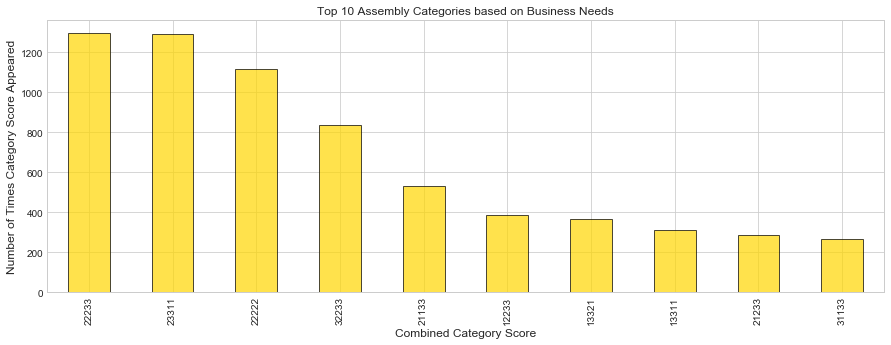

In [2645]:
#Top 10 Assembly Category Scores 
assembly_scores=segmented['combined_score'].sort_values(ascending= False).value_counts().head(10)
print(assembly_scores)
plt.figure(figsize=(15,5))
assembly_scores.plot(kind = 'bar', color = 'gold', alpha = 0.7)
plt.xlabel('Combined Category Score', fontsize= 12)
plt.ylabel('Number of Times Category Score Appeared', fontsize= 12)
plt.title('Top 10 Assembly Categories based on Business Needs', fontsize= 12)

#### Observation: 
1. Catgeory 23311, 22233 and 22222 described certain business needs more than 1000 times, compared to the rest.

#### Question 27: 
1. How should we assign names these categories so that appropriate sourcing strategy can be implemented? 

#### Assigning Categories based on Porfolio Analysis:

There 4 types of sourcing spends: 
1. Strategic
2. Critical
3. Leverage
4. Spot 

Just for testing, I added 5th category unclassified to keep check of assemblies that do not fall under any category and why. Our goal is to ensure that we don't have any unclassified spend.

In [2646]:
#Write Function: 

def categorize(x):
    
    """
    Categorize will segment sourcing type based on combined score given in the table:
    
    Examples: 
    1) Critical Buy(buying often from only supplier)
    Type: High Frequency, Medium to High Spend, Low Rebates purchases bought from Sole Supplier
    
    2) Startegic Buy (buying high spend items from very few suppliers):
    Type: High Frequency, High Spend, High to Medium Rebates purchases bought from a Few Suppliers 
    
    3) Leverage Buy (buying frequently from many suppliers): 
    Type: Mostly Recent, High Frequency, Low Spend, High Rebates purchases bought from Many Suppliers
    
    4) Spot Buy (not buying often and can buy from anyone)
    Type: Low or medium Frequency, Low Rebate Purchases bought from Any Supplier
    
    5) Unclassified spend
    
    """
    
    #High Frequency Sole Suppliers                                 or               Low Rebate Sole Suppliers:                      or            Medium Rebate Sole Suppliers:                     or                  Medium Rebate Sole Suppliers
    if (x['combined_score'][1]=='1')& (x['combined_score'][4]=='3') | (x['combined_score'][3]=='3') & (x['combined_score'][4]=='3') | (x['combined_score'][3]=='2') & (x['combined_score'][4]=='3') | (x['combined_score'][3]=='1') & (x['combined_score'][4]=='3'):
        return ('Critical Buy')
    
    #High Spend Few Suppliers                                          or          High Rebate Few Suppliers                          or        Medium Rebate Few Suppliers                           or        High Frequency Few Suppliers
    elif (x['combined_score'][2]=='1') & (x['combined_score'][4]=='2') | (x['combined_score'][3]=='1') & (x['combined_score'][4]=='2') | (x['combined_score'][3]=='2') & (x['combined_score'][4]=='2') | (x['combined_score'][1]=='1') & (x['combined_score'][4]=='2'):
        return ('Strategic Buy')
    #High Frequency Many Suppliers                                    or         Low Spend Many Suppliers                            or         High Rebate Multiple Suppliers                       or         Recent Buy Multiple Suppliers
    elif (x['combined_score'][1]=='1') & (x['combined_score'][4]=='1') | (x['combined_score'][2]=='3') & (x['combined_score'][4]=='1')| (x['combined_score'][3]=='1') & (x['combined_score'][4]=='1') | (x['combined_score'][0]=='1') & (x['combined_score'][4]=='1'):
        return ('Leverage Buy')
    
    # Low Frequency Low Rebate:                                         or          Medium Frequency Low Rebate:
    elif (x['combined_score'][1]=='3') & (x['combined_score'][3]=='3') | (x['combined_score'][1]=='2') & (x['combined_score'][3]=='3'):
        return ('Spot Buy')
    
    else:
        return('Unclassified Buy')
    
       

In [2647]:
#Create an new column and apply function:
segmented['category_type'] = segmented.apply(categorize, axis =1)

In [2648]:
#View Table:
segmented.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.00,66.68,8,2,3,3,1,1,23311,Leverage Buy
TA-00004,S-0066,Yes,1275,0,0.00,66.48,8,2,3,3,1,1,23311,Leverage Buy
TA-00005,S-0066,Yes,1219,0,0.00,63.87,8,1,3,3,1,1,13311,Leverage Buy
TA-00012,S-0066,Yes,1240,0,0.00,65.16,8,2,3,3,1,1,23311,Leverage Buy
TA-00013,S-0026,No,8931,50,500.21,0.00,1,3,2,2,3,3,32233,Critical Buy


#### Question 28: Why is this Category Critical Buy?

In [2649]:
print(segmented['category_type'].groupby([segmented['category_type']=='Critical Buy']).count())
segmented[segmented['category_type']=='Critical Buy'].head()

category_type
False    4535
True     4373
Name: category_type, dtype: int64


,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00013,S-0026,No,8931,50,500.21,0.0,1,3,2,2,3,3,32233,Critical Buy
TA-00021,S-0030,No,1057,1,3.43,0.0,1,1,2,2,3,3,12233,Critical Buy
TA-00022,S-0013,No,1986,1,8.56,0.0,1,2,2,2,3,3,22233,Critical Buy
TA-00027,S-0062,No,8501,30,82.13,0.0,1,3,2,2,3,3,32233,Critical Buy
TA-00037,S-0062,No,8159,600,938.11,0.0,1,3,1,1,3,3,31133,Critical Buy


#### Observation: 
1. Critical buy because we are buying from the only supplier.
2. Rebates vary because it may depend upon company size and supplier preference. 
3. High order frequency and only supplier, could result in limited rebates and order delays. 

#### Question 29: Why is this Category Strategic Buy?

In [2650]:
print(segmented['category_type'].groupby([segmented['category_type']=='Strategic Buy']).count())
segmented[segmented['category_type']=='Strategic Buy'].head()

category_type
False    6603
True     2305
Name: category_type, dtype: int64


,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00028,S-0062,Yes,2019,6,13.07,19.62,2,2,2,2,2,2,22222,Strategic Buy
TA-00031,S-0014,Yes,5271,12,41.29,49.34,6,3,2,2,2,2,32222,Strategic Buy
TA-00034,S-0062,Yes,879,530,6365.35,71.80,6,1,1,1,1,2,11112,Strategic Buy
TA-00054,S-0064,Yes,4213,20,185.62,31.73,4,3,2,2,2,2,32222,Strategic Buy
TA-00058,S-0072,Yes,888,8,20.26,28.16,4,1,2,2,2,2,12222,Strategic Buy


#### Observation: 
1. Strategic buy because medium to large spend is managed by a handlful of suppliers.
2. Rebates vary between medium to high.  
3. Few suppliers are able to handle high order volume.

#### Question 30: Why is this Category Leverage Buy?`

In [2651]:
print(segmented['category_type'].groupby([segmented['category_type']=='Leverage Buy']).count())
segmented[segmented['category_type']=='Leverage Buy'].head()

category_type
False    6695
True     2213
Name: category_type, dtype: int64


,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00002,S-0066,Yes,1275,0,0.0,66.68,8,2,3,3,1,1,23311,Leverage Buy
TA-00004,S-0066,Yes,1275,0,0.0,66.48,8,2,3,3,1,1,23311,Leverage Buy
TA-00005,S-0066,Yes,1219,0,0.0,63.87,8,1,3,3,1,1,13311,Leverage Buy
TA-00012,S-0066,Yes,1240,0,0.0,65.16,8,2,3,3,1,1,23311,Leverage Buy
TA-00014,S-0066,Yes,1387,0,0.0,66.41,8,2,3,3,1,1,23311,Leverage Buy


#### Observation: 
1. Leverage buy because we have many suppliers who carry these assemblies. Easy to switch suppliers.
2. Higher Rebates possible through spend consolidation. 
3. Low spend but high order volume. 

#### Question 31: Why is this category Spot Buy?

In [2652]:
print(segmented['category_type'].groupby([segmented['category_type']=='Spot Buy']).count())
segmented[segmented['category_type']=='Spot Buy'].head()

category_type
False    8891
True       17
Name: category_type, dtype: int64


,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,recency_score,frequency_score,monetary_score,rebate_score,market_score,combined_score,category_type
tube_assembly_id,supplier,bracket_pricing,,,,,,,,,,,,
TA-00969,S-0072,Yes,1196,50,334.26,0.0,2,1,2,2,3,2,12232,Spot Buy
TA-01270,S-0041,Yes,1103,2,0.23,0.0,2,1,2,2,3,2,12232,Spot Buy
TA-01460,S-0062,Yes,888,28,51.47,0.0,2,1,2,2,3,2,12232,Spot Buy
TA-03671,S-0062,Yes,866,35,12.14,0.0,2,1,2,2,3,2,12232,Spot Buy
TA-05784,S-0031,Yes,1371,101,608.90,0.0,2,2,2,2,3,2,22232,Spot Buy


#### Observation: 
1. Spot buy because of low rebates and infrequent/one-time purchase. 
2. Easy to get from any supplier
3. Low rebates unless it purchased regulary.

In [2653]:
print('Result:', segmented[segmented['category_type']=='Unclassified Buy'])

Result: Empty DataFrame
Columns: [recency, frequency, monetary_value, %supplier_rebate, market_difficulty, recency_score, frequency_score, monetary_score, rebate_score, market_score, combined_score, category_type]
Index: []


#### Observation: 
1. Unclassified Spend didn't return any values. Hence, categorization was assigned successfully.

#### Visualize Assembly Categories: 

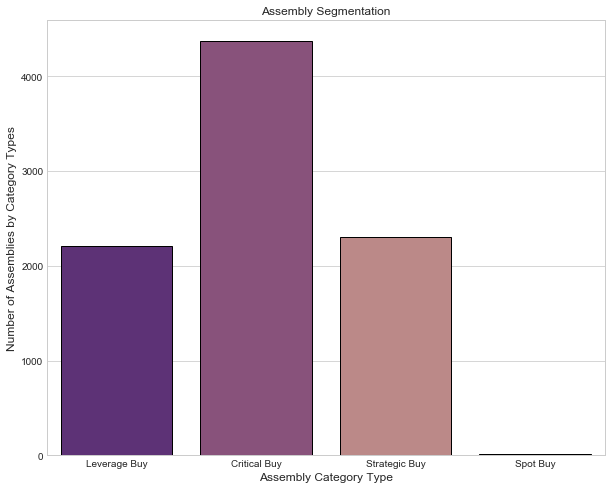

In [2654]:
#Count plot to see Sourcing breakdown based on assigned category scores:
plt.figure(figsize=(10,8))
sns.set_style(style='whitegrid')
sns.countplot(x= 'category_type', data = segmented, palette='plasma', saturation=0.4)
plt.title('Assembly Segmentation', fontsize = 12)
plt.ylabel('Number of Assemblies by Category Types', fontsize = 12)
plt.xlabel('Assembly Category Type', fontsize = 12)
plt.yscale('linear')

In [2655]:
#Calculate % of each source type:
a= segmented['category_type'].value_counts()
b= segmented['category_type'].count()
c=a/b
print(c)

Critical Buy     0.490907
Strategic Buy    0.258756
Leverage Buy     0.248428
Spot Buy         0.001908
Name: category_type, dtype: float64


In [2656]:
c.index

Index(['Critical Buy', 'Strategic Buy', 'Leverage Buy', 'Spot Buy'], dtype='object')

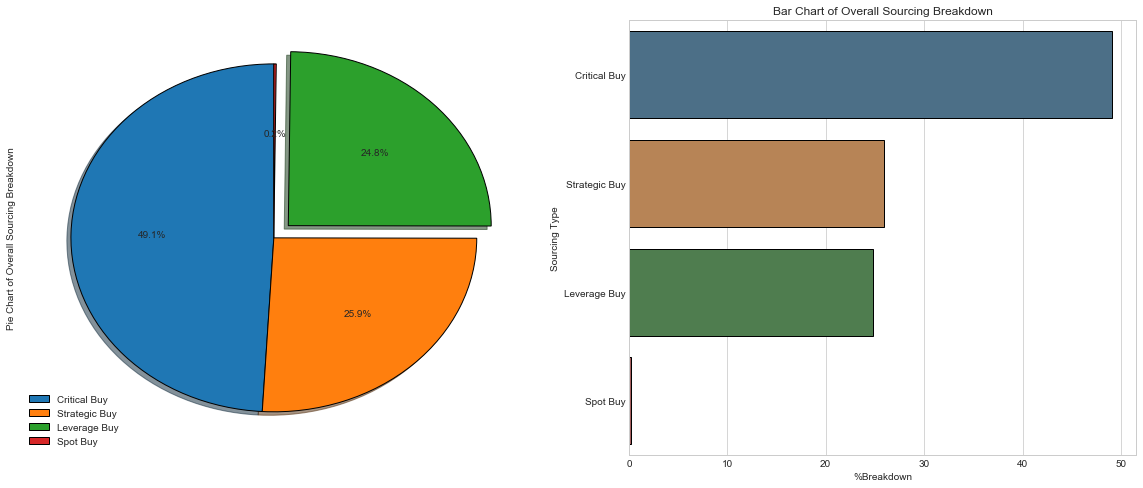

In [2657]:
#Plot pie and bar chart to see %breakdown of each sourcing type: 
plt.figure(figsize = (20,8))
plt.subplot(1,2,2)
sns.barplot(y = c.index, x = c * 100, saturation=0.4, label= 'Spend Breakdown')
plt.xlabel('%Breakdown')
plt.ylabel('Sourcing Type')
plt.title('Bar Chart of Overall Sourcing Breakdown')

plt.subplot(1,2,1)
c.plot(kind= 'pie', label='Pie Chart of Overall Sourcing Breakdown', explode= (0, 0, 0.1, 0), autopct='%1.1f%%', shadow=True, startangle=90, labels =None)
plt.legend(c.index,loc='lower left')

#### Observation: 
1. Majority of tube assemblies are purchased from sole suppliers, 49.1%
2. Startegic and Leverage Options account 25.9% to 24.8% each. 
3. There are opportities to consolodate critical spend with leverage and strategic spends. 

Let's us see how we can build a model to identify category opportunities

### a.2) Model Assembly Portfolio usink K-Means Clustering:
Now that we have built our pre-classfication criteria, we are going to apply unsupervised learning to group (cluster) assemblies which demonstrate similar characterstics. 

#### Question 32: What opportunities exist in our assembly portfolio that we can utilize to drive cost savings? 

We will be able to answer this question after we have run the model. Here are the steps we will follow:  

<b>a. Preparation:</b>
1. Normalize data to get ready for modelling.

<b>b. Build and Run model: </b>
1. Identify new formed clusters. 
2. Explain trends.


#### Preparation: First, check for skewness in data and normalize: 

#### Question 33: How to prepare segmented table ready for modelling? 

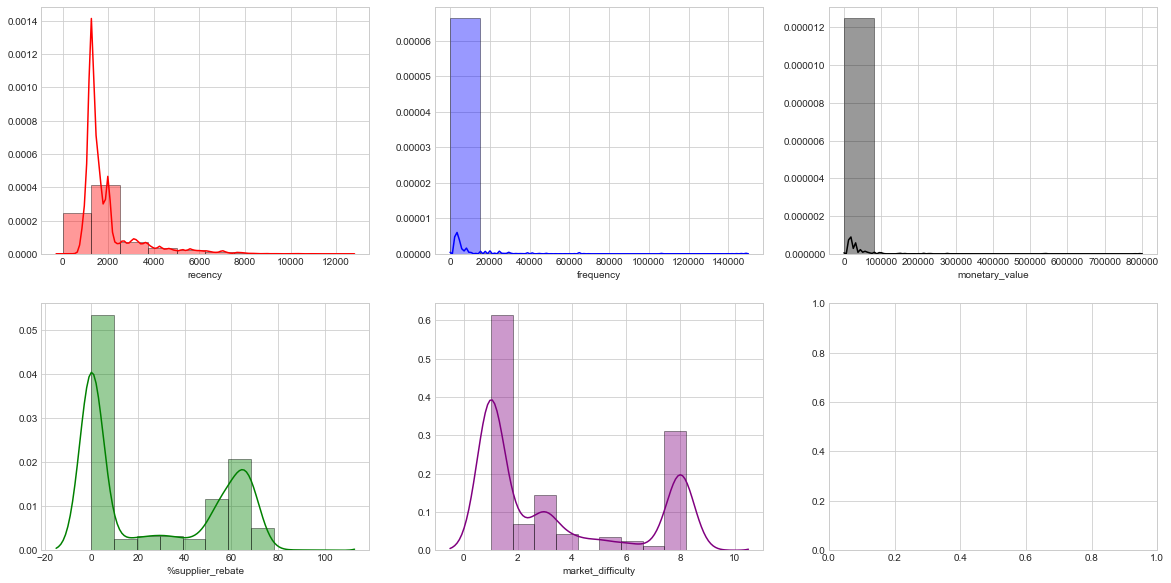

In [2658]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(segmented['recency'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(segmented['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(segmented['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(segmented['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(segmented['market_difficulty'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. Distribution is highly skewed. We would need to make these distribution normal in order to make meaningful clusters. 
2. Data vlaues along x and y axis is not on the same scale.

#### Log Transformation: 

In [2659]:
#log transformation:
segmented_log = np.log(segmented[['recency', 'frequency', 'monetary_value', '%supplier_rebate', 'market_difficulty']]+1)

In [2660]:
#View table: 
segmented_log.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty
tube_assembly_id,supplier,bracket_pricing,,,,,
TA-00002,S-0066,Yes,7.151485,0.000000,0.000000,4.214791,2.197225
TA-00004,S-0066,Yes,7.151485,0.000000,0.000000,4.211831,2.197225
TA-00005,S-0066,Yes,7.106606,0.000000,0.000000,4.172385,2.197225
TA-00012,S-0066,Yes,7.123673,0.000000,0.000000,4.192076,2.197225
TA-00013,S-0026,No,9.097396,3.931826,6.217025,0.000000,0.693147


#### Standardise segmented_log table to ensure common scale: 


In [2661]:
#Import Standard Scaler:
from sklearn.preprocessing import StandardScaler

#Initiate Standard Scaler
s= StandardScaler()

#Fit and Transform Segmented_log table:
segmented_log_normalized= s.fit_transform(segmented_log)

#Convert to dataframe:
df_segmented_log_normalized= pd.DataFrame(segmented_log_normalized, index=segmented_log.index, columns = segmented_log.columns)

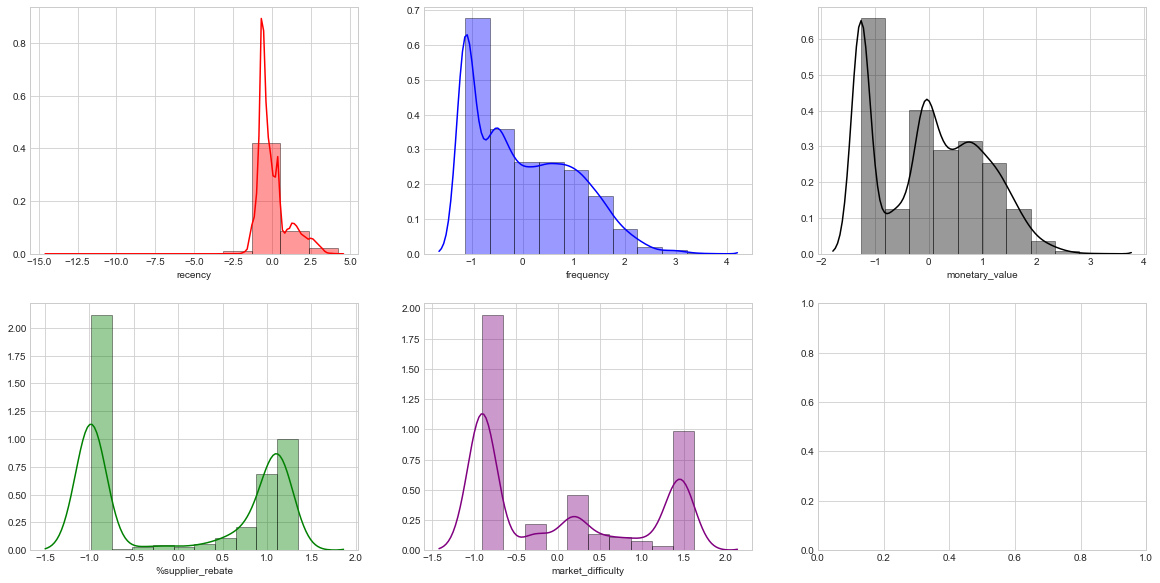

In [2662]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(df_segmented_log_normalized['recency'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(df_segmented_log_normalized['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(df_segmented_log_normalized['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(df_segmented_log_normalized['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(df_segmented_log_normalized['market_difficulty'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. From graph above, we can observe that our data points are on the same scale along x and y axis.
2. Skewness that we noticed in our data prior to log transformation and standardization has been reduced. 

#### Fit Model: K-Means Clustering

#### Question 34: How to select optimal number of K in K-mean clustering?

#### Find optimal number of clusters using Elbow Method: 

In [2663]:
#Import K-Means model: 
from sklearn.cluster import KMeans

'''
Calculate SSE: It measures difference in each observation from it's group mean in a cluster. 
Optimal K-Value: It is selected at the elbow point (see graph), 
                  where change in SSE becomes marginal with the increase in K.  
'''

#Create empty dictionary of Sum of squared error (sse). 
sse = {}

# iterate values of k clusters from 1 to 30 (random range): 
for k in range(1,30):
    
    #Initiate Kmeans
    k_m = KMeans(n_clusters=k)
    
    #Fit model:
    k_m.fit(df_segmented_log_normalized)
    
    #Calculate sse for each value of k
    sse[k] = k_m.inertia_  
    

In [2664]:
#View K and corresponding SSE values:
print('SSE Key Value-Pairs:' '\n',sse.keys(), sse.values())

SSE Key Value-Pairs:
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]) dict_values([44540.0, 21732.938410375005, 17155.69518115971, 13650.802416642158, 10151.033937996166, 8982.863141238953, 7908.685992903894, 7000.501294486534, 6337.067675406296, 5937.985171024398, 5548.658277273916, 5206.565118482033, 4886.268789861184, 4609.002295870038, 4359.385716156734, 4184.804625416762, 3963.23811615856, 3804.5461786738188, 3664.393076020005, 3519.8349218485782, 3345.3196224833014, 3238.6275456540343, 3117.3334748993, 3022.712010490143, 2927.538921219234, 2863.8680252001077, 2795.0726009626896, 2711.3726089058273, 2600.406721042754])


#### Plot K and SSE values: Elbow Graph

Text(4,11000,'K=5')

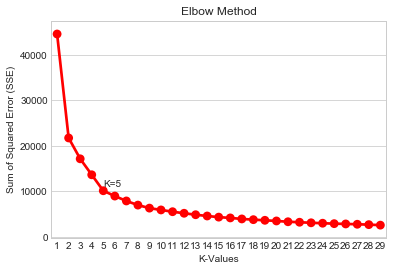

In [2976]:
#Use pointplot:
sns.pointplot(x=list(sse.keys()), y = list(sse.values()), color='red')

plt.xlabel('K-Values')
plt.ylabel('Sum of Squared Error (SSE)')
plt.title('Elbow Method')
plt.annotate('K=5', xy =(4,11000))

#### Observation: 
1. At K =5, we noticed an elbow point where change in SSE becomes marginal when compared to it's previous K-value.
2. Hence, K =5 will be the optimal number of clusters we will use to describe our model. 

#### Applying K-Means Clustering using optimal K-value: 

In [2977]:
#initiatlize kmeans with optimal clusters:
k_m = KMeans(n_clusters=5, random_state=12)

#Fit model:
k_m.fit(df_segmented_log_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=12, tol=0.0001, verbose=0)

In [2978]:
#Generate Cluster labels: 
clusters=k_m.labels_

#Assign cluster labels to the segmented table: 
segmented_cluster = segmented_log.assign(assembly_clusters=clusters)

In [2979]:
#View Table: 
segmented_cluster.head()

,,,recency,frequency,monetary_value,%supplier_rebate,market_difficulty,assembly_clusters
tube_assembly_id,supplier,bracket_pricing,,,,,,
TA-00002,S-0066,Yes,7.151485,0.000000,0.000000,4.214791,2.197225,2
TA-00004,S-0066,Yes,7.151485,0.000000,0.000000,4.211831,2.197225,2
TA-00005,S-0066,Yes,7.106606,0.000000,0.000000,4.172385,2.197225,2
TA-00012,S-0066,Yes,7.123673,0.000000,0.000000,4.192076,2.197225,2
TA-00013,S-0026,No,9.097396,3.931826,6.217025,0.000000,0.693147,4


#### Question 35: How would be describe the properties of the each assembly cluster? 

Let's build an aggregated table for each clusters and see how does the mean value vary 

#### Build aggregate table of segmented clusters:

In [2980]:
#Aggregation Table:
segmented_agg=segmented_cluster.groupby('assembly_clusters').agg({'recency': ['mean','count'],
                                                              'frequency': ['mean','count'],
                                                              'monetary_value': ['mean', 'count'], 
                                                              '%supplier_rebate': ['mean', 'count'],
                                                              'market_difficulty': ['mean', 'count']}).round(decimals= 1) 

In [2981]:
#View Table: 
segmented_agg.stack()

recency  frequency  monetary_value  %supplier_rebate  \
assembly_clusters                                                               
0                 mean       7.3        2.6             4.2               3.8   
                  count   1898.0     1898.0          1898.0            1898.0   
1                 mean       7.4        5.8             7.1               0.3   
                  count   2338.0     2338.0          2338.0            2338.0   
2                 mean       7.2        0.0             0.0               4.2   
                  count   2140.0     2140.0          2140.0            2140.0   
3                 mean       7.2        2.0             2.9               0.0   
                  count   1360.0     1360.0          1360.0            1360.0   
4                 mean       8.4        3.0             4.7               0.4   
                  count   1172.0     1172.0          1172.0            1172.0   

                         market_difficulty  
assembly_clusters                           
0                 mean                 1.6  
                  count             1898.0  
1                 mean                 0.8  
                  count             2338.0  
2                 mean                 2.2  
                  count             2140.0  
3                 mean                 0.7  
                  count             1360.0  
4                 mean                 0.8  
                  count             1172.0

#### Observation:
1. From above table we can observe, that each cluster carries certain mean value for each criteria. 
2. Example: Assembly Cluster 0 has 2141 assemblies with normalized mean values for each criteria.
3. K-Means algorithm will assign cluster lables to the assemblies based on how close normalized values are closer to its mean while far separated from other clusters.

In [2982]:
segmented_melt= pd.melt(segmented_cluster.reset_index(), 
                        id_vars=['tube_assembly_id','supplier', 'bracket_pricing','assembly_clusters'],
                        value_vars=['recency','frequency', 'monetary_value', '%supplier_rebate', 'market_difficulty'],
                        var_name='criteria',
                        value_name='normalized_value')

In [2983]:
#Round off normalized values: 
segmented_melt['normalized_value']=segmented_melt['normalized_value'].round(decimals =1)
segmented_melt.head() 

,tube_assembly_id,supplier,bracket_pricing,assembly_clusters,criteria,normalized_value
0,TA-00002,S-0066,Yes,2,recency,7.2
1,TA-00004,S-0066,Yes,2,recency,7.2
2,TA-00005,S-0066,Yes,2,recency,7.1
3,TA-00012,S-0066,Yes,2,recency,7.1
4,TA-00013,S-0026,No,4,recency,9.1


#### Question 36: How do we verify which values in the cluster were closer to the mean? 

In [2984]:
#Describe Assembly Cluster 0 for Recency: 
segmented_melt[(segmented_melt['criteria']=='recency') & (segmented_melt['assembly_clusters']==0)].describe()

,assembly_clusters,normalized_value
count,1898.0,1898.000000
mean,0.0,7.331770
std,0.0,0.333757
min,0.0,0.700000
25%,0.0,7.100000
50%,0.0,7.400000
75%,0.0,7.500000
max,0.0,8.300000


#### Observation: 
1. Assembly cluster 0 has been assigned to recency based on normalized values between 7.1 and 8.7. 
2. Similarly we can identify Assembly Clusters for other assemblies. 

#### Visualize Assembly Clusters and how it varies with our business needs (Category Criteria): 

In [2985]:
#Reset Index:
segmented_melt=segmented_melt.set_index(['tube_assembly_id'])

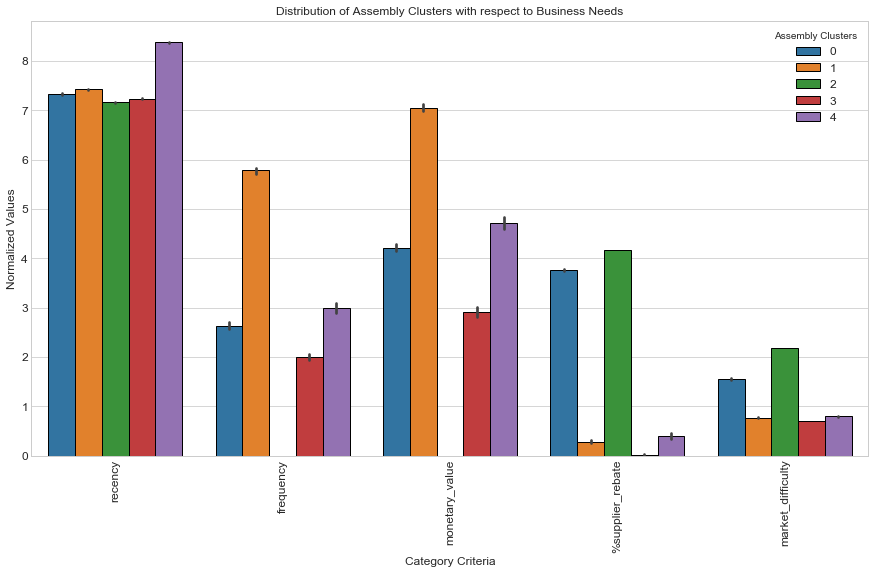

In [2986]:
#BarPlot:
plt.figure(figsize= (15,8))
sns.barplot(x= 'criteria', y = 'normalized_value', data= segmented_melt, hue='assembly_clusters')
plt.xticks(fontsize = 12,rotation= 90)
plt.yticks(fontsize = 12)
plt.xlabel('Category Criteria', fontsize = 12)
plt.ylabel('Normalized Values', fontsize= 12)
plt.title('Distribution of Assembly Clusters with respect to Business Needs', fontsize= 12)
plt.legend(title= 'Assembly Clusters', fontsize= 'large')


#### Observation: 
1. We have 5 assembly clusters.  
2. Assembly cluster 1 is ordered frequently, has high spend and low market difficulty (multiple suppliers), still low rebates.    
3. Let's look at point plot to see more trends.

Text(0.5,1,'Trend of Business Needs Across Assembly Clusters')

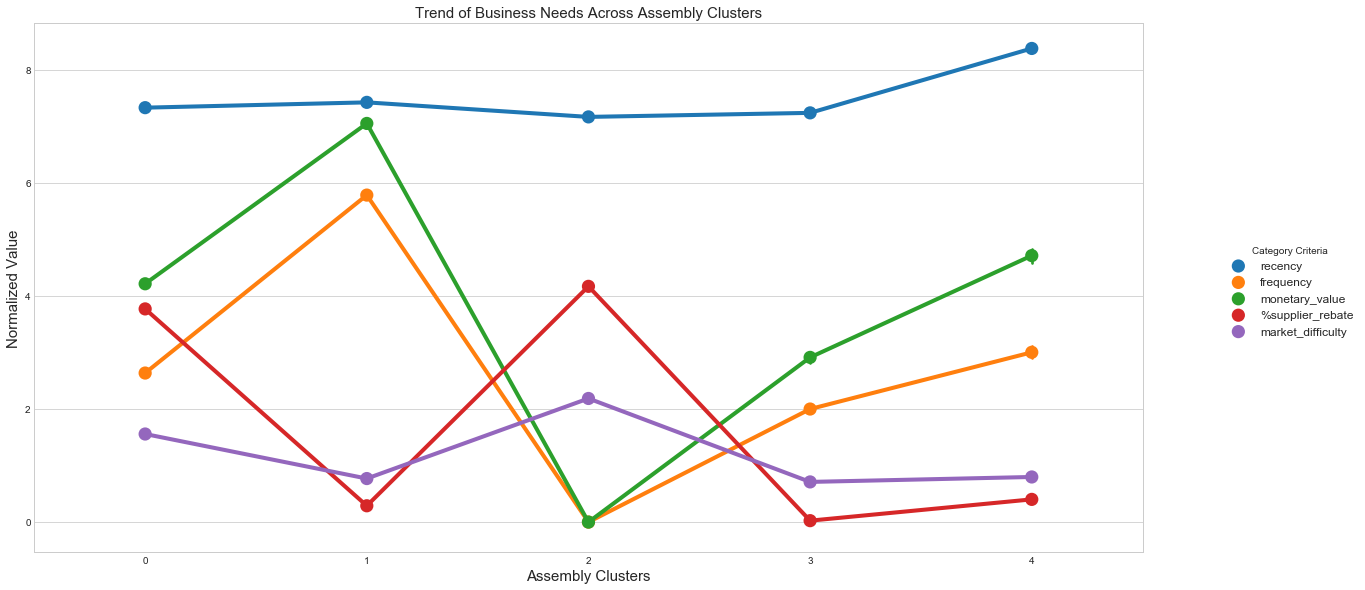

In [2987]:
#Point Plot:
plt.figure(figsize= (16,8))
#fig,axes = plt.subplots()
sns.pointplot(x= 'assembly_clusters', y = 'normalized_value', data= segmented_melt, hue='criteria', scale = 1.5, fontsize=3)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(1.2, 0.5))
plt.title('Assembly Classification', fontsize=15)
plt.xlabel('Assembly Clusters', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend(title= 'Category Criteria', fontsize = 'large',  fancybox= True, loc = 'upper right', bbox_to_anchor=(1.2,0.6))
plt.title('Trend of Business Needs Across Assembly Clusters', fontsize = 15)

### Observation: Response to Question 32:
1. Assembly Clusters 1,3 and 4 have high supplier spend and freqeuncy of purchase but lowest supplier rebates. 
2. Assembly Cluster 2 does not have supplier spend but are motivated to offer high rebates (potential for leverage buy). 
3. Assembly Cluster 0 is the best managed category offering most rebates have fewer suppliers (like strategic buy). 

<b>Assembly Cluster 0  can be used as a benchmark to manage other clusters and find improvements.  

In [2989]:
#Assembly Cluster 0 as a benchmark fro other categories:
segmented_melt[segmented_melt['assembly_clusters']==0].head()

,supplier,bracket_pricing,assembly_clusters,criteria,normalized_value
tube_assembly_id,,,,,
TA-00028,S-0062,Yes,0,recency,7.6
TA-00034,S-0062,Yes,0,recency,6.8
TA-00058,S-0072,Yes,0,recency,6.8
TA-00077,S-0066,Yes,0,recency,7.5
TA-00104,S-0041,Yes,0,recency,7.3


### Similary, we will build Supplier Segmentation to Draw Insights about Supplier Opportunities: 

#### Question 37:  How should we categorize our assembly suppliers? 

### b.1) Build Pre-Supplier Segmentation Criteria. 

This is based on how business users would like to assess supplier performance. 
1. Contract Length in Years. 
2. Frequency of buy over the contract length.
3. Total Spend with Suppliers a.k.s Monetary Value
4. Suppliers Rebates 
5. Supplier Preference based on <b>Assembly Assortment</b> 
(This is based on various assortments of assemblies a supplier carry and supply)

Hence, based on above, let's build a pre-classification criteria to categorize assembly suppliers:

In [2678]:
#Develop Supplier Aggregation table: 
table_2=prime_77_final.groupby(['supplier']).agg({'quote_date': lambda x: (now - x.max()).days/365,
                                               'annual_usage': lambda x: x.sum(),
                                               'total_cost' : lambda x: x.sum(), 
                                               '%supplier_rebate': lambda x : abs(x.mean()),
                                               'tube_assembly_id': lambda x : x.count()}) 

#Convert datatype to integer:
table_2['quote_date'] = table_2['quote_date'].astype(int)

#Round off total cost and supplier rebate:
table_2['total_cost'] =table_2['total_cost'].round(decimals= 2) 
table_2['%supplier_rebate'] =table_2['%supplier_rebate'].round(decimals= 2)

#Rename Column Names: 
table_2.rename(columns={'quote_date': 'contract_length_yrs', 
                      'annual_usage': 'frequency',
                      'total_cost': 'monetary_value',
                      'tube_assembly_id': 'supplier_preference'}, inplace=True)
#View Table
table_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
supplier,,,,,
S-0003,4,4,385.07,0.0,1
S-0004,3,1,11.89,0.0,1
S-0005,2,8936,47902.45,0.0,24
S-0006,3,300,7741.08,0.0,1
S-0007,5,1551,66080.08,0.0,5


In [2679]:
#Re-assign table to segmented: 
segmented_2 = table_2

#### Build Classification Score using 3 quartile:  80/20 Rule
1. 0 to 20%
2. 20 to 80%
3. 80 to 100%

In [2680]:
#Split table as per quartile defined above:  
quantiles_2 = table_2.quantile(q=[0.20,0.80])

#View Table: 
quantiles_2

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
0.2,2.0,7.4,44.798,0.00,1.0
0.8,4.0,18033.8,147382.264,26.19,84.8


In [2681]:
#Convert Quantile to Dictionary
quantiles_2 = quantiles_2.to_dict()
quantiles_2

{'%supplier_rebate': {0.2: 0.0, 0.8: 26.190000000000005},
 'contract_length_yrs': {0.2: 2.0, 0.8: 4.0},
 'frequency': {0.2: 7.400000000000002, 0.8: 18033.800000000003},
 'monetary_value': {0.2: 44.798, 0.8: 147382.26400000023},
 'supplier_preference': {0.2: 1.0, 0.8: 84.80000000000011}}

#### Question 37: Based on business needs, who would be considered our preferred supplier? 

#### Preferred Supplier would demonstarte following Attributes:  
1. Longest Contractual Relationship to be rated as 1.
2. Supplier, who carries maximum assortment of assemblies to be rated as 1.
3. Supplier who is used frequently to be rated as 1.
4. Supplier, who is provides high spend or profit impact assemblies to be rated as 1.
5. Supplier, who provides high cost savings to be rated as 1. 

#### Applying Functions RScore and FMScore built earlier to the new Segmented Table:

In [2682]:
#Recency Score 
segmented_2['relationship_score'] = segmented_2['contract_length_yrs'].apply(FMScore, args=('contract_length_yrs',quantiles_2))

#Frequency Score:
segmented_2['frequency_score'] = segmented_2['frequency'].apply(FMScore, args=('frequency',quantiles_2))

#Spend Score:
segmented_2['monetary_score'] = segmented_2['monetary_value'].apply(FMScore, args=('monetary_value',quantiles_2))

#Rebate Score:
segmented_2['rebate_score'] = segmented_2['%supplier_rebate'].apply(FMScore, args=('%supplier_rebate',quantiles_2))

#Market Score:
segmented_2['preference_score'] = segmented_2['supplier_preference'].apply(FMScore, args=('supplier_preference', quantiles_2))

In [2683]:
#View Table: 
segmented_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score
supplier,,,,,,,,,,
S-0003,4,4,385.07,0.0,1,1,3,2,3,3
S-0004,3,1,11.89,0.0,1,2,3,3,3,3
S-0005,2,8936,47902.45,0.0,24,3,2,2,3,2
S-0006,3,300,7741.08,0.0,1,2,2,2,3,3
S-0007,5,1551,66080.08,0.0,5,1,2,2,3,2


In [2684]:
#Combined Score: 
segmented_2['combined_score'] = (segmented_2['relationship_score'].map(str) 
                               + segmented_2['frequency_score'].map(str) 
                               + segmented_2['monetary_score'].map(str)
                               + segmented_2['rebate_score'].map(str) 
                               + segmented_2['preference_score'].map(str))

In [2685]:
#View table: 
segmented_2.head(10)

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score
supplier,,,,,,,,,,,
S-0003,4,4,385.07,0.00,1,1,3,2,3,3,13233
S-0004,3,1,11.89,0.00,1,2,3,3,3,3,23333
S-0005,2,8936,47902.45,0.00,24,3,2,2,3,2,32232
S-0006,3,300,7741.08,0.00,1,2,2,2,3,3,22233
S-0007,5,1551,66080.08,0.00,5,1,2,2,3,2,12232
S-0008,3,7,70.49,52.71,7,2,3,2,1,2,23212
S-0009,2,4,269.37,0.00,4,3,3,2,3,2,33232
S-0011,2,215,975.97,0.00,5,3,2,2,3,2,32232
S-0012,5,438,2535.39,0.00,1,1,2,2,3,3,12233


#### Question 38: Which supplier categories appeared most in segmentation?

32222    6
31121    6
32232    5
31111    4
32233    3
12232    3
13332    3
33232    2
33333    2
12222    2
Name: combined_score, dtype: int64


Text(0.5,1,'Top 10 Supplier Categories based on Business Needs')

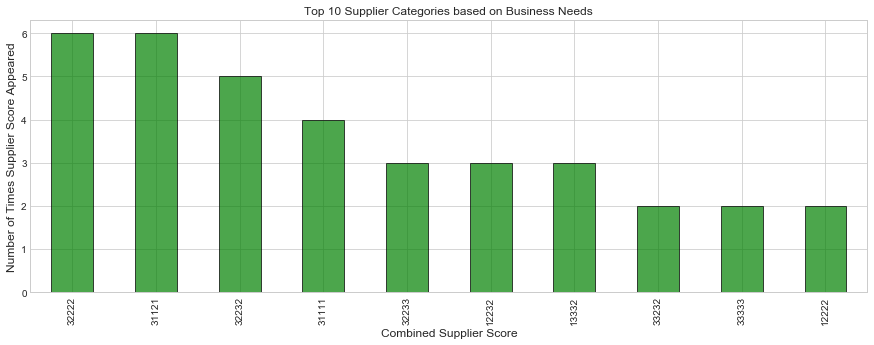

In [2686]:
#Supplier Categories which appread most: 
supplier_scores= segmented_2['combined_score'].sort_values(ascending= False).value_counts().head(10)
print(supplier_scores)
plt.figure(figsize=(15,5))
supplier_scores.plot(kind = 'bar', color = 'green', alpha = 0.7)
plt.xlabel('Combined Supplier Score', fontsize= 12)
plt.ylabel('Number of Times Supplier Score Appeared', fontsize= 12)
plt.title('Top 10 Supplier Categories based on Business Needs', fontsize= 12)

#### Observation: 
1. Supplier categories 32222, 31121, 32232 have appreared most. 
2. Let's define supplier categories so that we can effectively manage supplier relations.

#### Assign Supplier Categories based on 3 Types:

1. Preferred 
2. Tactical 
3. Sole 

I have also added a 4 category 'unclassified' to identify and avoid unclassified suppliers. 
Furthermore, we can also add another supplier category 'developmental' to find suppliers whom we would like to develop based on certain business criteria. This will be part of my future projects. 

In [2687]:
#Write a Function to Assign Supplier Categories: 

def categorize_2(x):
    
    '''
    Categorize_2 will segment supplier types based on combined score given in the table:
    
    Examples: 
    1) Sole Supplier (Offer single type of assembly, monopoly) 
    Type: Relationship based, Low Rebate supplier providing single type of assembly. 
    
    2) Preferred Supplier (carry maximum assortment of assemblies, have high spend and long term contracts):
    Type: High Frequency, High Spend, High to Medium Rebates purchases bought from a Few Preferred Suppliers. 
    
    3) Tactical Suppliers (carry medium assortment of assemblies): 
    Type: Mostly Recent, High Frequency, Low Spend, High Rebates purchases bought from Many Suppliers.
       
    4) Unclassified Suppliers
    
    '''
   
        # Single Assortment:
    if (x['combined_score'][4]=='3'):
        return ('Sole Supplier')
    
    #Long Term High Frequency                                         or      High Spend High Rebate                                  or        High Assortment
    elif (x['combined_score'][0]=='1') & (x['combined_score'][1]=='1') |  (x['combined_score'][2]=='1') & (x['combined_score'][3]=='1') |  (x['combined_score'][4]=='1'):
        return ('Preferred Supplier')
    
    #Medium Term Low Spend                                            or    Medium Frequency          or    Medium Assortment                         
    elif (x['combined_score'][0]=='2') & (x['combined_score'][2]=='3') | (x['combined_score'][1]=='2')  | (x['combined_score'][4]=='2') :
        return ('Tactical Supplier')
    
    else: 
        return ('Unclassified Suppliers')       

In [2688]:
#Create a new Column: 
segmented_2['supplier_type'] = segmented_2.apply(categorize_2, axis =1)

In [2689]:
#View Table: 
segmented_2.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0003,4,4,385.07,0.0,1,1,3,2,3,3,13233,Sole Supplier
S-0004,3,1,11.89,0.0,1,2,3,3,3,3,23333,Sole Supplier
S-0005,2,8936,47902.45,0.0,24,3,2,2,3,2,32232,Tactical Supplier
S-0006,3,300,7741.08,0.0,1,2,2,2,3,3,22233,Sole Supplier
S-0007,5,1551,66080.08,0.0,5,1,2,2,3,2,12232,Tactical Supplier


#### Question 39: Why is this category under Sole Suppliers?  

In [2690]:
print(segmented_2['supplier_type'].groupby([segmented_2['supplier_type']=='Sole Supplier']).count())
segmented_2[segmented_2['supplier_type']=='Sole Supplier'].head()

supplier_type
False    44
True     13
Name: supplier_type, dtype: int64


,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0003,4,4,385.07,0.0,1,1,3,2,3,3,13233,Sole Supplier
S-0004,3,1,11.89,0.0,1,2,3,3,3,3,23333,Sole Supplier
S-0006,3,300,7741.08,0.0,1,2,2,2,3,3,22233,Sole Supplier
S-0012,5,438,2535.39,0.0,1,1,2,2,3,3,12233,Sole Supplier
S-0022,2,4500,46.07,0.0,1,3,2,2,3,3,32233,Sole Supplier


#### Observation: 
1. Sole because they carry single type of assembly. 
2. Low rebate, hence they could be monopolistic.
3. Relationship based contracts, low frequency use. 

#### Question 40: Why is this category under Preferred Suppliers?  

In [2691]:
print(segmented_2['supplier_type'].groupby([segmented_2['supplier_type']=='Preferred Supplier']).count())
segmented_2[segmented_2['supplier_type']=='Preferred Supplier'].head()

supplier_type
False    45
True     12
Name: supplier_type, dtype: int64


,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0013,1,238725,421721.18,1.43,554,3,1,1,2,1,31121,Preferred Supplier
S-0014,2,18236,175571.96,30.24,139,3,1,1,1,1,31111,Preferred Supplier
S-0026,0,253456,2216863.69,13.13,727,3,1,1,2,1,31121,Preferred Supplier
S-0030,2,24244,208942.12,2.02,111,3,1,1,2,1,31121,Preferred Supplier
S-0041,2,346700,1399691.92,39.63,3323,3,1,1,1,1,31111,Preferred Supplier


#### Observation: 
1. Preferred because they manage high spend and carry high assortments of assemblies.
2. Most of our preferred suppliers are fairly new when compared to others and haven't been in a long term contract.  

In [2692]:
print(segmented_2['supplier_type'].groupby([segmented_2['supplier_type']=='Tactical Supplier']).count())
segmented_2[segmented_2['supplier_type']=='Tactical Supplier'].head()

supplier_type
False    25
True     32
Name: supplier_type, dtype: int64


,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,relationship_score,frequency_score,monetary_score,rebate_score,preference_score,combined_score,supplier_type
supplier,,,,,,,,,,,,
S-0005,2,8936,47902.45,0.00,24,3,2,2,3,2,32232,Tactical Supplier
S-0007,5,1551,66080.08,0.00,5,1,2,2,3,2,12232,Tactical Supplier
S-0008,3,7,70.49,52.71,7,2,3,2,1,2,23212,Tactical Supplier
S-0009,2,4,269.37,0.00,4,3,3,2,3,2,33232,Tactical Supplier
S-0011,2,215,975.97,0.00,5,3,2,2,3,2,32232,Tactical Supplier


#### Observation: 
1. Tactical because focus is on managing low spend volume. 
2. Medium term relationship with suppliers who carry more than one assembly assortments.

In [2693]:
print('Result:', segmented_2[segmented_2['supplier_type']=='Developmental Supplier'].head())

Result: Empty DataFrame
Columns: [contract_length_yrs, frequency, monetary_value, %supplier_rebate, supplier_preference, relationship_score, frequency_score, monetary_score, rebate_score, preference_score, combined_score, supplier_type]
Index: []


#### Observation: 
1. Result didn't return any unclassified suppliers, hence supplier segmentation was assigned sucessfully. 

#### Visualize Supplier Classification:

#### Question 41: What percentage of our assembly is sourced from a preferred supplier? 

Text(0,0.5,'Number of Suppliers per Segment')

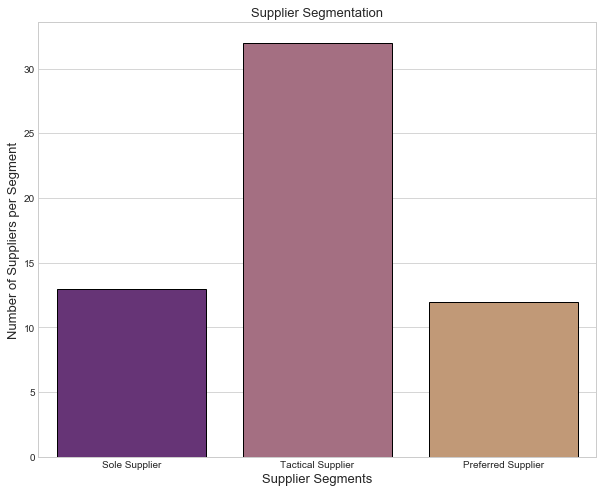

In [2694]:
#Count plot to see Sourcing breakdown based on assigned category scores:
plt.figure(figsize=(10,8))
sns.set_style(style='whitegrid')
sns.countplot(x= 'supplier_type', data = segmented_2, saturation=0.4, palette='plasma')
plt.title('Supplier Segmentation', fontsize = 13)
plt.xlabel('Supplier Segments', fontsize = 13)
plt.ylabel('Number of Suppliers per Segment', fontsize =13)

In [2695]:
#Calculate % of each source type:
a_2= segmented_2['supplier_type'].value_counts()
b_2= segmented_2['supplier_type'].count()
d=a_2/b_2
print(d)

Tactical Supplier     0.561404
Sole Supplier         0.228070
Preferred Supplier    0.210526
Name: supplier_type, dtype: float64


In [2696]:
d.index

Index(['Tactical Supplier', 'Sole Supplier', 'Preferred Supplier'], dtype='object')

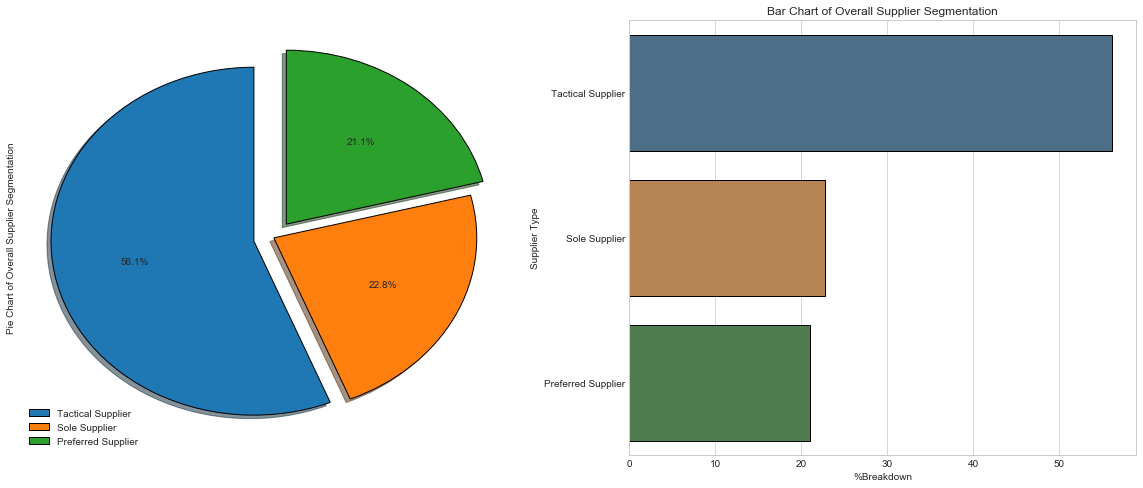

In [2697]:
#Plot pie and bar chart to see %breakdown of each sourcing type: 
plt.figure(figsize = (20,8))
plt.subplot(1,2,2)
sns.barplot(y = d.index, x = d * 100, saturation=0.4, label= 'Spend Breakdown')
plt.xlabel('%Breakdown')
plt.ylabel('Supplier Type')
plt.title('Bar Chart of Overall Supplier Segmentation')

plt.subplot(1,2,1)
d.plot(kind= 'pie', label='Pie Chart of Overall Supplier Segmentation', explode= (0.1, 0, 0.1), autopct='%1.1f%%', shadow=True, startangle=90, labels =None)
plt.legend(d.index,loc='lower left')

### Observation: 
1. High number of Tactical Suppliers, 56.1%
2. Fewer Preferred suppliers than Sole Suppliers.  
3. There may be opportunities to transform tactical suppliers into Preferred.   
4. May be an opportunity to conduct business review why we sole source? 

### b.2) Model Supplier Segmentation using K-Means Clustering:

#### Question 42: What can we learn about our suppliers from Supplier Segmenation? Are there any supplier improvement opportunities that can drive cost savings? 

We will be able to answer after we have run the model. Here are the steps we will follow:  

<b>a. Preparation:</b>
1. Normalize data to get ready for modelling.

<b>b. Build and Run model: </b>
1. Identify new formed clusters. 
2. Explain trend these clusters follow.



#### First, check for skewness in data and normalize: 

#### Question 42: Is our data ready for k-means modelling? What are the steps we need to take to normalize our data?

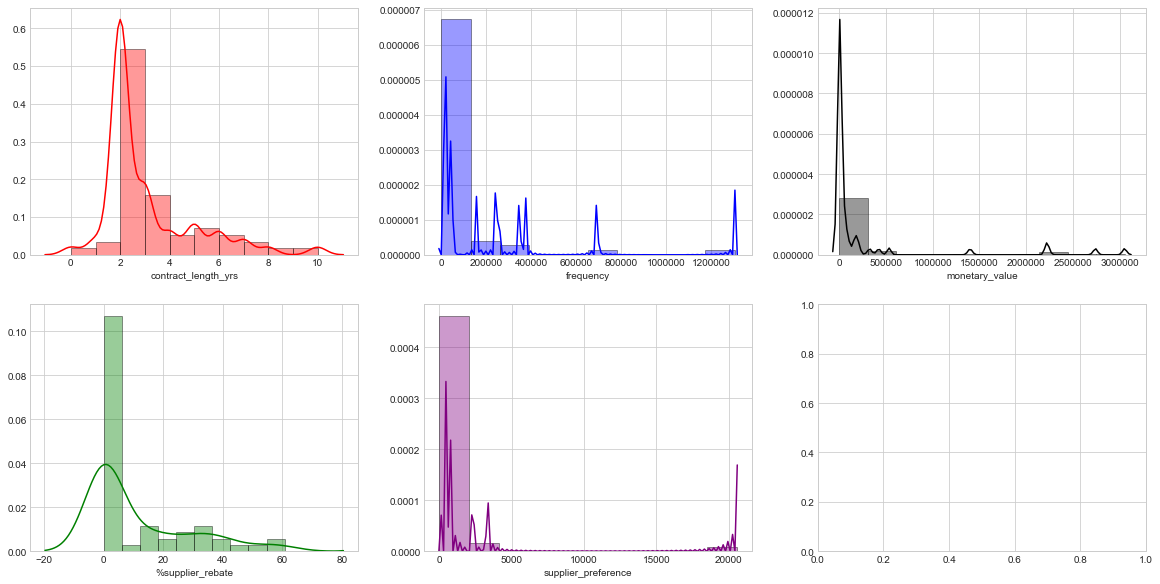

In [2698]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(segmented_2['contract_length_yrs'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(segmented_2['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(segmented_2['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(segmented_2['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(segmented_2['supplier_preference'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. Distribution is highly skewed. We would need to make these distribution normal in order to make meaningful clusters. 

#### Log Transformation: 

In [2699]:
#Applying log transformation:
segmented_2_log = np.log(segmented_2[['contract_length_yrs', 'frequency', 'monetary_value', '%supplier_rebate', 'supplier_preference']]+1)

In [2700]:
#View table:
segmented_2_log.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference
supplier,,,,,
S-0003,1.609438,1.609438,5.956019,0.0,0.693147
S-0004,1.386294,0.693147,2.556452,0.0,0.693147
S-0005,1.098612,9.097955,10.776943,0.0,3.218876
S-0006,1.386294,5.707110,8.954426,0.0,0.693147
S-0007,1.791759,7.347300,11.098638,0.0,1.791759


#### Standardise segmented_log table to ensure common scale: 


In [2701]:
#Import Standard Scaler:
from sklearn.preprocessing import StandardScaler

#Initiate Standard Scaler
s_2= StandardScaler()

#Fit and Transform Segmented_log table:
segmented_2_log_normalized= s_2.fit_transform(segmented_2_log)

#Convert to dataframe:
df_segmented_2_log_normalized= pd.DataFrame(segmented_2_log_normalized, index=segmented_2_log.index, columns = segmented_2_log.columns)

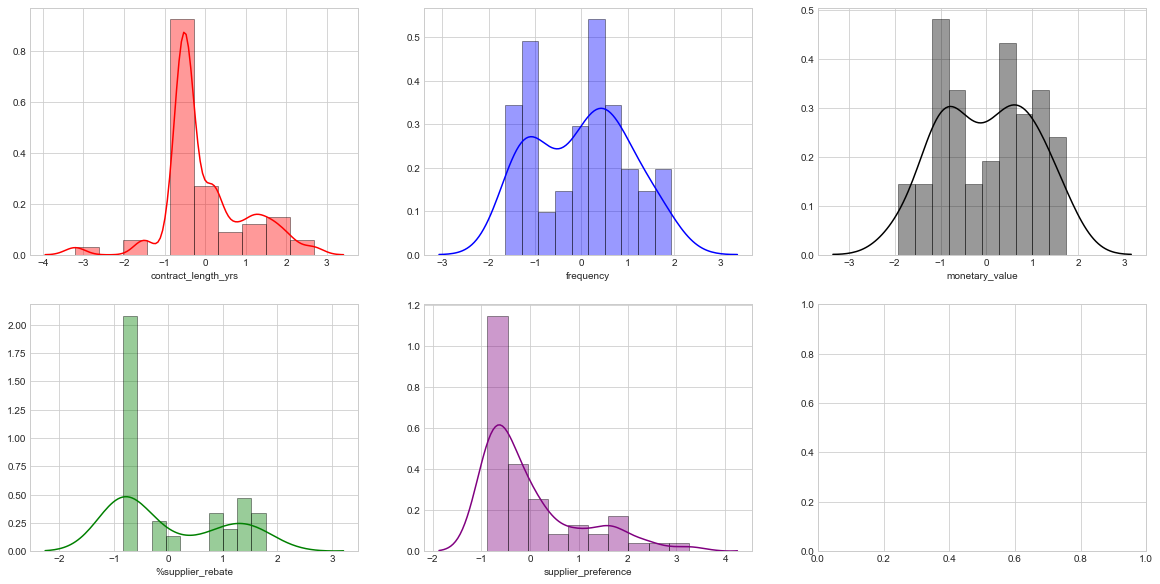

In [2702]:
#Distplot:
fig,axes = plt.subplots(nrows= 2, ncols=3, figsize = (20,10))
sns.distplot(df_segmented_2_log_normalized['contract_length_yrs'], bins = 10, ax = axes[0,0], color='red')
sns.distplot(df_segmented_2_log_normalized['frequency'], bins = 10, ax = axes[0,1], color='blue')
sns.distplot(df_segmented_2_log_normalized['monetary_value'], bins = 10, ax = axes[0,2], color = 'black')
sns.distplot(df_segmented_2_log_normalized['%supplier_rebate'], bins = 10, ax = axes[1,0], color= 'green')
sns.distplot(df_segmented_2_log_normalized['supplier_preference'], bins = 10, ax = axes[1,1], color='purple')

#### Observation: 
1. Segmented table after log transformation and normalization is now on the same scale as well as less skewed than before.

#### Fit Model: K-Means Clustering

#### Question 43: How to select optimal number of K in K-mean clustering?

#### Find optimal number of clusters using Elbow Method: 

In [2716]:
#Import K-Means model: 
from sklearn.cluster import KMeans


'''
Calculate SSE: It measures difference in each observation from it's group mean in a cluster. 
Optimal K-Value: It is selected at the elbow point (see graph), 
                  where change in SSE becomes marginal with the increase in K.  
'''

#Create empty dictionary of Sum of squared error (sse)
sse_2 = {}

# iterate values of k clusters from 1 to 30: 
for k in range(1,30):
    
    #Initiate Kmeans
    k_m_2 = KMeans(n_clusters=k, random_state=12)
    
    #Fit model:
    k_m_2.fit(df_segmented_2_log_normalized)
    
    #Calculate sse for each value of k
    sse_2[k] = k_m_2.inertia_  

In [2717]:
#View K and corresponding SSE values. 
print('SSE Key Value-Pairs:' '\n',sse_2.keys(), sse_2.values())

SSE Key Value-Pairs:
 dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]) dict_values([285.0, 152.92986646726573, 116.96513194527247, 86.44517151634861, 69.2095522955156, 57.803506514970195, 49.35620072914275, 44.435362681897374, 37.683221841191056, 33.06319508134999, 28.548165998288766, 26.642428197452446, 22.65636774828907, 20.113988043562415, 18.48517693684075, 16.68902930857081, 14.500601477386372, 13.597819627410576, 12.888974544941973, 12.19982692666552, 10.42123823659722, 10.229210309908424, 8.689766557272899, 8.062926178834267, 7.4251148043968795, 6.673481220812953, 5.971282175397253, 5.561425834784168, 4.923310099578013])


Text(4,80,'K=5')

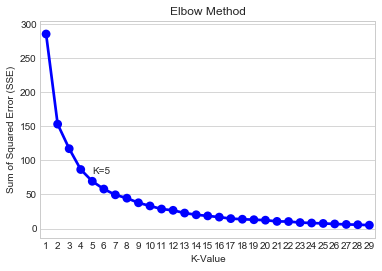

In [2718]:
sns.pointplot(x=list(sse_2.keys()), y = list(sse_2.values()), color='blue')
plt.xlabel('K-Value')
plt.ylabel('Sum of Squared Error (SSE)')
plt.title('Elbow Method')
plt.annotate('K=5', xy =(4,80))

#### Observation: 
1. At K =5, we noticed an elbow point where change in SSE becomes marginal when compared to it's previous K-value.
2. Hence, K =5 will be the optimal number of clusters we will use to describe our model. 

#### Applying K-Means Model using optimal K-Value : 

In [2719]:
#initiatlize kmeans with optimal clusters:
k_m_2 = KMeans(n_clusters=5, random_state=12)

#Fit model:

k_m_2.fit(df_segmented_2_log_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=12, tol=0.0001, verbose=0)

In [2720]:
#Generate Cluster labels: 
suppliers=k_m_2.labels_

#Assign cluster labels to segmented table: 
supplier_cluster = segmented_2_log.assign(supplier_clusters=suppliers)

In [2721]:
#View Table: 
supplier_cluster.head()

,contract_length_yrs,frequency,monetary_value,%supplier_rebate,supplier_preference,supplier_clusters
supplier,,,,,,
S-0003,1.609438,1.609438,5.956019,0.0,0.693147,1
S-0004,1.386294,0.693147,2.556452,0.0,0.693147,4
S-0005,1.098612,9.097955,10.776943,0.0,3.218876,3
S-0006,1.386294,5.707110,8.954426,0.0,0.693147,4
S-0007,1.791759,7.347300,11.098638,0.0,1.791759,3


#### Question 44:  How would we describe the properties of our supplier clusters ?

Again, our focus here would be to build an aggregated table and see how does the mean value vary for each supplier cluster

#### Build Aggregated Table for the Clusters: 

In [2722]:
#Aggregated table:
supplier_agg=supplier_cluster.groupby('supplier_clusters').agg({'contract_length_yrs': ['mean', 'count'],
                                                              'frequency': ['mean', 'count'],
                                                              'monetary_value': ['mean', 'count'], 
                                                              '%supplier_rebate': ['mean', 'count'],
                                                              'supplier_preference': ['mean', 'count']}).round(decimals= 1) 

In [2723]:
#View Table: 
supplier_agg.stack()

contract_length_yrs  frequency  monetary_value  \
supplier_clusters                                                         
0                 mean                   1.5        4.4             5.2   
                  count                 10.0       10.0            10.0   
1                 mean                   1.9        3.1             5.3   
                  count                  9.0        9.0             9.0   
2                 mean                   0.9       11.8            13.4   
                  count                 10.0       10.0            10.0   
3                 mean                   1.2        8.7            10.7   
                  count                 15.0       15.0            15.0   
4                 mean                   1.2        3.7             4.1   
                  count                 13.0       13.0            13.0   

                         %supplier_rebate  supplier_preference  
supplier_clusters                                               
0                 mean                3.5                  1.8  
                  count              10.0                 10.0  
1                 mean                0.0                  1.1  
                  count               9.0                  9.0  
2                 mean                3.0                  6.8  
                  count              10.0                 10.0  
3                 mean                0.6                  2.8  
                  count              15.0                 15.0  
4                 mean                0.0                  0.9  
                  count              13.0                 13.0

#### Observation:
1. From above table we can observe, that each cluster carries certain mean value for each criteria. 
2. Example: Supplier Cluster 0 has 10 suppliers with normalized mean values for each criteria.
3. K-Means algorithm will assign cluster lables to the suppliers based on how close normalized values are from its mean while far separated from other clusters.

In [2724]:
#Melt Table
supplier_melt= pd.melt(supplier_cluster.reset_index(), 
                        id_vars=['supplier','supplier_clusters'],
                        value_vars=['contract_length_yrs','frequency', 'monetary_value', '%supplier_rebate', 'supplier_preference'],
                        var_name='criteria',
                        value_name='normalized_value')

supplier_melt.head()

,supplier,supplier_clusters,criteria,normalized_value
0,S-0003,1,contract_length_yrs,1.609438
1,S-0004,4,contract_length_yrs,1.386294
2,S-0005,3,contract_length_yrs,1.098612
3,S-0006,4,contract_length_yrs,1.386294
4,S-0007,3,contract_length_yrs,1.791759


#### Question 45: Which supplier clusters are closer to the mean? 

In [2725]:
supplier_melt[(supplier_melt['criteria']=='contract_length_yrs') & (supplier_melt['supplier_clusters']==0)].describe()

,supplier_clusters,normalized_value
count,10.0,10.000000
mean,0.0,1.488127
std,0.0,0.357833
min,0.0,1.098612
25%,0.0,1.170533
50%,0.0,1.386294
75%,0.0,1.746179
max,0.0,2.079442


#### Observation: 
1. Supplier cluster 0 has been assigned to contract_length_yrs based on normalized values between 1.6 and 2.3. 
2. Similarly we can identify Supplier Cluster lables for other suppliers. 

#### Overall view of Supplier Clusters and how it varies with the business needs (Supplier Criteria): 

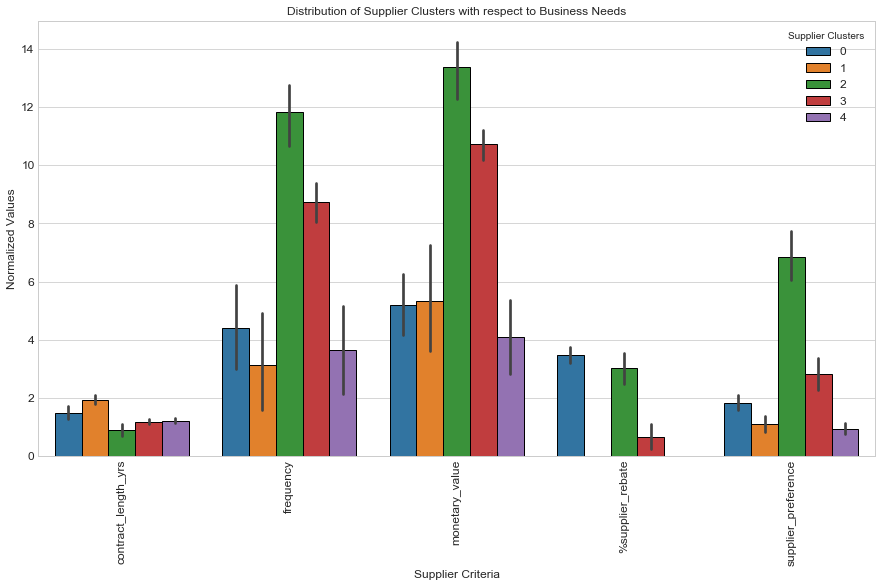

In [2726]:
#Plot Criteria Vs Normalized value:
plt.figure(figsize= (15,8))
sns.barplot(x= 'criteria', y = 'normalized_value', data=supplier_melt, hue='supplier_clusters')
plt.xticks(fontsize = 12,rotation= 90)
plt.yticks(fontsize = 12)
plt.xlabel('Supplier Criteria', fontsize = 12)
plt.ylabel('Normalized Values', fontsize= 12)
plt.title('Distribution of Supplier Clusters with respect to Business Needs', fontsize= 12)
plt.legend(title= 'Supplier Clusters', fontsize= 'large')

Text(0.5,1,'Trend of Supplier Clusters against Business Needs')

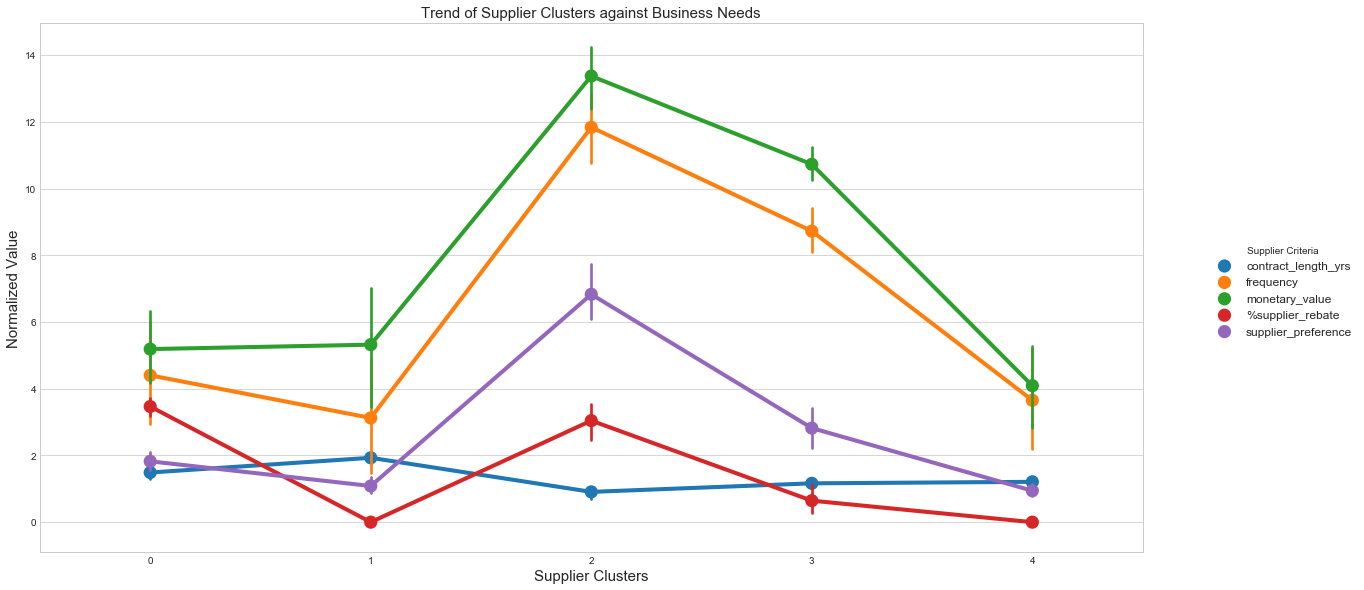

In [2729]:
#Plot Supplier Lables against Normalized Value:
plt.figure(figsize= (16,8))
sns.pointplot(x= 'supplier_clusters', y = 'normalized_value', data= supplier_melt, hue='criteria', scale = 1.5, fontsize=3)
plt.tight_layout()
plt.legend(loc='best', bbox_to_anchor=(1.2, 0.5))
plt.title('Supplier Segmentation', fontsize=15)
plt.xlabel('Supplier Clusters', fontsize=15)
plt.ylabel('Normalized Value', fontsize=15)
plt.legend(title= 'Supplier Criteria', fontsize = 'large',  fancybox= True, loc = 'upper right', bbox_to_anchor=(1.2,0.6))
plt.title('Trend of Supplier Clusters against Business Needs', fontsize = 15)

In [2990]:
# View Supplier Lable 2: 
supplier_melt[supplier_melt['supplier_clusters']==2].head()

,supplier,supplier_clusters,criteria,normalized_value
9,S-0013,2,contract_length_yrs,0.693147
10,S-0014,2,contract_length_yrs,1.098612
17,S-0026,2,contract_length_yrs,0.000000
22,S-0041,2,contract_length_yrs,1.098612
28,S-0054,2,contract_length_yrs,1.098612


#### Observation: Response to Question 42:
1. Supplier clusters 1 and 4 has the lowest suppplier preference and offer no rebates (similar to Sole Suppliers). We should consider possible scope re-assignement or spend consolidation with tactical or preferred suppliers in order to obtain better rebates.  
2. Supplier Cluster 2 is the best managed portfolio offering high rebates and have high supplier preference (Similar to Preferred Suppliers).  
3. Supplier Cluster 0 demonstrates similar characterstics with cluster 2 but demonstrates very low supplier preference. There may be an opportunity to develop cluster 0 at par with cluster 2 and encourage healthy competition. 
4. Supplier cluster 3 has shorter contract length, 2nd best supplier preference and significantly lower supplier rebates relative to the high spend they manage. There should be an opportunity to negotiate better contract rates for a longer term deal.

<b>Supplier Cluster 2 can be used as a benchmark to manage other suppliers and find improvements. 
    
                                                                                               END of Section 2 


## Conclusion: 

1. Random Forest and K-means algorithm worked extremely well in predicting supplier pricing as well as categorizing assemblies and suppliers by the business needs. 
2. As a result, we were able to predict how much an assembly of a given specification would cost to business, which category it would belong to and if the assembly would be supplied by our preferred supplier or not. 
3. This gave us the opportunity to establish benchmark out of a pool of 10k unique assemblies and 57 suppliers. 

## Future Possibilities: 

1. Supplier Performance: We can add other features such as on-time delivery, safety statistics, contract compliance and inventory information to our existing model to gain further supplier insights. 
2. Real Time Dashboarding: We can connect our model to a real time data feed and monitor actionable insights using a dashboard. 
3. Further Modelling: We can try other algorithms such as timeseries to predict year over year changes in supplier pricing. 